<a href="https://colab.research.google.com/github/InantsKhach/speech-tech-rau/blob/Khachaturs_branch/hw1/Inants_Khachatur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Install dependencies
!pip install wget
!apt-get install sox libsndfile1 ffmpeg
!pip install text-unidecode

## Install NeMo
BRANCH = 'main'
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=a484383051cb560047504883d65027256432f2bb7d4a58594bc27fb96ceb414b
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libsndfile1 is already the newest version (1.0.31-2ubuntu0.1).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
The following additional packages will be installed:
  libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa libsox-fmt-base libsox3 libwavpack1
Suggested packages:
  libsox-fmt-all
The following NEW packages will be installed:
  libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa libsox-fmt-base libsox3 libwavpack1 sox
0 upgraded, 7 newly installed, 0 to remove and 35 not upgraded.
Need to get 617 kB of archives.
After this operation, 1,764 kB of additi

# ASR

ASR, or **Automatic Speech Recognition**, refers to the problem of getting a program to automatically **transcribe spoken language (speech-to-text)**. Our goal is usually to have a model that minimizes the Word Error Rate (WER) metric when transcribing speech input. In other words, given some audio file (e.g. a WAV file) containing speech, how do we transform this into the corresponding text with as few errors as possible?

## Taking a Look at Our Data (AN4)

The AN4 dataset, also known as the Alphanumeric dataset, was collected and published by Carnegie Mellon University. It consists of recordings of people spelling out addresses, names, telephone numbers, etc., one letter or number at a time, as well as their corresponding transcripts. We choose to use AN4 for this tutorial because it is relatively small, with 948 training and 130 test utterances, and so it trains quickly.

Before we get started, let's download and prepare the dataset. The utterances are available as `.sph` files, so we will need to convert them to `.wav` for later processing. If you are not using Google Colab, please make sure you have [Sox](http://sox.sourceforge.net/) installed for this step--see the "Downloads" section of the linked Sox homepage. (If you are using Google Colab, Sox should have already been installed in the setup cell at the beginning.)

In [2]:
import glob
import os
import subprocess
import tarfile
import wget
# This is where the an4/ directory will be placed.
# Change this if you don't want the data to be extracted in the current directory.
data_dir = '.'

if not os.path.exists(data_dir):
  os.makedirs(data_dir)


# Download the dataset. This will take a few moments...
print("******")
if not os.path.exists(data_dir + '/an4_sphere.tar.gz'):
    an4_url = 'https://dldata-public.s3.us-east-2.amazonaws.com/an4_sphere.tar.gz'
    an4_path = wget.download(an4_url, data_dir)
    print(f"Dataset downloaded at: {an4_path}")
else:
    print("Tarfile already exists.")
    an4_path = data_dir + '/an4_sphere.tar.gz'

if not os.path.exists(data_dir + '/an4/'):
    # Untar and convert .sph to .wav (using sox)
    tar = tarfile.open(an4_path)
    tar.extractall(path=data_dir)

    print("Converting .sph to .wav...")
    sph_list = glob.glob(data_dir + '/an4/**/*.sph', recursive=True)
    for sph_path in sph_list:
        wav_path = sph_path[:-4] + '.wav'
        cmd = ["sox", sph_path, wav_path]
        subprocess.run(cmd)
print("Finished conversion.\n******")

******
Dataset downloaded at: ./an4_sphere.tar.gz
Converting .sph to .wav...
Finished conversion.
******


You should now have a folder called `an4` that contains `etc/an4_train.transcription`, `etc/an4_test.transcription`, audio files in `wav/an4_clstk` and `wav/an4test_clstk`, along with some other files we will not need.

Now we can load and take a look at the data. As an example, file `cen2-mgah-b.wav` is a 2.6 second-long audio recording of a man saying the letters "G L E N N" one-by-one. To confirm this, we can listen to the file:

In [3]:
import librosa
import IPython.display as ipd

# Load and listen to the audio file
example_file = data_dir + '/an4/wav/an4_clstk/mgah/cen2-mgah-b.wav'
audio, sample_rate = librosa.load(example_file)

ipd.Audio(example_file, rate=sample_rate)

In an ASR task, if this WAV file was our input, then "G L E N N" would be our desired output.

Let's plot the waveform, which is simply a line plot of the sequence of values that we read from the file. This is a format of viewing audio that you are likely to be familiar with seeing in many audio editors and visualizers:

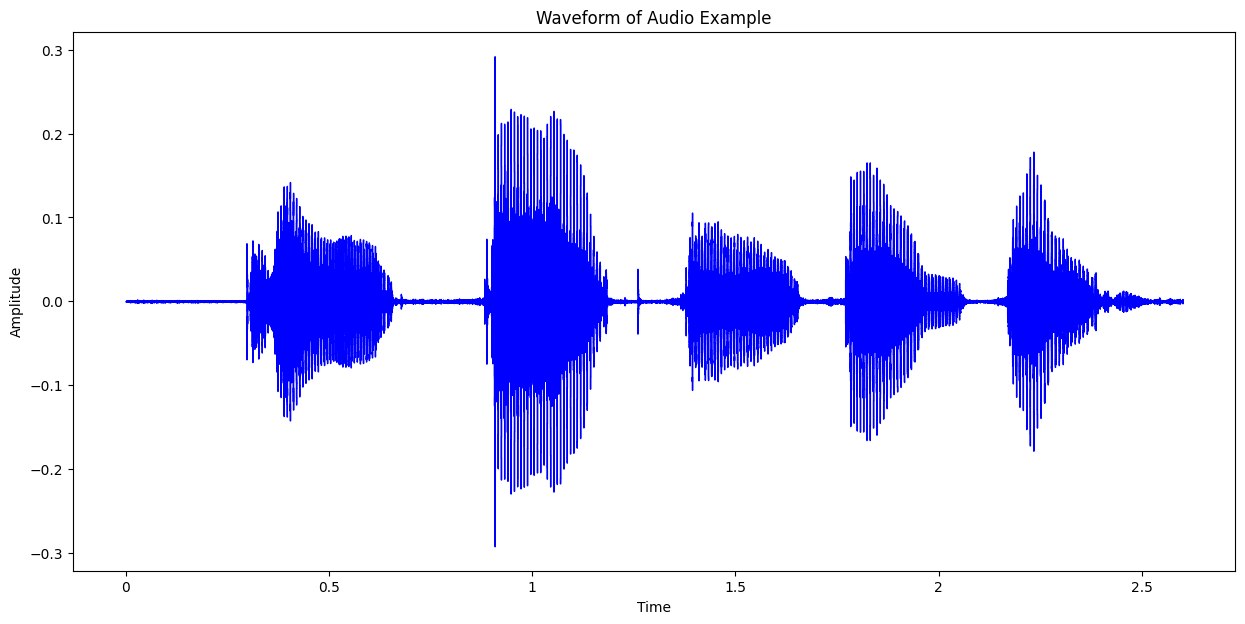

In [4]:
%matplotlib inline
import librosa.display
import matplotlib.pyplot as plt

# Plot our example audio file's waveform
plt.rcParams['figure.figsize'] = (15,7)
plt.title('Waveform of Audio Example')
plt.ylabel('Amplitude')

_ = librosa.display.waveshow(audio, color='blue')

We can see the activity in the waveform that corresponds to each letter in the audio, as our speaker here enunciates quite clearly!
You can kind of tell that each spoken letter has a different "shape," and it's interesting to note that last two blobs look relatively similar, which is expected because they are both the letter "N."

### Spectrograms and Mel Spectrograms

However, since audio information is more useful in the context of frequencies of sound over time, we can get a better representation than this raw sequence of 57,330 values.
We can apply a [Fourier Transform](https://en.wikipedia.org/wiki/Fourier_transform) on our audio signal to get something more useful: a **spectrogram**, which is a representation of the energy levels (i.e. amplitude, or "loudness") of each frequency (i.e. pitch) of the signal over the duration of the file.
A spectrogram (which can be viewed as a heat map) is a good way of seeing how the *strengths of various frequencies in the audio vary over time*, and is obtained by breaking up the signal into smaller, usually overlapping chunks and performing a Short-Time Fourier Transform (STFT) on each.

Let's examine what the spectrogram of our sample looks like.

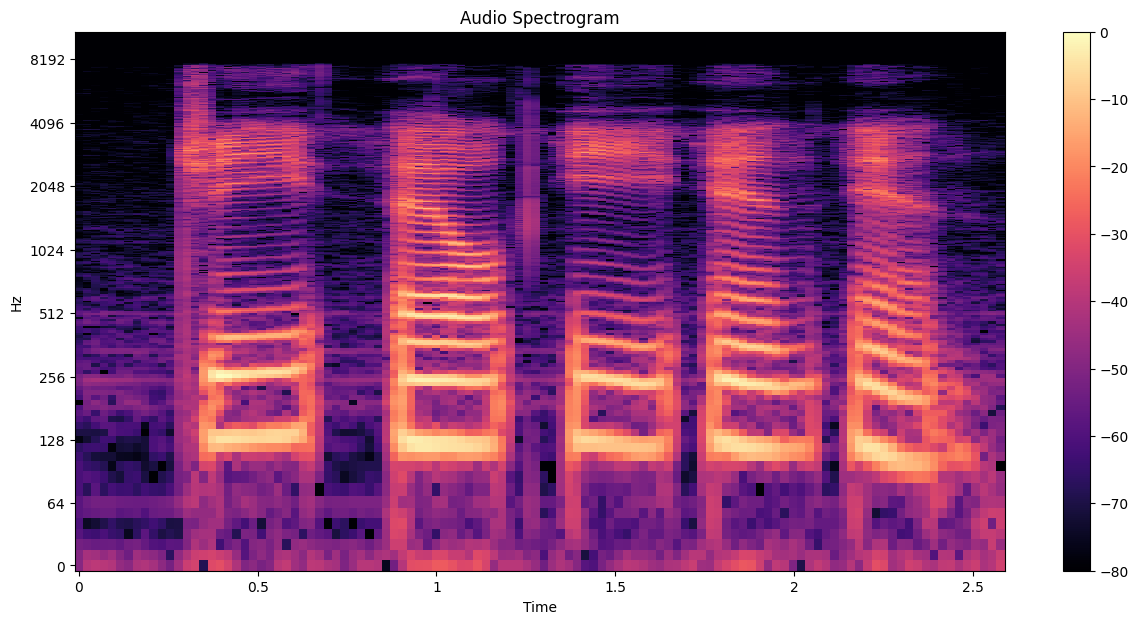

In [5]:
import numpy as np

# Get spectrogram using Librosa's Short-Time Fourier Transform (stft)
spec = np.abs(librosa.stft(audio))
spec_db = librosa.amplitude_to_db(spec, ref=np.max)  # Decibels

# Use log scale to view frequencies
librosa.display.specshow(spec_db, y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Audio Spectrogram');

Again, we are able to see each letter being pronounced, and that the last two blobs that correspond to the "N"s are pretty similar-looking. But how do we interpret these shapes and colors? Just as in the waveform plot before, we see time passing on the x-axis (all 2.6s of audio). But now, the y-axis represents different frequencies (on a log scale), and *the color on the plot shows the strength of a frequency at a particular point in time*.

We're still not done yet, as we can make one more potentially useful tweak: using the **Mel Spectrogram** instead of the normal spectrogram. This is simply a change in the frequency scale that we use from linear (or logarithmic) to the mel scale, which is "a perceptual scale of pitches judged by listeners to be equal in distance from one another" (from [Wikipedia](https://en.wikipedia.org/wiki/Mel_scale)).

In other words, it's a transformation of the frequencies to be more aligned to what humans perceive; a change of +1000Hz from 2000Hz->3000Hz sounds like a larger difference to us than 9000Hz->10000Hz does, so the mel scale normalizes this such that equal distances sound like equal differences to the human ear. Intuitively, we use the mel spectrogram because in this case we are processing and transcribing human speech, such that transforming the scale to better match what we hear is a useful procedure.

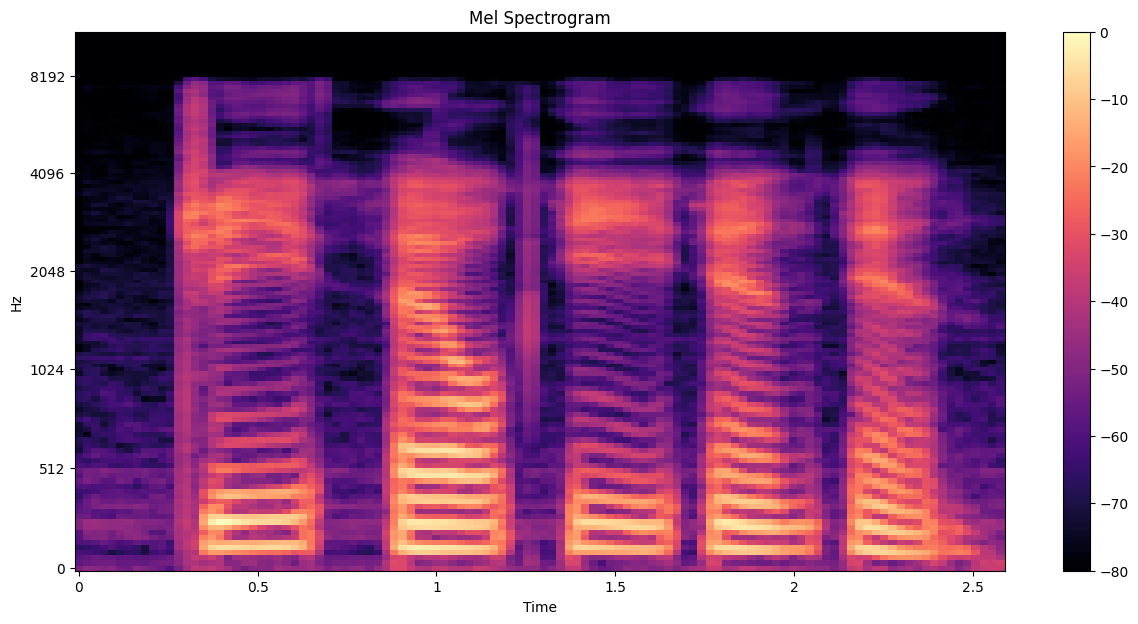

In [6]:
# Plot the mel spectrogram of our sample
mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

librosa.display.specshow(
    mel_spec_db, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title('Mel Spectrogram');

# Using NeMo for Automatic Speech Recognition

Now that we have an idea of what ASR is and how the audio data looks like, we can start using NeMo to do some ASR!

We'll be using the **Neural Modules (NeMo) toolkit** for this part, so if you haven't already, you should download and install NeMo and its dependencies. To do so, just follow the directions on the [GitHub page](https://github.com/NVIDIA/NeMo), or in the [documentation](https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/).

NeMo lets us easily hook together the components (modules) of our model, such as the data layer, intermediate layers, and various losses, without worrying too much about implementation details of individual parts or connections between modules. NeMo also comes with complete models which only require your data and hyperparameters for training.

In [7]:
# NeMo's "core" package
import nemo
# NeMo's ASR collection - this collections contains complete ASR models and
# building blocks (modules) for ASR
import nemo.collections.asr as nemo_asr

## Using an Out-of-the-Box Model

NeMo's ASR collection comes with many building blocks and even complete models that we can use for training and evaluation. Moreover, several models come with pre-trained weights. Let's instantiate a complete QuartzNet15x5 model.

To achieve this we will use ``` from_pretrained() ``` method. However, you may use .nemo model files and ```restore_from() ``` methods.

In [8]:
# This line will download pre-trained QuartzNet15x5 model from NVIDIA's NGC cloud and instantiate it for you otherwise use restore_from()
quartznet = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="QuartzNet15x5Base-En")

[NeMo I 2024-02-26 14:24:07 cloud:68] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemospeechmodels/versions/1.0.0a5/files/QuartzNet15x5Base-En.nemo to /root/.cache/torch/NeMo/NeMo_1.23.0rc0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2024-02-26 14:24:09 common:815] Instantiating model from pre-trained checkpoint
[NeMo I 2024-02-26 14:24:10 features:289] PADDING: 16
[NeMo I 2024-02-26 14:24:11 save_restore_connector:263] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0rc0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.


Next, we'll simply add paths to files we want to transcribe into the list and pass it to our model. Note that it will work for relatively short (<25 seconds) files.

In [9]:
files = [os.path.join(data_dir, 'an4/wav/an4_clstk/mgah/cen2-mgah-b.wav')]
for fname, transcription in zip(files, quartznet.transcribe(files)):
  print(f"\nAudio in {fname} was recognized as: {transcription}")

Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Audio in ./an4/wav/an4_clstk/mgah/cen2-mgah-b.wav was recognized as: g l e n n


# Basic homework
Conduct ASR in Russian language. Use your microphone to record input data. Use Russian language.

The following cell will download suggested model.

In [10]:
import tarfile
import wget
import os
# imports
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
from io import BytesIO
!pip -q install pydub
from pydub import AudioSegment

def download(url, out_path):
  data_dir = '.'
  if not os.path.exists(data_dir):
      os.makedirs(data_dir)
  if not os.path.exists(os.path.join(data_dir, out_path)):
      golos_path = wget.download(url, os.path.join(data_dir, out_path))
      print(f"Model downloaded at: {golos_path}")
  else:
      print("already exists.")
      golos_path = os.path.join(data_dir, out_path)

class AudioSignal:
  """
  SOUND RECORDER
  """
  @staticmethod
  def __record(file_name, sec=3):
    RECORD = """
    const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
    const b2text = blob => new Promise(resolve => {
      const reader = new FileReader()
      reader.onloadend = e => resolve(e.srcElement.result)
      reader.readAsDataURL(blob)
    })
    var record = time => new Promise(async resolve => {
      stream = await navigator.mediaDevices.getUserMedia({ audio: true })
      recorder = new MediaRecorder(stream)
      chunks = []
      recorder.ondataavailable = e => chunks.push(e.data)
      recorder.start()
      await sleep(time)
      recorder.onstop = async ()=>{
        blob = new Blob(chunks)
        text = await b2text(blob)
        resolve(text)
      }
      recorder.stop()
    })
    """
    display(Javascript(RECORD))
    s = output.eval_js('record(%d)' % (sec*1000))
    b = b64decode(s.split(',')[1])
    audio = AudioSegment.from_file(BytesIO(b))
    audio.export(file_name, format='wav', parameters=["-ar", "8000"])
    return audio

  def __init__(self, file_name):
    self.sample_rate = 8000
    self.file_name = file_name

  def record(self, sec):
    self.audioSegment = self.__record(self.file_name, sec)
    return self.audioSegment

In [11]:
golos_url = 'https://n-ws-3jtx8.s3pd12.sbercloud.ru/b-ws-3jtx8-eir/golos/QuartzNet15x5_golos.nemo'
model_path = '/QuartzNet15x5_golos.nemo'
download(golos_url, model_path)

Model downloaded at: /QuartzNet15x5_golos.nemo


In [ ]:
#FILL IN MODEL INITIALIZATION
ru_model = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="stt_ru_quartznet15x5")

In [15]:
audioSignal = AudioSignal(file_name='audio_a.wav')
audioSignal.record(sec=5)

<IPython.core.display.Javascript object>

In [16]:
#FILL IN TRANSCRIPTION
custom_output = ru_model.transcribe(['audio_a.wav'])

Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.63it/s]


In [17]:
print(custom_output)

['проверим работу']


# Advanced homework

In [18]:
dataset_url = "https://n-ws-3jtx8.s3pd12.sbercloud.ru/b-ws-3jtx8-eir/golos/test.tar"
dataset_path = "dataset.tar"
download(dataset_url, dataset_path)

Model downloaded at: ./dataset.tar


In [ ]:
!tar -xvf dataset.tar

In [20]:
import json

def extract_data(subset_path):
  gt_path = os.path.join(subset_path, "manifest.jsonl")

  gt_list_paths = []
  gt_list_transcriptions = []
  with open(gt_path, "r") as f:
      for line in f:
          sample_dict = json.loads(line)
          gt_list_paths.append(os.path.join(subset_path, sample_dict["audio_filepath"]))
          gt_list_transcriptions.append(sample_dict["text"])
  return gt_list_paths, gt_list_transcriptions

In [21]:
subset1, subset2 = "./test/farfield", "./test/crowd"
gt_list_paths_farfield, gt_list_transcriptions_farfield = extract_data( subset1 )
gt_list_paths_crowd, gt_list_transcriptions_crowd = extract_data( subset2 )

In [22]:
print(len(gt_list_transcriptions_crowd), len(gt_list_transcriptions_farfield))

9994 1916


Use Russian language ASR model to transcribe dataset

In [23]:
#FILL IN FARFIELD OUTPUTS

ls = os.listdir('test/farfield/files')
print(len(ls), ls[0])
farfield_outputs = list()

for aud in ls:
  farfield_outputs.append(ru_model.transcribe(os.path.join('test/farfield/files', aud)))


1916 4ddc742ee7a2978494526a1f01d8800b.wav


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.30it/s]


In [26]:
#FILL IN CROWD OUTPUTS
ls = os.listdir('test/crowd/files')
print(len(ls), ls[0])
crowd_outputs = list()
i = 0
for aud in ls:
  crowd_outputs.append(ru_model.transcribe(os.path.join('test/crowd/files', aud)))
  print(i)
  i += 1


9994 232e23e691c2c3526bdcc84151d5b575.wav


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.38it/s]


0


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 21.30it/s]


1


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.61it/s]


2


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.97it/s]


3


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.85it/s]


4


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.06it/s]


5


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.77it/s]


6


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.93it/s]


7


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.44it/s]


8


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.33it/s]


9


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.45it/s]


10


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.49it/s]


11


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.63it/s]


12


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.28it/s]


13


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.96it/s]


14


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.84it/s]


15


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.00it/s]


16


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


17


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.76it/s]


18


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.37it/s]


19


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.92it/s]


20


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.58it/s]


21


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.14it/s]


22


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.97it/s]


23


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 21.26it/s]


24


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 21.07it/s]


25


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.64it/s]


26


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.78it/s]


27


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.59it/s]


28


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.17it/s]


29


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.46it/s]


30


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.45it/s]


31


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.57it/s]


32


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.57it/s]


33


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.83it/s]


34


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.12it/s]


35


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.63it/s]


36


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.90it/s]


37


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.86it/s]


38


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.05it/s]


39


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.72it/s]


40


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.54it/s]


41


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.37it/s]


42


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.44it/s]


43


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.42it/s]


44


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.58it/s]


45


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.62it/s]


46


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.13it/s]


47


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.77it/s]


48


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.89it/s]


49


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.57it/s]


50


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.20it/s]


51


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.65it/s]


52


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.16it/s]


53


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.42it/s]


54


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.69it/s]


55


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.52it/s]


56


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.33it/s]


57


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.97it/s]


58


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.01it/s]


59


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.91it/s]


60


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.24it/s]


61


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.61it/s]


62


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.99it/s]


63


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.05it/s]


64


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.19it/s]


65


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.67it/s]


66


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.16it/s]


67


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.20it/s]


68


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.34it/s]


69


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.79it/s]


70


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.23it/s]


71


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 21.51it/s]


72


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.27it/s]


73


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.03it/s]


74


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


75


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.90it/s]


76


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.85it/s]


77


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.49it/s]


78


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.13it/s]


79


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 21.18it/s]


80


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.68it/s]


81


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.78it/s]


82


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.29it/s]


83


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.31it/s]


84


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.03it/s]


85


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.17it/s]


86


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.93it/s]


87


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.22it/s]


88


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.01it/s]


89


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.72it/s]


90


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s]


91


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 21.50it/s]


92


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.30it/s]


93


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.82it/s]


94


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.45it/s]


95


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.94it/s]


96


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.24it/s]


97


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.01it/s]


98


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.42it/s]


99


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.65it/s]


100


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.05it/s]


101


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.37it/s]


102


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.53it/s]


103


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.18it/s]


104


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.58it/s]


105


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.86it/s]


106


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.03it/s]


107


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.17it/s]


108


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.55it/s]


109


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.59it/s]


110


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.71it/s]


111


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.71it/s]


112


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.32it/s]


113


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.84it/s]


114


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.46it/s]


115


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.86it/s]


116


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 21.06it/s]


117


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.10it/s]


118


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.97it/s]


119


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.51it/s]


120


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


121


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.54it/s]


122


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.08it/s]


123


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.75it/s]


124


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.95it/s]


125


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.35it/s]


126


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.07it/s]


127


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.10it/s]


128


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.12it/s]


129


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.29it/s]


130


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.99it/s]


131


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.19it/s]


132


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.88it/s]


133


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.45it/s]


134


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.57it/s]


135


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.75it/s]


136


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


137


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.21it/s]


138


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.13it/s]


139


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.52it/s]


140


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.28it/s]


141


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.59it/s]


142


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.97it/s]


143


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


144


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.55it/s]


145


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.55it/s]


146


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.64it/s]


147


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.47it/s]


148


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.87it/s]


149


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.80it/s]


150


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.27it/s]


151


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.26it/s]


152


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.24it/s]


153


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.23it/s]


154


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.74it/s]


155


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.54it/s]


156


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.46it/s]


157


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.29it/s]


158


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.35it/s]


159


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


160


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.71it/s]


161


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.78it/s]


162


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 21.10it/s]


163


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.02it/s]


164


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


165


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.59it/s]


166


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.37it/s]


167


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.87it/s]


168


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.64it/s]


169


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.87it/s]


170


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.30it/s]


171


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.04it/s]


172


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.93it/s]


173


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.61it/s]


174


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.01it/s]


175


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.63it/s]


176


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.04it/s]


177


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.54it/s]


178


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.96it/s]


179


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.57it/s]


180


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.64it/s]


181


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.62it/s]


182


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


183


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.61it/s]


184


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.59it/s]


185


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


186


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.75it/s]


187


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s]


188


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.53it/s]


189


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.76it/s]


190


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.54it/s]


191


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.60it/s]


192


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.37it/s]


193


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.83it/s]


194


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.66it/s]


195


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.99it/s]


196


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.88it/s]


197


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.93it/s]


198


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.29it/s]


199


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.07it/s]


200


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.27it/s]


201


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.83it/s]


202


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.85it/s]


203


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


204


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.59it/s]


205


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.50it/s]


206


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.42it/s]


207


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.52it/s]


208


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.80it/s]


209


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.51it/s]


210


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.70it/s]


211


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.94it/s]


212


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.52it/s]


213


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.51it/s]


214


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.83it/s]


215


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.57it/s]


216


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.52it/s]


217


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.08it/s]


218


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.42it/s]


219


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.46it/s]


220


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.42it/s]


221


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.62it/s]


222


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.37it/s]


223


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


224


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.14it/s]


225


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.28it/s]


226


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.01it/s]


227


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.34it/s]


228


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.36it/s]


229


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.15it/s]


230


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.53it/s]


231


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.27it/s]


232


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


233


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.36it/s]


234


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.72it/s]


235


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.10it/s]


236


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.60it/s]


237


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.23it/s]


238


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


239


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.76it/s]


240


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


241


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.48it/s]


242


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.32it/s]


243


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.33it/s]


244


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.75it/s]


245


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.50it/s]


246


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.16it/s]


247


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.02it/s]


248


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


249


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.77it/s]


250


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.44it/s]


251


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]


252


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.60it/s]


253


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.17it/s]


254


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.55it/s]


255


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.42it/s]


256


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]


257


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


258


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


259


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


260


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.74it/s]


261


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.66it/s]


262


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.12it/s]


263


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.57it/s]


264


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.13it/s]


265


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.93it/s]


266


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.35it/s]


267


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.54it/s]


268


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.59it/s]


269


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


270


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.09it/s]


271


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.17it/s]


272


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.63it/s]


273


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


274


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.80it/s]


275


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.11it/s]


276


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


277


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.46it/s]


278


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.84it/s]


279


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.18it/s]


280


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.71it/s]


281


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.23it/s]


282


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.05it/s]


283


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


284


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.05it/s]


285


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.67it/s]


286


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.12it/s]


287


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.93it/s]


288


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.00it/s]


289


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.00it/s]


290


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


291


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.40it/s]


292


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.65it/s]


293


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


294


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.91it/s]


295


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.26it/s]


296


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.97it/s]


297


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.47it/s]


298


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.32it/s]


299


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.23it/s]


300


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


301


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.28it/s]


302


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.66it/s]


303


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.74it/s]


304


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.34it/s]


305


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.00it/s]


306


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.33it/s]


307


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.18it/s]


308


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


309


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.85it/s]


310


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


311


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.49it/s]


312


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.76it/s]


313


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s]


314


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.91it/s]


315


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.34it/s]


316


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.43it/s]


317


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.87it/s]


318


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.86it/s]


319


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.77it/s]


320


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.77it/s]


321


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.61it/s]


322


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.10it/s]


323


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.47it/s]


324


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.76it/s]


325


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.39it/s]


326


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.23it/s]


327


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.32it/s]


328


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.44it/s]


329


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.45it/s]


330


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.39it/s]


331


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.76it/s]


332


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.79it/s]


333


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.80it/s]


334


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.38it/s]


335


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.20it/s]


336


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.79it/s]


337


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.45it/s]


338


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.80it/s]


339


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.55it/s]


340


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.25it/s]


341


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.99it/s]


342


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


343


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.11it/s]


344


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.59it/s]


345


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.36it/s]


346


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.14it/s]


347


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.08it/s]


348


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.20it/s]


349


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


350


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.82it/s]


351


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.79it/s]


352


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.04it/s]


353


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s]


354


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.65it/s]


355


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.25it/s]


356


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


357


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.84it/s]


358


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.23it/s]


359


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.28it/s]


360


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.27it/s]


361


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.11it/s]


362


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.56it/s]


363


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.04it/s]


364


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.38it/s]


365


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s]


366


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


367


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


368


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.75it/s]


369


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.66it/s]


370


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.53it/s]


371


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.40it/s]


372


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]


373


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.28it/s]


374


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.11it/s]


375


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]


376


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.58it/s]


377


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


378


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.83it/s]


379


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.27it/s]


380


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.17it/s]


381


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.83it/s]


382


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


383


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


384


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.37it/s]


385


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 20.09it/s]


386


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.71it/s]


387


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.48it/s]


388


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.31it/s]


389


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s]


390


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


391


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.09it/s]


392


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.68it/s]


393


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.35it/s]


394


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s]


395


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.38it/s]


396


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.28it/s]


397


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.93it/s]


398


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


399


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.57it/s]


400


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.15it/s]


401


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.76it/s]


402


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]


403


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.75it/s]


404


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.89it/s]


405


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.38it/s]


406


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.18it/s]


407


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


408


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.29it/s]


409


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.34it/s]


410


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.46it/s]


411


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.40it/s]


412


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.67it/s]


413


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.65it/s]


414


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.22it/s]


415


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


416


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.50it/s]


417


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.12it/s]


418


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.49it/s]


419


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.91it/s]


420


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.06it/s]


421


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.04it/s]


422


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.89it/s]


423


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.80it/s]

424



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.35it/s]


425


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.71it/s]


426


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.97it/s]


427


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.36it/s]


428


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.03it/s]


429


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.32it/s]


430


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.64it/s]


431


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.42it/s]


432


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.68it/s]


433


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.11it/s]


434


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.07it/s]


435


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.05it/s]

436



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


437


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


438


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.29it/s]


439


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.48it/s]


440


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.45it/s]


441


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


442


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.35it/s]


443


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.34it/s]


444


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


445


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.97it/s]


446


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.22it/s]


447


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.20it/s]


448


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s]


449


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.35it/s]


450


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.97it/s]

451



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.45it/s]

452



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.23it/s]


453


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.25it/s]


454


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


455


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.54it/s]


456


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.53it/s]


457


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.43it/s]


458


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.91it/s]


459


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


460


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]


461


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.54it/s]


462


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.00it/s]


463


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]


464


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.79it/s]


465


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


466


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


467


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.76it/s]


468


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.41it/s]


469


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.22it/s]


470


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s]


471


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.72it/s]


472


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.55it/s]


473


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.94it/s]


474


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.48it/s]


475


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s]


476


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s]


477


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s]


478


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.10it/s]


479


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.40it/s]

480



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.83it/s]


481


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s]


482


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.70it/s]


483


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.32it/s]


484


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.26it/s]


485


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.57it/s]

486



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.98it/s]


487


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.34it/s]


488


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.73it/s]


489


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.92it/s]


490


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.12it/s]


491


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


492


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.46it/s]


493


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.14it/s]


494


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


495


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.27it/s]


496


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


497


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.42it/s]


498


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.78it/s]


499


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.09it/s]


500


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.23it/s]


501


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.96it/s]


502


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


503


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.42it/s]


504


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.91it/s]


505


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.98it/s]


506


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.33it/s]


507


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.04it/s]


508


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


509


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.20it/s]


510


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.02it/s]


511


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.48it/s]


512


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


513


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.73it/s]


514


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.23it/s]


515


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.22it/s]


516


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.05it/s]


517


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.26it/s]


518


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.38it/s]


519


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


520


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s]


521


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s]


522


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s]


523


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.07it/s]


524


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.63it/s]


525


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.45it/s]


526


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.17it/s]


527


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.59it/s]


528


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.11it/s]


529


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.59it/s]


530


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.51it/s]


531


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.46it/s]


532


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.31it/s]


533


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.31it/s]


534


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.71it/s]


535


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.61it/s]


536


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.71it/s]


537


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.23it/s]


538


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.42it/s]


539


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.98it/s]


540


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.61it/s]


541


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


542


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.20it/s]


543


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


544


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.17it/s]


545


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.31it/s]


546


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.49it/s]


547


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]


548


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


549


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.97it/s]


550


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s]


551


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.07it/s]


552


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.32it/s]


553


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]

554



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


555


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.04it/s]


556


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.00it/s]


557


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.91it/s]


558


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]


559


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.53it/s]


560


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.00it/s]


561


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.89it/s]


562


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.66it/s]


563


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.18it/s]


564


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.46it/s]


565


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.42it/s]


566


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.28it/s]


567


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.81it/s]


568


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.00it/s]


569


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.49it/s]


570


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.20it/s]


571


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.34it/s]


572


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.29it/s]


573


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.77it/s]


574


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.29it/s]


575


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.74it/s]


576


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.99it/s]


577


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.79it/s]


578


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.72it/s]


579


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


580


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.88it/s]


581


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.72it/s]


582


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


583


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.35it/s]

584



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]


585


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.08it/s]


586


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.84it/s]


587


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.21it/s]

588



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.31it/s]

589



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.20it/s]


590


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


591


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.17it/s]


592


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.62it/s]


593


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.29it/s]

594



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.92it/s]


595


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.86it/s]


596


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.99it/s]


597


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.11it/s]


598


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.25it/s]


599


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.97it/s]


600


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]


601


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


602


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.06it/s]


603


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.63it/s]


604


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.22it/s]


605


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.73it/s]


606


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]


607


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


608


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.94it/s]


609


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.02it/s]


610


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.33it/s]


611


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.57it/s]


612


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.02it/s]


613


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.08it/s]

614



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.00it/s]

615



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


616


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


617


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.95it/s]


618


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


619


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


620


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


621


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.87it/s]


622


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.77it/s]


623


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]


624


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.79it/s]


625


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.15it/s]

626



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


627


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.07it/s]


628


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.94it/s]


629


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.14it/s]

630



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.52it/s]


631


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


632


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.61it/s]


633


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.11it/s]


634


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.08it/s]


635


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.58it/s]

636



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.25it/s]


637


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


638


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.01it/s]

639



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.25it/s]


640


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.11it/s]


641


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.44it/s]


642


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.86it/s]

643



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.56it/s]


644


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


645


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.56it/s]


646


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.51it/s]


647


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.79it/s]


648


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.83it/s]


649


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.69it/s]


650


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.19it/s]


651


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.79it/s]


652


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.66it/s]


653


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.41it/s]


654


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.23it/s]


655


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]


656


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.26it/s]


657


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.08it/s]


658


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.15it/s]


659


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.47it/s]


660


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.90it/s]


661


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


662


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]


663


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.11it/s]


664


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.12it/s]


665


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s]

666



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.86it/s]


667


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.46it/s]


668


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.81it/s]


669


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.12it/s]


670


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s]


671


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s]


672


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]


673


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.17it/s]


674


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s]


675


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


676


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


677


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.73it/s]


678


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.24it/s]


679


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.62it/s]


680


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


681


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.76it/s]


682


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.62it/s]


683


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.13it/s]


684


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.21it/s]


685


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.95it/s]


686


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.63it/s]


687


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.98it/s]


688


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.15it/s]


689


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.06it/s]


690


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.12it/s]

691



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.22it/s]


692


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.33it/s]


693


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.72it/s]


694


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


695


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 19.48it/s]


696


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s]


697


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.48it/s]


698


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.38it/s]


699


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.15it/s]


700


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.54it/s]


701


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.62it/s]


702


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]


703


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s]


704


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.16it/s]


705


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.54it/s]


706


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.26it/s]


707


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


708


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.36it/s]


709


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.00it/s]

710



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.40it/s]


711


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.16it/s]

712



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.85it/s]


713


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]

714



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.96it/s]


715


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.72it/s]


716


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.67it/s]


717


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]

718



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.08it/s]


719


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.61it/s]


720


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.63it/s]


721


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.61it/s]


722


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]

723

Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.86it/s]


724


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.51it/s]

725



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.88it/s]

726



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.01it/s]


727


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


728


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.63it/s]

729



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]

730



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.03it/s]


731


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.56it/s]


732


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


733


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.42it/s]


734


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.79it/s]


735


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.48it/s]

736



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.01it/s]


737


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.74it/s]


738


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.63it/s]


739


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


740


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.47it/s]


741


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.73it/s]


742


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


743


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.21it/s]


744


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


745


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s]


746


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


747


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.22it/s]


748


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.48it/s]


749


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.76it/s]


750


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.26it/s]


751


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.55it/s]


752


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.10it/s]


753


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


754


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.10it/s]


755


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


756


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.79it/s]


757


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s]


758


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.02it/s]


759


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.96it/s]


760


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.17it/s]


761


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.16it/s]


762


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


763


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.04it/s]


764


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.94it/s]


765


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.14it/s]


766


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.35it/s]


767


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


768


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


769


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]


770


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


771


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.47it/s]


772


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.45it/s]


773


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]


774


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.00it/s]


775


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.48it/s]

776



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.93it/s]


777


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


778


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s]


779


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.32it/s]


780


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.18it/s]


781


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.40it/s]

782



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.83it/s]


783


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.54it/s]


784


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.63it/s]


785


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.83it/s]


786


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


787


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.37it/s]


788


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


789


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.98it/s]


790


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.91it/s]


791


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.60it/s]


792


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.41it/s]


793


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.69it/s]


794


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.40it/s]


795


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s]


796


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.27it/s]


797


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.12it/s]


798


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.59it/s]


799


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.93it/s]


800


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.08it/s]


801


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.99it/s]


802


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.40it/s]


803


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.96it/s]


804


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.91it/s]


805


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.57it/s]


806


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.13it/s]


807


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.29it/s]


808


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.62it/s]


809


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.08it/s]


810


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.71it/s]


811


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.26it/s]


812


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.61it/s]


813


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s]


814


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]

815



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s]


816


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.40it/s]


817


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.35it/s]


818


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.38it/s]

819



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.92it/s]

820



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.94it/s]


821


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.93it/s]


822


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.62it/s]


823


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.66it/s]


824


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.00it/s]


825


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.99it/s]


826


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.29it/s]


827


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s]

828



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.85it/s]


829


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.85it/s]


830


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.91it/s]


831


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.22it/s]


832


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.94it/s]


833


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.07it/s]


834


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.28it/s]


835


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.93it/s]


836


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.12it/s]


837


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.67it/s]


838


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.63it/s]


839


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.72it/s]


840


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.27it/s]


841


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.91it/s]


842


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.99it/s]


843


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.20it/s]


844


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.47it/s]


845


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.98it/s]


846


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.95it/s]


847


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.49it/s]

848



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.22it/s]


849


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.97it/s]


850


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.56it/s]


851


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.61it/s]


852


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.53it/s]


853


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.44it/s]


854


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.80it/s]


855


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.21it/s]


856


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.28it/s]


857


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.32it/s]


858


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.33it/s]


859


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.18it/s]


860


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.84it/s]


861


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.09it/s]


862


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.45it/s]


863


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.36it/s]


864


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.96it/s]


865


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.82it/s]


866


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


867


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.35it/s]

868



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.67it/s]


869


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.66it/s]


870


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.11it/s]


871


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.22it/s]


872


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]


873


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.08it/s]


874


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.72it/s]


875


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.90it/s]


876


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.76it/s]


877


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.69it/s]


878


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.93it/s]


879


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.27it/s]


880


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.75it/s]


881


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.37it/s]


882


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.47it/s]


883


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.42it/s]


884


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


885


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.79it/s]


886


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


887


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


888


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


889


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.65it/s]


890


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


891


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]


892


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.11it/s]


893


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


894


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.27it/s]


895


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.02it/s]


896


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.82it/s]

897



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.06it/s]


898


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.47it/s]


899


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.81it/s]


900


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.67it/s]


901


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.63it/s]


902


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.41it/s]


903


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.61it/s]


904


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.88it/s]

905



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.77it/s]


906


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.93it/s]


907


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.78it/s]

908



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.18it/s]


909


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.96it/s]


910


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.40it/s]


911


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.49it/s]


912


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.05it/s]


913


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]

914



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.34it/s]


915


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.78it/s]


916


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.51it/s]


917


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.22it/s]


918


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.03it/s]


919


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.15it/s]


920


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.44it/s]


921


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.73it/s]


922


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.21it/s]


923


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.34it/s]


924


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.71it/s]


925


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.09it/s]


926


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.34it/s]


927


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


928


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.76it/s]


929


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.89it/s]


930


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.74it/s]


931


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.34it/s]


932


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.06it/s]


933


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.98it/s]


934


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.23it/s]


935


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.77it/s]


936


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.65it/s]

937



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.18it/s]


938


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.86it/s]


939


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.25it/s]


940


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.36it/s]


941


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.56it/s]


942


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.28it/s]


943


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.71it/s]

944



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.53it/s]


945


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.56it/s]


946


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.32it/s]


947


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.14it/s]


948


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.85it/s]


949


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.99it/s]


950


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.93it/s]


951


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.31it/s]


952


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.51it/s]

953



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.94it/s]


954


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.08it/s]


955


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.66it/s]


956


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.25it/s]


957


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.06it/s]


958


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.16it/s]


959


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.76it/s]


960


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.87it/s]


961


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.15it/s]


962


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.31it/s]


963


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.35it/s]


964


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.49it/s]


965


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.59it/s]


966


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.25it/s]


967


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.83it/s]


968


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.41it/s]


969


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.61it/s]


970


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.07it/s]


971


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.08it/s]


972


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.69it/s]


973


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.93it/s]


974


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.37it/s]


975


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.71it/s]


976


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.65it/s]

977



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.32it/s]


978


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.17it/s]


979


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.00it/s]


980


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.78it/s]


981


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.30it/s]


982


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.45it/s]


983


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.84it/s]

984



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.80it/s]


985


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.76it/s]

986



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.09it/s]

987

Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.35it/s]


988


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.00it/s]


989


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.38it/s]


990


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.17it/s]


991


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


992


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.19it/s]


993


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.49it/s]


994


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.43it/s]


995


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.56it/s]


996


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


997


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]


998


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.92it/s]


999


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.20it/s]


1000


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.87it/s]


1001


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.75it/s]


1002


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.53it/s]


1003


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


1004


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


1005


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.86it/s]


1006


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.55it/s]


1007


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.86it/s]


1008


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.92it/s]


1009


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.25it/s]


1010


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.11it/s]


1011


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.24it/s]


1012


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.06it/s]


1013


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.71it/s]


1014


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.33it/s]


1015


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.67it/s]


1016


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.66it/s]


1017


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.48it/s]


1018


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.81it/s]


1019


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.19it/s]


1020


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.54it/s]


1021


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.73it/s]


1022


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


1023


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.26it/s]


1024


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.59it/s]


1025


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.35it/s]


1026


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.46it/s]

1027



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.47it/s]

1028



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.89it/s]


1029


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.12it/s]

1030



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.41it/s]

1031



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.17it/s]


1032


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.66it/s]


1033


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.75it/s]


1034


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.40it/s]


1035


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.79it/s]


1036


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.58it/s]


1037


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.91it/s]


1038


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.22it/s]


1039


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.85it/s]


1040


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.99it/s]


1041


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.40it/s]

1042



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.07it/s]


1043


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.20it/s]


1044


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.20it/s]


1045


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.86it/s]


1046


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.25it/s]


1047


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.26it/s]


1048


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


1049


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.01it/s]


1050


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.71it/s]


1051


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.29it/s]


1052


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.09it/s]


1053


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


1054


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.81it/s]


1055


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.16it/s]


1056


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.83it/s]

1057



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.56it/s]


1058


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.28it/s]


1059


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.63it/s]


1060


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.64it/s]


1061


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.80it/s]


1062


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.42it/s]


1063


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.11it/s]


1064


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.22it/s]

1065



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.35it/s]


1066


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.02it/s]


1067


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.35it/s]


1068


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.83it/s]


1069


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.90it/s]


1070


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.86it/s]


1071


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.61it/s]


1072


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.43it/s]


1073


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.86it/s]


1074


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.74it/s]


1075


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.02it/s]


1076


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.52it/s]


1077


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.26it/s]

1078



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.34it/s]


1079


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.45it/s]


1080


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.05it/s]


1081


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.76it/s]


1082


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.56it/s]


1083


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.37it/s]


1084


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.41it/s]


1085


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.09it/s]


1086


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.73it/s]

1087



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.27it/s]

1088

Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.80it/s]


1089


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.75it/s]


1090


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.69it/s]


1091


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.60it/s]


1092


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.71it/s]


1093


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.17it/s]


1094


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.62it/s]


1095


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.86it/s]


1096


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.87it/s]


1097


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.11it/s]


1098


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.53it/s]


1099


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.94it/s]


1100


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.43it/s]


1101


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.19it/s]


1102


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.86it/s]


1103


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.29it/s]


1104


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.07it/s]


1105


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.90it/s]


1106


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.72it/s]


1107


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


1108


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


1109


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.24it/s]


1110


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.72it/s]


1111


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.00it/s]


1112


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.61it/s]


1113


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.03it/s]


1114


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.02it/s]


1115


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


1116


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.76it/s]


1117


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


1118


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.46it/s]


1119


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.70it/s]


1120


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.36it/s]


1121


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


1122


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.95it/s]


1123


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.33it/s]


1124


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.59it/s]


1125


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.27it/s]


1126


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.44it/s]


1127


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


1128


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.52it/s]


1129


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.87it/s]


1130


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.02it/s]


1131


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.79it/s]


1132


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.37it/s]


1133


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.18it/s]

1134



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.12it/s]


1135


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.74it/s]


1136


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.86it/s]


1137


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.49it/s]


1138


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.75it/s]


1139


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.83it/s]


1140


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.87it/s]


1141


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.72it/s]


1142


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.78it/s]


1143


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.97it/s]


1144


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.15it/s]


1145


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.42it/s]


1146


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.35it/s]


1147


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.30it/s]


1148


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.49it/s]


1149


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.12it/s]


1150


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.25it/s]


1151


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.01it/s]


1152


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.52it/s]


1153


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.22it/s]


1154


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.92it/s]


1155


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.09it/s]

1156



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.42it/s]


1157


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.38it/s]


1158


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.58it/s]


1159


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.53it/s]


1160


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.25it/s]


1161


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.53it/s]


1162


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.18it/s]


1163


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.83it/s]


1164


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.39it/s]


1165


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.92it/s]


1166


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.26it/s]


1167


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.38it/s]


1168


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.68it/s]


1169


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.31it/s]


1170


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.73it/s]


1171


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.47it/s]


1172


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.77it/s]


1173


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.19it/s]


1174


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.87it/s]


1175


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.00it/s]


1176


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.23it/s]


1177


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.71it/s]


1178


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.13it/s]


1179


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.25it/s]


1180


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.23it/s]


1181


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.28it/s]


1182


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.29it/s]


1183


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.31it/s]


1184


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.39it/s]


1185


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.19it/s]


1186


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.30it/s]


1187


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.07it/s]


1188


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.91it/s]


1189


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.19it/s]


1190


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.76it/s]


1191


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.98it/s]


1192


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.02it/s]


1193


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.67it/s]


1194


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.66it/s]


1195


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.87it/s]


1196


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 17.10it/s]


1197


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.42it/s]

1198



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.85it/s]


1199


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.79it/s]


1200


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.05it/s]


1201


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.26it/s]


1202


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.77it/s]


1203


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.13it/s]


1204


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.42it/s]


1205


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.78it/s]


1206


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.01it/s]


1207


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.41it/s]


1208


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.32it/s]


1209


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


1210


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.65it/s]


1211


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.13it/s]


1212


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.36it/s]


1213


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.04it/s]


1214


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.92it/s]


1215


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.97it/s]


1216


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.22it/s]


1217


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.85it/s]


1218


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.28it/s]


1219


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.61it/s]


1220


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.84it/s]


1221


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.63it/s]


1222


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.78it/s]


1223


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.31it/s]


1224


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.31it/s]


1225


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


1226


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.34it/s]


1227


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


1228


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


1229


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.46it/s]


1230


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


1231


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.05it/s]


1232


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.64it/s]


1233


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.97it/s]


1234


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.60it/s]


1235


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


1236


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.24it/s]


1237


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.99it/s]


1238


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.87it/s]


1239


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


1240


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.60it/s]


1241


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


1242


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.14it/s]


1243


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.25it/s]


1244


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.10it/s]


1245


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.02it/s]


1246


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.64it/s]


1247


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.69it/s]


1248


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]


1249


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.37it/s]


1250


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.18it/s]


1251


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.68it/s]


1252


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.00it/s]


1253


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.39it/s]


1254


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.52it/s]


1255


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.70it/s]


1256


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.70it/s]


1257


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.84it/s]


1258


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.46it/s]


1259


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.91it/s]


1260


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.75it/s]


1261


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.15it/s]


1262


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.24it/s]


1263


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.80it/s]


1264


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.70it/s]


1265


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.56it/s]


1266


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.16it/s]


1267


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


1268


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.24it/s]


1269


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.37it/s]


1270


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.84it/s]


1271


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.48it/s]


1272


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.92it/s]


1273


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.64it/s]


1274


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.78it/s]


1275


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.91it/s]


1276


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.62it/s]


1277


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.53it/s]


1278


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.63it/s]


1279


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.13it/s]


1280


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.20it/s]


1281


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.05it/s]


1282


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.36it/s]


1283


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.83it/s]


1284


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.69it/s]


1285


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.24it/s]


1286


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.35it/s]


1287


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.88it/s]


1288


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.29it/s]


1289


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.00it/s]


1290


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.89it/s]


1291


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.08it/s]


1292


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.50it/s]


1293


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.00it/s]


1294


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.82it/s]


1295


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.81it/s]


1296


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.24it/s]


1297


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.50it/s]


1298


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


1299


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.98it/s]


1300


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.91it/s]


1301


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.48it/s]


1302


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.26it/s]


1303


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.32it/s]


1304


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.82it/s]


1305


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.76it/s]


1306


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


1307


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]


1308


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.00it/s]


1309


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.50it/s]


1310


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.18it/s]


1311


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.11it/s]


1312


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.23it/s]


1313


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.48it/s]


1314


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.00it/s]


1315


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.78it/s]


1316


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.18it/s]


1317


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.38it/s]


1318


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.20it/s]


1319


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.49it/s]


1320


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.34it/s]


1321


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.07it/s]


1322


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.13it/s]


1323


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.28it/s]


1324


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.95it/s]


1325


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.07it/s]


1326


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.93it/s]


1327


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.51it/s]


1328


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 16.22it/s]


1329


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


1330


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.07it/s]


1331


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.45it/s]


1332


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.33it/s]


1333


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.39it/s]


1334


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.48it/s]


1335


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.46it/s]


1336


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.30it/s]


1337


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.02it/s]


1338


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.80it/s]


1339


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.21it/s]


1340


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.11it/s]


1341


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


1342


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.15it/s]


1343


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.48it/s]


1344


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.84it/s]


1345


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.36it/s]


1346


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.07it/s]


1347


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.91it/s]


1348


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.42it/s]


1349


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.04it/s]


1350


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.59it/s]


1351


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.59it/s]


1352


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.76it/s]


1353


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.37it/s]


1354


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


1355


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.07it/s]


1356


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.93it/s]


1357


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.68it/s]


1358


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.36it/s]


1359


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.48it/s]


1360


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


1361


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


1362


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.85it/s]


1363


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.89it/s]


1364


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]


1365


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.75it/s]


1366


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.25it/s]


1367


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.66it/s]


1368


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.89it/s]


1369


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.77it/s]


1370


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.42it/s]


1371


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.48it/s]


1372


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.15it/s]


1373


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.74it/s]


1374


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.59it/s]


1375


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.82it/s]


1376


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.88it/s]


1377


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.93it/s]


1378


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.39it/s]


1379


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.76it/s]


1380


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.05it/s]


1381


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.63it/s]


1382


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.24it/s]


1383


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.62it/s]


1384


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.64it/s]


1385


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.38it/s]


1386


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.98it/s]


1387


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


1388


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.80it/s]


1389


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.47it/s]


1390


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.50it/s]


1391


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.77it/s]


1392


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.40it/s]


1393


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.80it/s]


1394


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.39it/s]


1395


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.01it/s]


1396


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.77it/s]


1397


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.74it/s]


1398


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.28it/s]


1399


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.73it/s]


1400


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.48it/s]


1401


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.36it/s]


1402


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.99it/s]


1403


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.88it/s]


1404


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.89it/s]


1405


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.59it/s]


1406


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.42it/s]


1407


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.41it/s]


1408


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.56it/s]


1409


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.94it/s]


1410


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.75it/s]


1411


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.96it/s]


1412


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.12it/s]


1413


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.51it/s]


1414


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.59it/s]


1415


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.78it/s]


1416


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.93it/s]


1417


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


1418


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


1419


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.12it/s]


1420


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.38it/s]


1421


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.96it/s]


1422


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


1423


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.27it/s]


1424


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.37it/s]


1425


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.62it/s]


1426


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.05it/s]


1427


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.53it/s]


1428


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.45it/s]


1429


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.54it/s]


1430


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.49it/s]


1431


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.04it/s]


1432


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.09it/s]


1433


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.93it/s]


1434


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.11it/s]


1435


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.73it/s]


1436


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.35it/s]


1437


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.23it/s]


1438


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.39it/s]


1439


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.44it/s]


1440


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.60it/s]


1441


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.85it/s]


1442


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.90it/s]


1443


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.24it/s]


1444


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.96it/s]


1445


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.08it/s]


1446


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.89it/s]


1447


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.73it/s]


1448


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.30it/s]


1449


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.92it/s]


1450


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.29it/s]


1451


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.11it/s]


1452


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.33it/s]


1453


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.05it/s]


1454


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.45it/s]


1455


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]


1456


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.10it/s]


1457


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.28it/s]


1458


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.20it/s]


1459


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


1460


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.81it/s]


1461


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.43it/s]


1462


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.33it/s]


1463


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.68it/s]


1464


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.70it/s]


1465


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s]


1466


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.98it/s]


1467


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.40it/s]


1468


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.03it/s]


1469


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.33it/s]


1470


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


1471


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.23it/s]


1472


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


1473


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.11it/s]


1474


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


1475


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s]


1476


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


1477


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.17it/s]


1478


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.21it/s]


1479


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.38it/s]


1480


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.43it/s]


1481


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.19it/s]


1482


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


1483


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.60it/s]


1484


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.37it/s]


1485


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.13it/s]


1486


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.43it/s]


1487


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.32it/s]


1488


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.24it/s]


1489


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.57it/s]


1490


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


1491


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.69it/s]


1492


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.30it/s]


1493


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.49it/s]


1494


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.13it/s]


1495


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


1496


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.17it/s]


1497


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.14it/s]


1498


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.72it/s]


1499


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.87it/s]


1500


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.10it/s]


1501


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.84it/s]


1502


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.76it/s]


1503


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.96it/s]


1504


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.89it/s]


1505


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.98it/s]


1506


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.12it/s]


1507


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.22it/s]


1508


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.22it/s]


1509


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.08it/s]


1510


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.62it/s]


1511


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.10it/s]


1512


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.01it/s]


1513


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


1514


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


1515


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.58it/s]


1516


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.23it/s]


1517


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.51it/s]


1518


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.17it/s]


1519


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.40it/s]


1520


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.04it/s]


1521


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.07it/s]


1522


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.84it/s]


1523


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.12it/s]


1524


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.98it/s]


1525


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.86it/s]


1526


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.24it/s]


1527


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.28it/s]


1528


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.28it/s]


1529


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.90it/s]


1530


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.29it/s]


1531


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.46it/s]


1532


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


1533


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.94it/s]


1534


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.22it/s]


1535


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.56it/s]


1536


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.93it/s]


1537


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.88it/s]


1538


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.12it/s]


1539


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.27it/s]


1540


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.88it/s]


1541


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.87it/s]


1542


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.11it/s]


1543


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.65it/s]


1544


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


1545


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.30it/s]


1546


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.38it/s]


1547


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.49it/s]


1548


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.65it/s]


1549


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.35it/s]


1550


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.22it/s]


1551


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.79it/s]


1552


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.68it/s]


1553


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.15it/s]


1554


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.16it/s]


1555


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.53it/s]


1556


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.04it/s]


1557


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.75it/s]


1558


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.51it/s]


1559


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.38it/s]


1560


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.70it/s]


1561


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.97it/s]


1562


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.99it/s]


1563


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.18it/s]


1564


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.10it/s]


1565


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.33it/s]


1566


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.78it/s]


1567


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.48it/s]


1568


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.69it/s]


1569


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.85it/s]


1570


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.53it/s]


1571


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.59it/s]


1572


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.21it/s]


1573


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.39it/s]


1574


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.36it/s]


1575


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s]


1576


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.08it/s]


1577


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.35it/s]


1578


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.78it/s]


1579


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.49it/s]


1580


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


1581


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.20it/s]


1582


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


1583


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.09it/s]


1584


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.52it/s]


1585


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


1586


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


1587


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.45it/s]


1588


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.15it/s]


1589


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.56it/s]


1590


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.75it/s]


1591


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.54it/s]


1592


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.26it/s]


1593


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.53it/s]


1594


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.13it/s]


1595


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.19it/s]


1596


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.17it/s]


1597


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.53it/s]


1598


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.41it/s]


1599


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.34it/s]


1600


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.05it/s]


1601


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.06it/s]


1602


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.03it/s]


1603


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.79it/s]


1604


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.08it/s]


1605


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.26it/s]


1606


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.33it/s]


1607


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.06it/s]


1608


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.00it/s]


1609


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


1610


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.77it/s]


1611


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.38it/s]


1612


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.14it/s]


1613


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.61it/s]


1614


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.78it/s]


1615


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.61it/s]


1616


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.09it/s]


1617


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.00it/s]


1618


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.78it/s]


1619


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.96it/s]


1620


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.51it/s]


1621


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.86it/s]


1622


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.20it/s]


1623


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.56it/s]


1624


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.65it/s]


1625


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.17it/s]


1626


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.48it/s]


1627


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.65it/s]


1628


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.61it/s]


1629


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.03it/s]


1630


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.86it/s]


1631


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.04it/s]


1632


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.87it/s]


1633


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.11it/s]


1634


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.27it/s]


1635


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.76it/s]


1636


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.56it/s]


1637


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.33it/s]


1638


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.04it/s]


1639


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.47it/s]


1640


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.58it/s]


1641


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.53it/s]


1642


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.09it/s]


1643


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.87it/s]


1644


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.31it/s]


1645


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.07it/s]


1646


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.74it/s]


1647


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.58it/s]


1648


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.73it/s]


1649


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.72it/s]


1650


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.93it/s]


1651


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.55it/s]


1652


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.38it/s]


1653


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.75it/s]


1654


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.04it/s]


1655


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.09it/s]


1656


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.74it/s]


1657


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.39it/s]


1658


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.80it/s]


1659


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.78it/s]


1660


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.59it/s]


1661


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.58it/s]


1662


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.80it/s]


1663


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.77it/s]


1664


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.36it/s]


1665


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.32it/s]


1666


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.25it/s]


1667


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.90it/s]


1668


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.40it/s]


1669


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.98it/s]


1670


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.27it/s]


1671


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.11it/s]


1672


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.33it/s]


1673


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.36it/s]


1674


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.50it/s]


1675


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.84it/s]


1676


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.63it/s]


1677


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.70it/s]


1678


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.75it/s]


1679


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]


1680


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.36it/s]


1681


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.98it/s]


1682


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.09it/s]


1683


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]


1684


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


1685


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.97it/s]


1686


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.84it/s]


1687


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


1688


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.71it/s]


1689


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.09it/s]


1690


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.26it/s]


1691


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


1692


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.86it/s]


1693


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.14it/s]


1694


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.26it/s]


1695


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.98it/s]


1696


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.14it/s]


1697


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


1698


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


1699


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.63it/s]


1700


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.06it/s]


1701


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.84it/s]


1702


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.11it/s]


1703


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]


1704


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.48it/s]


1705


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.08it/s]


1706


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.26it/s]


1707


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.99it/s]


1708


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.57it/s]


1709


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.66it/s]


1710


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.88it/s]


1711


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.24it/s]


1712


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.76it/s]


1713


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.23it/s]


1714


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.03it/s]


1715


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.68it/s]


1716


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.30it/s]


1717


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.19it/s]


1718


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.07it/s]


1719


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.16it/s]


1720


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.91it/s]


1721


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.66it/s]


1722


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.08it/s]


1723


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.62it/s]


1724


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


1725


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.61it/s]


1726


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.27it/s]


1727


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.97it/s]


1728


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.28it/s]


1729


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.48it/s]


1730


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.81it/s]


1731


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.67it/s]


1732


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.11it/s]


1733


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.64it/s]


1734


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.24it/s]


1735


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.73it/s]


1736


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.85it/s]


1737


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.73it/s]


1738


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.89it/s]


1739


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.69it/s]


1740


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.35it/s]


1741


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.10it/s]


1742


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.31it/s]


1743


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.60it/s]


1744


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.16it/s]


1745


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.87it/s]


1746


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


1747


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.37it/s]


1748


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.07it/s]


1749


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.15it/s]


1750


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.30it/s]


1751


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.94it/s]


1752


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.05it/s]


1753


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.77it/s]


1754


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.44it/s]


1755


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.67it/s]


1756


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.39it/s]


1757


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.80it/s]


1758


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.53it/s]


1759


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.23it/s]


1760


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


1761


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.01it/s]


1762


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.32it/s]


1763


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.83it/s]


1764


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.81it/s]


1765


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.79it/s]


1766


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.41it/s]


1767


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.18it/s]


1768


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.55it/s]


1769


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.43it/s]


1770


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.81it/s]


1771


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.90it/s]


1772


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.45it/s]


1773


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.29it/s]


1774


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.45it/s]


1775


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.75it/s]


1776


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.31it/s]


1777


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.76it/s]


1778


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.43it/s]


1779


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.89it/s]


1780


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.24it/s]


1781


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.41it/s]


1782


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.91it/s]


1783


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.65it/s]


1784


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]


1785


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


1786


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.21it/s]


1787


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.69it/s]


1788


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


1789


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


1790


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.52it/s]


1791


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.29it/s]


1792


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.99it/s]


1793


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.84it/s]


1794


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.02it/s]


1795


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


1796


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]


1797


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.71it/s]


1798


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.72it/s]


1799


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.65it/s]


1800


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.74it/s]


1801


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.45it/s]


1802


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.44it/s]


1803


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.10it/s]


1804


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


1805


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


1806


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.84it/s]


1807


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.90it/s]


1808


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.17it/s]


1809


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


1810


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]


1811


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.82it/s]


1812


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.97it/s]


1813


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.02it/s]


1814


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.80it/s]


1815


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.80it/s]


1816


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


1817


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


1818


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.46it/s]


1819


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


1820


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.80it/s]


1821


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.30it/s]


1822


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.74it/s]


1823


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.75it/s]


1824


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.95it/s]


1825


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.53it/s]


1826


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.73it/s]


1827


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.47it/s]


1828


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.76it/s]


1829


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.94it/s]


1830


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.97it/s]


1831


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.16it/s]


1832


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


1833


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.67it/s]


1834


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.83it/s]


1835


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.09it/s]


1836


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.01it/s]


1837


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.19it/s]


1838


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.48it/s]


1839


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.89it/s]


1840


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.73it/s]


1841


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


1842


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.64it/s]


1843


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.39it/s]


1844


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]


1845


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.45it/s]


1846


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.35it/s]


1847


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.45it/s]


1848


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.10it/s]


1849


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.75it/s]


1850


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.85it/s]


1851


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.67it/s]


1852


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.72it/s]


1853


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.93it/s]


1854


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.52it/s]


1855


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.88it/s]


1856


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.13it/s]


1857


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.38it/s]


1858


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.46it/s]


1859


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.74it/s]


1860


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.57it/s]


1861


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.25it/s]


1862


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.05it/s]


1863


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.69it/s]


1864


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.35it/s]


1865


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.90it/s]


1866


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.35it/s]


1867


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.25it/s]


1868


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.81it/s]


1869


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.27it/s]


1870


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.28it/s]


1871


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.56it/s]


1872


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.29it/s]


1873


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.48it/s]


1874


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.51it/s]


1875


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.11it/s]


1876


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.42it/s]


1877


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.44it/s]


1878


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.66it/s]


1879


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.14it/s]


1880


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.14it/s]


1881


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.09it/s]


1882


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.14it/s]


1883


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.07it/s]


1884


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.93it/s]


1885


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


1886


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]


1887


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.58it/s]


1888


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.53it/s]


1889


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.05it/s]


1890


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


1891


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.94it/s]


1892


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.82it/s]


1893


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.89it/s]


1894


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.17it/s]


1895


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.83it/s]


1896


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.37it/s]


1897


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s]


1898


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.93it/s]


1899


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.84it/s]


1900


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.16it/s]


1901


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.64it/s]


1902


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.39it/s]


1903


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.95it/s]


1904


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.47it/s]


1905


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.26it/s]


1906


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.03it/s]


1907


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.43it/s]


1908


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.23it/s]


1909


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.50it/s]


1910


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.76it/s]


1911


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.16it/s]


1912


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.84it/s]


1913


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.07it/s]


1914


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]


1915


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s]


1916


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.37it/s]


1917


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.44it/s]


1918


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


1919


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.88it/s]


1920


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.49it/s]


1921


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.39it/s]


1922


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


1923


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.02it/s]


1924


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.38it/s]


1925


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]


1926


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.98it/s]


1927


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.19it/s]


1928


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.22it/s]


1929


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.16it/s]


1930


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.53it/s]


1931


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.47it/s]


1932


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.69it/s]


1933


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.68it/s]


1934


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


1935


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.27it/s]


1936


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.54it/s]


1937


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


1938


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.49it/s]


1939


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.52it/s]


1940


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.26it/s]


1941


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.37it/s]


1942


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]


1943


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s]


1944


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.22it/s]


1945


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.57it/s]


1946


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.73it/s]


1947


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.35it/s]


1948


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 15.04it/s]


1949


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.58it/s]


1950


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.00it/s]


1951


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.73it/s]


1952


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.09it/s]


1953


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.22it/s]


1954


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.05it/s]


1955


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


1956


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.30it/s]


1957


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.72it/s]


1958


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.41it/s]


1959


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.35it/s]


1960


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


1961


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.04it/s]


1962


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.84it/s]


1963


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.12it/s]


1964


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.35it/s]


1965


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.40it/s]


1966


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.20it/s]


1967


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.84it/s]


1968


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.70it/s]


1969


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.61it/s]


1970


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.44it/s]


1971


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.08it/s]


1972


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.68it/s]


1973


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.27it/s]


1974


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.31it/s]


1975


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.87it/s]


1976


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.22it/s]


1977


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.49it/s]


1978


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.57it/s]


1979


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.24it/s]


1980


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.05it/s]


1981


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.73it/s]


1982


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.84it/s]


1983


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.94it/s]


1984


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.88it/s]


1985


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.16it/s]


1986


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.21it/s]


1987


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.90it/s]


1988


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.51it/s]


1989


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.76it/s]


1990


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.64it/s]


1991


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.25it/s]


1992


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.75it/s]


1993


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.93it/s]


1994


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.86it/s]


1995


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]


1996


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s]


1997


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]


1998


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.99it/s]


1999


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]


2000


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.25it/s]


2001


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.93it/s]


2002


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


2003


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.32it/s]


2004


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.32it/s]


2005


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.49it/s]


2006


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.16it/s]


2007


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.64it/s]


2008


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.74it/s]


2009


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.70it/s]


2010


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.58it/s]


2011


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


2012


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.77it/s]


2013


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


2014


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.00it/s]


2015


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


2016


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.90it/s]


2017


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


2018


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.96it/s]


2019


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.03it/s]


2020


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.52it/s]


2021


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.54it/s]


2022


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.62it/s]


2023


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.12it/s]


2024


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


2025


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.71it/s]


2026


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]


2027


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.83it/s]


2028


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.21it/s]


2029


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.79it/s]


2030


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.05it/s]


2031


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.49it/s]


2032


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.68it/s]


2033


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.81it/s]


2034


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.89it/s]


2035


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.92it/s]


2036


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.31it/s]


2037


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.28it/s]


2038


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.01it/s]


2039


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.19it/s]


2040


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.36it/s]


2041


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


2042


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.83it/s]


2043


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.21it/s]


2044


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


2045


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.13it/s]


2046


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.86it/s]


2047


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.14it/s]


2048


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.39it/s]


2049


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.71it/s]


2050


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.57it/s]


2051


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.32it/s]


2052


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.61it/s]


2053


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.00it/s]


2054


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


2055


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


2056


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]


2057


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.81it/s]


2058


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


2059


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.41it/s]


2060


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


2061


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


2062


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.17it/s]


2063


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.40it/s]


2064


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.60it/s]


2065


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.83it/s]


2066


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.18it/s]


2067


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.39it/s]


2068


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.46it/s]


2069


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.62it/s]


2070


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.50it/s]


2071


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.06it/s]


2072


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.83it/s]


2073


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.55it/s]


2074


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.00it/s]


2075


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s]


2076


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.25it/s]


2077


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.33it/s]


2078


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.63it/s]


2079


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.32it/s]


2080


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.02it/s]


2081


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.15it/s]


2082


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.61it/s]


2083


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.25it/s]


2084


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.24it/s]


2085


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.26it/s]


2086


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.12it/s]


2087


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


2088


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.16it/s]


2089


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.14it/s]


2090


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


2091


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.93it/s]


2092


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.26it/s]


2093


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.99it/s]


2094


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.25it/s]


2095


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.09it/s]


2096


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.13it/s]


2097


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.15it/s]


2098


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.51it/s]


2099


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.53it/s]


2100


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.31it/s]


2101


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.44it/s]


2102


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


2103


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.93it/s]


2104


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.20it/s]


2105


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.85it/s]


2106


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.15it/s]


2107


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.64it/s]


2108


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.92it/s]


2109


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.23it/s]


2110


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]


2111


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]


2112


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


2113


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.62it/s]


2114


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.15it/s]


2115


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.25it/s]


2116


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.71it/s]


2117


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]


2118


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.50it/s]


2119


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


2120


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.98it/s]


2121


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]


2122


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.94it/s]


2123


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.36it/s]


2124


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


2125


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.70it/s]


2126


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


2127


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.46it/s]


2128


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.53it/s]


2129


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.50it/s]


2130


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.54it/s]


2131


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


2132


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.49it/s]


2133


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.72it/s]


2134


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.64it/s]


2135


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.59it/s]


2136


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.51it/s]


2137


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.13it/s]


2138


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.99it/s]


2139


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.68it/s]


2140


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.31it/s]


2141


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.02it/s]


2142


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.77it/s]


2143


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.61it/s]


2144


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.21it/s]


2145


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.92it/s]


2146


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.77it/s]


2147


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.75it/s]


2148


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.02it/s]


2149


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.50it/s]


2150


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.22it/s]


2151


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.09it/s]


2152


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.16it/s]


2153


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.60it/s]


2154


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.35it/s]


2155


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.83it/s]


2156


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.45it/s]


2157


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


2158


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.66it/s]


2159


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


2160


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]


2161


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.75it/s]


2162


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.88it/s]


2163


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.16it/s]


2164


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


2165


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.91it/s]


2166


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.24it/s]


2167


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.68it/s]


2168


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.10it/s]


2169


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.54it/s]


2170


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.03it/s]


2171


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.84it/s]


2172


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.71it/s]


2173


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.37it/s]


2174


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.17it/s]


2175


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]


2176


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


2177


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.78it/s]


2178


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


2179


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.12it/s]


2180


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.23it/s]


2181


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.01it/s]


2182


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.83it/s]


2183


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.94it/s]


2184


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.23it/s]


2185


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.50it/s]


2186


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.30it/s]


2187


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.46it/s]


2188


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.08it/s]


2189


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.64it/s]


2190


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.51it/s]


2191


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.29it/s]


2192


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.26it/s]


2193


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.69it/s]


2194


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.66it/s]


2195


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.02it/s]


2196


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.54it/s]


2197


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]


2198


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.45it/s]


2199


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.85it/s]


2200


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.38it/s]


2201


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.67it/s]


2202


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 14.02it/s]


2203


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.38it/s]


2204


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.13it/s]


2205


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


2206


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.93it/s]


2207


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


2208


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


2209


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.87it/s]


2210


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


2211


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.06it/s]


2212


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.49it/s]


2213


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.21it/s]


2214


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.03it/s]


2215


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.11it/s]


2216


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.44it/s]


2217


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.84it/s]


2218


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.89it/s]


2219


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


2220


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.43it/s]


2221


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


2222


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.50it/s]


2223


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s]


2224


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.90it/s]


2225


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.32it/s]


2226


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.37it/s]


2227


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.98it/s]


2228


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.62it/s]


2229


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.41it/s]


2230


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.54it/s]


2231


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.58it/s]


2232


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s]


2233


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.80it/s]


2234


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.66it/s]


2235


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.93it/s]


2236


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


2237


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.63it/s]


2238


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.15it/s]


2239


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.57it/s]


2240


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.42it/s]


2241


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.16it/s]


2242


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.80it/s]


2243


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.44it/s]


2244


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


2245


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.01it/s]


2246


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.33it/s]


2247


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.76it/s]


2248


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.82it/s]


2249


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.84it/s]


2250


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.15it/s]


2251


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.58it/s]


2252


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.57it/s]


2253


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.47it/s]


2254


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.62it/s]


2255


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.58it/s]


2256


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.43it/s]


2257


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.34it/s]


2258


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.92it/s]


2259


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.75it/s]


2260


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


2261


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.55it/s]


2262


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.72it/s]


2263


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.15it/s]


2264


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.53it/s]


2265


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.87it/s]


2266


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.70it/s]


2267


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.15it/s]


2268


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.57it/s]


2269


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.71it/s]


2270


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.74it/s]


2271


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.68it/s]


2272


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


2273


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.84it/s]


2274


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.74it/s]


2275


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.42it/s]


2276


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.20it/s]


2277


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.09it/s]


2278


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.69it/s]


2279


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.87it/s]


2280


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.31it/s]


2281


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.86it/s]


2282


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.64it/s]


2283


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.95it/s]


2284


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.52it/s]


2285


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.46it/s]


2286


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.67it/s]


2287


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.73it/s]


2288


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.23it/s]


2289


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.02it/s]


2290


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.32it/s]


2291


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.55it/s]


2292


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.05it/s]


2293


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.29it/s]


2294


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.47it/s]


2295


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.21it/s]


2296


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.79it/s]


2297


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.48it/s]


2298


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.75it/s]


2299


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.87it/s]


2300


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.95it/s]


2301


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s]


2302


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


2303


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]


2304


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.15it/s]


2305


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.26it/s]


2306


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.10it/s]


2307


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.21it/s]


2308


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.16it/s]


2309


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.81it/s]


2310


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.60it/s]


2311


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.47it/s]


2312


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.43it/s]


2313


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.15it/s]


2314


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.20it/s]


2315


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


2316


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.28it/s]


2317


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.42it/s]


2318


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.34it/s]


2319


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.38it/s]


2320


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


2321


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.09it/s]


2322


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.75it/s]


2323


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.85it/s]


2324


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.05it/s]


2325


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.53it/s]


2326


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.01it/s]


2327


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.98it/s]


2328


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


2329


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.72it/s]


2330


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.37it/s]


2331


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


2332


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.64it/s]


2333


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.66it/s]


2334


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.50it/s]


2335


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.13it/s]


2336


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.45it/s]


2337


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.28it/s]


2338


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.75it/s]


2339


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


2340


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


2341


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.01it/s]


2342


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.11it/s]


2343


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.03it/s]


2344


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.18it/s]


2345


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.81it/s]


2346


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.58it/s]


2347


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


2348


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.19it/s]


2349


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.63it/s]


2350


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.00it/s]


2351


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.02it/s]


2352


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.20it/s]


2353


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


2354


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.86it/s]


2355


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


2356


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


2357


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.84it/s]


2358


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.16it/s]


2359


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.94it/s]


2360


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.78it/s]


2361


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.57it/s]


2362


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


2363


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]


2364


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


2365


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


2366


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.89it/s]


2367


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.76it/s]


2368


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.49it/s]


2369


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


2370


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


2371


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.33it/s]


2372


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


2373


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.54it/s]


2374


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.97it/s]


2375


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.56it/s]


2376


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.15it/s]


2377


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.70it/s]


2378


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


2379


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.25it/s]


2380


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.96it/s]


2381


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.04it/s]


2382


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.79it/s]


2383


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.47it/s]


2384


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.20it/s]


2385


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.72it/s]


2386


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.88it/s]


2387


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.15it/s]


2388


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


2389


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.75it/s]


2390


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.84it/s]


2391


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.00it/s]


2392


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.46it/s]


2393


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.22it/s]


2394


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.83it/s]


2395


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.06it/s]


2396


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.79it/s]


2397


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


2398


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.73it/s]


2399


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.46it/s]


2400


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.79it/s]


2401


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.72it/s]


2402


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.80it/s]


2403


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.04it/s]


2404


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s]


2405


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.23it/s]


2406


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.82it/s]


2407


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.12it/s]


2408


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.81it/s]


2409


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]


2410


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


2411


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.96it/s]


2412


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


2413


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.87it/s]


2414


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.75it/s]


2415


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


2416


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.01it/s]


2417


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.67it/s]


2418


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.80it/s]


2419


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.59it/s]


2420


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.44it/s]


2421


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.97it/s]


2422


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.83it/s]


2423


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.45it/s]


2424


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.32it/s]


2425


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.22it/s]


2426


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


2427


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.22it/s]


2428


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.03it/s]


2429


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.88it/s]


2430


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


2431


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.68it/s]


2432


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


2433


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.18it/s]


2434


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.92it/s]


2435


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.46it/s]


2436


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.72it/s]


2437


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.81it/s]


2438


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.54it/s]


2439


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.52it/s]


2440


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]


2441


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.00it/s]


2442


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.03it/s]


2443


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.75it/s]


2444


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


2445


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.11it/s]


2446


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


2447


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.66it/s]


2448


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.22it/s]


2449


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.51it/s]


2450


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]


2451


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.95it/s]


2452


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.79it/s]


2453


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.88it/s]


2454


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.14it/s]


2455


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.22it/s]


2456


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]


2457


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.65it/s]


2458


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.77it/s]


2459


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


2460


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]


2461


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.48it/s]


2462


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.11it/s]


2463


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.06it/s]


2464


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.33it/s]


2465


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.13it/s]


2466


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.17it/s]


2467


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.44it/s]


2468


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


2469


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.84it/s]


2470


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.04it/s]


2471


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.02it/s]


2472


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.23it/s]


2473


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]


2474


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.03it/s]


2475


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.69it/s]


2476


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.91it/s]


2477


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.98it/s]


2478


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.35it/s]


2479


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.06it/s]


2480


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.16it/s]


2481


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.34it/s]


2482


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.72it/s]


2483


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.55it/s]


2484


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.53it/s]


2485


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.02it/s]


2486


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.14it/s]


2487


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.23it/s]


2488


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.46it/s]


2489


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.46it/s]


2490


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.81it/s]


2491


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s]


2492


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.74it/s]


2493


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.51it/s]


2494


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.57it/s]


2495


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.21it/s]


2496


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.59it/s]


2497


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.20it/s]


2498


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.41it/s]


2499


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.89it/s]


2500


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.24it/s]


2501


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


2502


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.54it/s]


2503


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.50it/s]


2504


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


2505


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.77it/s]


2506


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


2507


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.00it/s]


2508


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


2509


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.46it/s]


2510


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.45it/s]


2511


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


2512


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.49it/s]


2513


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.93it/s]


2514


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.22it/s]


2515


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


2516


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


2517


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s]


2518


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.70it/s]


2519


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.16it/s]


2520


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.55it/s]


2521


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.15it/s]


2522


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


2523


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]


2524


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.81it/s]


2525


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.46it/s]


2526


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.33it/s]


2527


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.80it/s]


2528


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.31it/s]


2529


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.69it/s]


2530


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


2531


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.21it/s]


2532


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.03it/s]


2533


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


2534


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.47it/s]


2535


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.00it/s]


2536


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.83it/s]


2537


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]


2538


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


2539


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


2540


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


2541


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.41it/s]


2542


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.57it/s]


2543


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


2544


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


2545


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.95it/s]


2546


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.89it/s]


2547


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.41it/s]


2548


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


2549


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


2550


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.49it/s]


2551


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


2552


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.00it/s]


2553


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.89it/s]


2554


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]


2555


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.65it/s]


2556


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.48it/s]


2557


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.50it/s]


2558


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.82it/s]


2559


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.45it/s]


2560


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.21it/s]


2561


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.05it/s]


2562


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


2563


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.03it/s]


2564


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.75it/s]


2565


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.13it/s]


2566


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


2567


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]


2568


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.99it/s]


2569


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.59it/s]


2570


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.72it/s]


2571


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.49it/s]


2572


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]


2573


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.12it/s]


2574


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.50it/s]


2575


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.12it/s]


2576


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]


2577


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


2578


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.18it/s]


2579


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.17it/s]


2580


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.50it/s]


2581


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.44it/s]


2582


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.03it/s]


2583


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.37it/s]


2584


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.24it/s]


2585


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.53it/s]


2586


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]


2587


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s]


2588


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


2589


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.80it/s]


2590


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.50it/s]


2591


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.55it/s]


2592


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.86it/s]


2593


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


2594


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.23it/s]


2595


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


2596


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.13it/s]


2597


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.19it/s]


2598


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.83it/s]


2599


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


2600


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.08it/s]


2601


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.08it/s]


2602


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.30it/s]


2603


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.92it/s]


2604


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.30it/s]


2605


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.12it/s]


2606


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.03it/s]


2607


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.30it/s]


2608


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.20it/s]


2609


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.49it/s]


2610


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.96it/s]


2611


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


2612


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.21it/s]


2613


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.04it/s]


2614


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.20it/s]


2615


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


2616


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


2617


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.21it/s]


2618


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]


2619


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.68it/s]


2620


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]


2621


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


2622


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.31it/s]


2623


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]


2624


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.67it/s]


2625


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]


2626


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


2627


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.17it/s]


2628


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.27it/s]


2629


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.37it/s]


2630


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


2631


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.13it/s]


2632


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]


2633


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.58it/s]


2634


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


2635


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.95it/s]


2636


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]


2637


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]


2638


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.57it/s]


2639


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]


2640


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.15it/s]


2641


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


2642


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


2643


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.25it/s]


2644


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


2645


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


2646


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.91it/s]


2647


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.25it/s]


2648


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.11it/s]


2649


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.20it/s]


2650


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.96it/s]


2651


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.26it/s]


2652


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.11it/s]


2653


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.19it/s]


2654


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.22it/s]


2655


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.15it/s]


2656


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


2657


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.92it/s]


2658


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.86it/s]


2659


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.37it/s]


2660


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.14it/s]


2661


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


2662


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.55it/s]


2663


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.11it/s]


2664


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.44it/s]


2665


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.50it/s]


2666


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.75it/s]


2667


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.63it/s]


2668


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.87it/s]


2669


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


2670


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.55it/s]


2671


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.77it/s]


2672


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.81it/s]


2673


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.65it/s]


2674


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.58it/s]


2675


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


2676


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.78it/s]


2677


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.70it/s]


2678


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.24it/s]


2679


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.01it/s]


2680


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.39it/s]


2681


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.88it/s]


2682


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


2683


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.26it/s]


2684


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.08it/s]


2685


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


2686


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]


2687


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.04it/s]


2688


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.35it/s]


2689


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.86it/s]


2690


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


2691


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.48it/s]


2692


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


2693


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.73it/s]


2694


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


2695


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


2696


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.48it/s]


2697


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.93it/s]


2698


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.98it/s]


2699


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


2700


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.66it/s]


2701


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.56it/s]


2702


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


2703


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]


2704


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


2705


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


2706


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.40it/s]


2707


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.28it/s]


2708


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


2709


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.08it/s]


2710


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


2711


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.23it/s]


2712


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.38it/s]


2713


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.89it/s]


2714


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.54it/s]


2715


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


2716


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.50it/s]


2717


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.66it/s]


2718


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]


2719


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.64it/s]


2720


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


2721


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.11it/s]


2722


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.77it/s]


2723


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.43it/s]


2724


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.48it/s]


2725


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.32it/s]


2726


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.50it/s]


2727


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s]


2728


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.59it/s]


2729


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]


2730


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.72it/s]


2731


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.96it/s]


2732


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.90it/s]


2733


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.08it/s]


2734


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.14it/s]


2735


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.56it/s]


2736


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.83it/s]


2737


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.05it/s]


2738


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]


2739


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.20it/s]


2740


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.53it/s]


2741


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.45it/s]


2742


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.00it/s]


2743


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.93it/s]


2744


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.00it/s]


2745


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.86it/s]


2746


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.89it/s]


2747


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.41it/s]


2748


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.12it/s]


2749


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.86it/s]


2750


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


2751


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.19it/s]


2752


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.30it/s]


2753


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.42it/s]


2754


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


2755


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.71it/s]


2756


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.06it/s]


2757


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.16it/s]


2758


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.05it/s]


2759


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.09it/s]


2760


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.92it/s]


2761


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


2762


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.24it/s]


2763


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.20it/s]


2764


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


2765


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


2766


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.16it/s]


2767


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.46it/s]


2768


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.26it/s]


2769


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.84it/s]


2770


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.05it/s]


2771


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.16it/s]


2772


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.20it/s]


2773


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.26it/s]


2774


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.72it/s]


2775


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


2776


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.29it/s]


2777


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


2778


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.20it/s]


2779


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.11it/s]


2780


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.62it/s]


2781


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.97it/s]


2782


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.03it/s]


2783


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.24it/s]


2784


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.23it/s]


2785


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.93it/s]


2786


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.74it/s]


2787


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s]


2788


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.38it/s]


2789


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.59it/s]


2790


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.63it/s]


2791


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.40it/s]


2792


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s]


2793


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]


2794


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.33it/s]


2795


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.82it/s]


2796


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.88it/s]


2797


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.40it/s]


2798


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.19it/s]


2799


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.36it/s]


2800


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.50it/s]


2801


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.75it/s]


2802


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


2803


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.20it/s]


2804


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.58it/s]


2805


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.41it/s]


2806


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


2807


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.43it/s]


2808


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.17it/s]


2809


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]


2810


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.99it/s]


2811


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


2812


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s]


2813


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.17it/s]


2814


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


2815


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.99it/s]


2816


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.33it/s]


2817


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.69it/s]


2818


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.01it/s]


2819


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.55it/s]


2820


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.44it/s]


2821


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]


2822


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


2823


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.95it/s]


2824


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.25it/s]


2825


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.43it/s]


2826


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.74it/s]


2827


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.62it/s]


2828


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]


2829


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.34it/s]


2830


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.38it/s]


2831


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


2832


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


2833


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.42it/s]


2834


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.02it/s]


2835


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.84it/s]


2836


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.23it/s]


2837


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.09it/s]


2838


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]


2839


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.85it/s]


2840


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


2841


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]


2842


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


2843


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.80it/s]


2844


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


2845


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.65it/s]


2846


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


2847


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.15it/s]


2848


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.20it/s]


2849


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.59it/s]


2850


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s]


2851


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.59it/s]


2852


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.70it/s]


2853


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.73it/s]


2854


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.51it/s]


2855


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.67it/s]


2856


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.43it/s]


2857


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.59it/s]


2858


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.96it/s]


2859


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.39it/s]


2860


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.63it/s]


2861


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.50it/s]


2862


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.18it/s]


2863


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


2864


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


2865


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


2866


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.78it/s]


2867


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.18it/s]


2868


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.44it/s]


2869


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.73it/s]


2870


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.00it/s]


2871


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


2872


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.32it/s]


2873


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.63it/s]


2874


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.88it/s]


2875


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.29it/s]


2876


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.11it/s]


2877


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.55it/s]


2878


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.88it/s]


2879


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.86it/s]


2880


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.22it/s]


2881


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.14it/s]


2882


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.68it/s]


2883


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.76it/s]


2884


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.68it/s]


2885


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.18it/s]


2886


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.03it/s]


2887


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


2888


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.80it/s]


2889


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.68it/s]


2890


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.52it/s]


2891


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.77it/s]


2892


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


2893


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.41it/s]


2894


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.33it/s]


2895


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.81it/s]


2896


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.91it/s]


2897


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.95it/s]


2898


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.04it/s]


2899


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.89it/s]


2900


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


2901


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.51it/s]


2902


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.93it/s]


2903


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.75it/s]


2904


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.78it/s]


2905


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.83it/s]


2906


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.29it/s]


2907


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.78it/s]


2908


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.74it/s]


2909


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.73it/s]


2910


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.92it/s]


2911


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.06it/s]


2912


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.00it/s]


2913


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.50it/s]


2914


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.88it/s]


2915


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.55it/s]


2916


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.87it/s]


2917


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


2918


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.61it/s]


2919


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.52it/s]


2920


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


2921


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


2922


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.94it/s]


2923


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.52it/s]


2924


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


2925


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.89it/s]


2926


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


2927


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]


2928


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


2929


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


2930


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.42it/s]


2931


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.25it/s]


2932


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.75it/s]


2933


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.25it/s]


2934


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.41it/s]


2935


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.25it/s]


2936


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.66it/s]


2937


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


2938


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.16it/s]


2939


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.45it/s]


2940


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


2941


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.39it/s]


2942


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


2943


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.91it/s]


2944


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.07it/s]


2945


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.56it/s]


2946


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]


2947


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]


2948


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.41it/s]


2949


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.15it/s]


2950


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.19it/s]


2951


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.75it/s]


2952


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.66it/s]


2953


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]


2954


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


2955


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


2956


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.31it/s]


2957


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.24it/s]


2958


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.18it/s]


2959


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.76it/s]


2960


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


2961


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.54it/s]


2962


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.07it/s]


2963


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


2964


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.86it/s]


2965


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.15it/s]


2966


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.61it/s]


2967


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.76it/s]


2968


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.62it/s]


2969


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.47it/s]


2970


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.38it/s]


2971


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


2972


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.77it/s]


2973


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.28it/s]


2974


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.11it/s]


2975


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


2976


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.66it/s]


2977


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.30it/s]


2978


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.24it/s]


2979


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.55it/s]


2980


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


2981


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.58it/s]


2982


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.46it/s]


2983


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.32it/s]


2984


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.76it/s]


2985


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


2986


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


2987


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.11it/s]


2988


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


2989


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.75it/s]


2990


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.99it/s]


2991


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.68it/s]


2992


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.62it/s]


2993


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.19it/s]


2994


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


2995


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.64it/s]


2996


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.61it/s]


2997


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.06it/s]


2998


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.96it/s]


2999


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.24it/s]


3000


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.07it/s]


3001


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.25it/s]


3002


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s]


3003


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.11it/s]


3004


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.92it/s]


3005


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.06it/s]


3006


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


3007


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.75it/s]


3008


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.16it/s]


3009


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.73it/s]


3010


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


3011


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.76it/s]


3012


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.84it/s]


3013


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]


3014


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


3015


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.88it/s]


3016


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


3017


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.18it/s]


3018


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.46it/s]


3019


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.64it/s]


3020


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.45it/s]


3021


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.71it/s]


3022


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.33it/s]


3023


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.01it/s]


3024


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.71it/s]


3025


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.82it/s]


3026


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.73it/s]


3027


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.02it/s]


3028


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.22it/s]


3029


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.83it/s]


3030


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.02it/s]


3031


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.86it/s]


3032


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.34it/s]


3033


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.18it/s]


3034


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]


3035


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.17it/s]


3036


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.24it/s]


3037


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


3038


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.21it/s]


3039


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


3040


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.01it/s]


3041


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.91it/s]


3042


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.54it/s]


3043


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.87it/s]


3044


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


3045


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.52it/s]


3046


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.40it/s]


3047


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


3048


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]


3049


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.46it/s]


3050


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  5.35it/s]


3051


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.33it/s]


3052


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


3053


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.37it/s]


3054


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]


3055


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


3056


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


3057


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


3058


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.60it/s]


3059


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.20it/s]


3060


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.27it/s]


3061


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.09it/s]


3062


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.44it/s]


3063


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.25it/s]


3064


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.37it/s]


3065


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


3066


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.03it/s]


3067


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


3068


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]


3069


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.70it/s]


3070


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]


3071


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]


3072


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


3073


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.16it/s]


3074


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


3075


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]


3076


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.48it/s]


3077


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s]


3078


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


3079


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


3080


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.89it/s]


3081


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.87it/s]


3082


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.42it/s]


3083


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.25it/s]


3084


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


3085


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.82it/s]


3086


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.37it/s]


3087


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


3088


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.21it/s]


3089


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.95it/s]


3090


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s]


3091


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]


3092


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


3093


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.58it/s]


3094


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.45it/s]


3095


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s]


3096


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.78it/s]


3097


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.18it/s]


3098


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.47it/s]


3099


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.68it/s]


3100


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.77it/s]


3101


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


3102


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.31it/s]


3103


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.46it/s]


3104


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.24it/s]


3105


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.40it/s]


3106


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.15it/s]


3107


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.04it/s]


3108


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.87it/s]


3109


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.72it/s]


3110


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.45it/s]


3111


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.06it/s]


3112


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


3113


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.69it/s]


3114


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s]


3115


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.14it/s]


3116


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.52it/s]


3117


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.04it/s]


3118


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.38it/s]


3119


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.62it/s]


3120


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.88it/s]


3121


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]


3122


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.36it/s]


3123


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.05it/s]


3124


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.04it/s]


3125


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.96it/s]


3126


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.92it/s]


3127


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.07it/s]


3128


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.87it/s]


3129


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.79it/s]


3130


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.86it/s]


3131


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


3132


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.85it/s]


3133


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.28it/s]


3134


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.94it/s]


3135


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.43it/s]


3136


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.16it/s]


3137


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.18it/s]


3138


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.09it/s]


3139


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.96it/s]


3140


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.21it/s]


3141


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]


3142


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]


3143


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.18it/s]


3144


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]


3145


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.33it/s]


3146


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]


3147


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.24it/s]


3148


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.86it/s]


3149


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.15it/s]


3150


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


3151


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


3152


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.00it/s]


3153


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.53it/s]


3154


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.17it/s]


3155


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.38it/s]


3156


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.45it/s]


3157


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.05it/s]


3158


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.96it/s]


3159


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]


3160


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.89it/s]


3161


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.87it/s]


3162


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.01it/s]


3163


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.78it/s]


3164


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.32it/s]


3165


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.89it/s]


3166


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.95it/s]


3167


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]


3168


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.68it/s]


3169


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


3170


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.24it/s]


3171


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.77it/s]


3172


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.75it/s]


3173


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.86it/s]


3174


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.37it/s]


3175


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.25it/s]


3176


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.93it/s]


3177


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.06it/s]


3178


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.89it/s]


3179


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.66it/s]


3180


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.95it/s]


3181


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.62it/s]


3182


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.17it/s]


3183


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


3184


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.84it/s]


3185


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.70it/s]


3186


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.60it/s]


3187


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.50it/s]


3188


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.24it/s]


3189


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s]


3190


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.51it/s]


3191


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]


3192


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.11it/s]


3193


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.53it/s]


3194


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.17it/s]


3195


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.31it/s]


3196


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.54it/s]


3197


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.46it/s]


3198


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.07it/s]


3199


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.31it/s]


3200


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.47it/s]


3201


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.54it/s]


3202


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


3203


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.12it/s]


3204


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


3205


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.16it/s]


3206


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.35it/s]


3207


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.58it/s]


3208


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


3209


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.66it/s]


3210


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.24it/s]


3211


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.87it/s]


3212


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.64it/s]


3213


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


3214


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.30it/s]


3215


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]


3216


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.43it/s]


3217


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


3218


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.38it/s]


3219


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]


3220


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


3221


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.11it/s]


3222


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.14it/s]


3223


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.23it/s]


3224


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


3225


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.38it/s]


3226


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s]


3227


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.77it/s]


3228


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.32it/s]


3229


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


3230


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.29it/s]


3231


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.81it/s]


3232


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.17it/s]


3233


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.51it/s]


3234


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.55it/s]


3235


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s]


3236


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.63it/s]


3237


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.47it/s]


3238


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.50it/s]


3239


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.20it/s]


3240


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


3241


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


3242


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]


3243


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.58it/s]


3244


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.93it/s]


3245


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.05it/s]


3246


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.47it/s]


3247


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.71it/s]


3248


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.96it/s]


3249


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


3250


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.75it/s]


3251


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


3252


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.45it/s]


3253


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.94it/s]


3254


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


3255


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


3256


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.88it/s]


3257


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.18it/s]


3258


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s]


3259


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.32it/s]


3260


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


3261


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.56it/s]


3262


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.07it/s]


3263


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.77it/s]


3264


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


3265


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.40it/s]


3266


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.54it/s]


3267


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.82it/s]


3268


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.17it/s]


3269


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.65it/s]


3270


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.07it/s]


3271


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


3272


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.52it/s]


3273


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.83it/s]


3274


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.31it/s]


3275


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.82it/s]


3276


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


3277


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.57it/s]


3278


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.79it/s]


3279


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.71it/s]


3280


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


3281


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.69it/s]


3282


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.81it/s]


3283


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


3284


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


3285


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.02it/s]


3286


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s]


3287


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.23it/s]


3288


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.56it/s]


3289


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.36it/s]


3290


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.69it/s]


3291


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.46it/s]


3292


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.20it/s]


3293


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.41it/s]


3294


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.47it/s]


3295


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.19it/s]


3296


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.77it/s]


3297


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.42it/s]


3298


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.16it/s]


3299


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.39it/s]


3300


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.41it/s]


3301


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.60it/s]


3302


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


3303


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.16it/s]


3304


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.20it/s]


3305


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.55it/s]


3306


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


3307


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.64it/s]


3308


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.59it/s]


3309


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.00it/s]


3310


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.15it/s]


3311


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.70it/s]


3312


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.92it/s]


3313


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]


3314


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.46it/s]


3315


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.60it/s]


3316


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.56it/s]


3317


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.04it/s]


3318


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.26it/s]


3319


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.88it/s]


3320


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.88it/s]


3321


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.08it/s]


3322


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.53it/s]


3323


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.89it/s]


3324


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


3325


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s]


3326


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.50it/s]


3327


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]


3328


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.13it/s]


3329


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


3330


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


3331


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.97it/s]


3332


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


3333


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.62it/s]


3334


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


3335


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.02it/s]


3336


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.95it/s]


3337


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.80it/s]


3338


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


3339


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.34it/s]


3340


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.02it/s]


3341


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.92it/s]


3342


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.22it/s]


3343


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.08it/s]


3344


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.59it/s]


3345


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.91it/s]


3346


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


3347


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.06it/s]


3348


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.11it/s]


3349


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.27it/s]


3350


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


3351


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]


3352


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.93it/s]


3353


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


3354


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.98it/s]


3355


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.75it/s]


3356


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.26it/s]


3357


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.29it/s]


3358


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


3359


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.63it/s]


3360


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


3361


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.95it/s]


3362


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.69it/s]


3363


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


3364


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.15it/s]


3365


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.71it/s]


3366


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


3367


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


3368


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.20it/s]


3369


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.48it/s]


3370


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.56it/s]


3371


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.43it/s]


3372


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.73it/s]


3373


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.45it/s]


3374


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


3375


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.45it/s]


3376


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


3377


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.17it/s]


3378


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.47it/s]


3379


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.23it/s]


3380


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.78it/s]


3381


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.43it/s]


3382


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


3383


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


3384


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.29it/s]


3385


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.19it/s]


3386


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.71it/s]


3387


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.58it/s]


3388


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


3389


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.13it/s]


3390


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.22it/s]


3391


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


3392


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.21it/s]


3393


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.81it/s]


3394


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]


3395


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


3396


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.15it/s]


3397


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.16it/s]


3398


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.77it/s]


3399


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.23it/s]


3400


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]


3401


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.39it/s]


3402


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


3403


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


3404


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s]


3405


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.71it/s]


3406


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


3407


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


3408


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.30it/s]


3409


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.33it/s]


3410


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.96it/s]


3411


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


3412


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.19it/s]


3413


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.73it/s]


3414


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.96it/s]


3415


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.46it/s]


3416


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.15it/s]


3417


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.46it/s]


3418


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.95it/s]


3419


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.01it/s]


3420


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.22it/s]


3421


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.74it/s]


3422


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.70it/s]


3423


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.91it/s]


3424


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.04it/s]


3425


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.37it/s]


3426


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.68it/s]


3427


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


3428


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


3429


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.97it/s]


3430


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.06it/s]


3431


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.88it/s]


3432


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.89it/s]


3433


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.58it/s]


3434


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.80it/s]


3435


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.98it/s]


3436


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.57it/s]


3437


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.30it/s]


3438


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.89it/s]


3439


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.12it/s]


3440


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]


3441


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.23it/s]


3442


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]


3443


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.05it/s]


3444


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.86it/s]


3445


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.09it/s]


3446


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.59it/s]


3447


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.44it/s]


3448


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.17it/s]


3449


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.70it/s]


3450


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]


3451


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]


3452


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.02it/s]


3453


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.12it/s]


3454


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.25it/s]


3455


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.97it/s]


3456


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.48it/s]


3457


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


3458


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.56it/s]


3459


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.55it/s]


3460


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.67it/s]


3461


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


3462


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.04it/s]


3463


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.23it/s]


3464


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.67it/s]


3465


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.83it/s]


3466


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.65it/s]


3467


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


3468


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


3469


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.79it/s]


3470


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.21it/s]


3471


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.85it/s]


3472


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


3473


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.92it/s]


3474


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.89it/s]


3475


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.08it/s]


3476


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.12it/s]


3477


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.12it/s]


3478


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.07it/s]


3479


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.01it/s]


3480


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


3481


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.98it/s]


3482


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.20it/s]


3483


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


3484


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


3485


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


3486


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.33it/s]


3487


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.87it/s]


3488


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.05it/s]


3489


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.72it/s]


3490


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


3491


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.92it/s]


3492


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.70it/s]


3493


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]


3494


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.14it/s]


3495


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.16it/s]


3496


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


3497


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.86it/s]


3498


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.55it/s]


3499


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.56it/s]


3500


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.63it/s]


3501


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.54it/s]


3502


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.24it/s]


3503


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


3504


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.04it/s]


3505


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.56it/s]


3506


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.99it/s]


3507


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


3508


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.49it/s]


3509


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


3510


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.21it/s]


3511


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.80it/s]


3512


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.33it/s]


3513


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.91it/s]


3514


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.08it/s]


3515


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.72it/s]


3516


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.87it/s]


3517


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s]


3518


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.31it/s]


3519


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.68it/s]


3520


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.54it/s]


3521


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.13it/s]


3522


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.67it/s]


3523


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.14it/s]


3524


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.37it/s]


3525


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


3526


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.61it/s]


3527


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.00it/s]


3528


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.04it/s]


3529


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.73it/s]


3530


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.81it/s]


3531


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.32it/s]


3532


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.40it/s]


3533


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


3534


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.26it/s]


3535


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.80it/s]


3536


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.66it/s]


3537


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.65it/s]


3538


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


3539


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.07it/s]


3540


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.11it/s]


3541


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.33it/s]


3542


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.45it/s]


3543


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.72it/s]


3544


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


3545


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


3546


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.36it/s]


3547


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.10it/s]


3548


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.81it/s]


3549


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.31it/s]


3550


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.40it/s]


3551


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.03it/s]


3552


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]


3553


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.07it/s]


3554


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.48it/s]


3555


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.04it/s]


3556


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.44it/s]


3557


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.19it/s]


3558


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.84it/s]


3559


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.56it/s]


3560


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


3561


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.73it/s]


3562


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.98it/s]


3563


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.14it/s]


3564


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.23it/s]


3565


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]


3566


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]


3567


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.71it/s]


3568


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.37it/s]


3569


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.66it/s]


3570


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.51it/s]


3571


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.86it/s]


3572


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.66it/s]


3573


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.88it/s]


3574


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.92it/s]


3575


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.77it/s]


3576


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.50it/s]


3577


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.47it/s]


3578


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


3579


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


3580


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


3581


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.22it/s]


3582


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.85it/s]


3583


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s]


3584


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


3585


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.85it/s]


3586


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s]


3587


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.69it/s]


3588


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s]


3589


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.88it/s]


3590


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.36it/s]


3591


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.48it/s]


3592


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.44it/s]


3593


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]


3594


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.19it/s]


3595


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.74it/s]


3596


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


3597


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.11it/s]


3598


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.13it/s]


3599


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.07it/s]


3600


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]


3601


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.20it/s]


3602


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.26it/s]


3603


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.50it/s]


3604


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


3605


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.67it/s]


3606


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.47it/s]


3607


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.92it/s]


3608


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.86it/s]


3609


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]


3610


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.49it/s]


3611


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.66it/s]


3612


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.00it/s]


3613


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.27it/s]


3614


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.21it/s]


3615


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.17it/s]


3616


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.84it/s]


3617


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.56it/s]


3618


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.85it/s]


3619


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.57it/s]


3620


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.81it/s]


3621


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.04it/s]


3622


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.87it/s]


3623


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


3624


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.21it/s]


3625


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.53it/s]


3626


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.04it/s]


3627


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.30it/s]


3628


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


3629


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.22it/s]


3630


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.16it/s]


3631


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.96it/s]


3632


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]


3633


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.82it/s]


3634


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.21it/s]


3635


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.85it/s]


3636


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.53it/s]


3637


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.50it/s]


3638


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


3639


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.11it/s]


3640


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.11it/s]


3641


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.15it/s]


3642


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.66it/s]


3643


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.93it/s]


3644


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.28it/s]


3645


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]


3646


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


3647


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.14it/s]


3648


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.93it/s]


3649


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.59it/s]


3650


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


3651


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]


3652


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.69it/s]


3653


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.59it/s]


3654


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.32it/s]


3655


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.38it/s]


3656


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.77it/s]


3657


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.00it/s]


3658


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.47it/s]


3659


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.66it/s]


3660


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.40it/s]


3661


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.20it/s]


3662


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.52it/s]


3663


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]


3664


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.50it/s]


3665


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.45it/s]


3666


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


3667


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.04it/s]


3668


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]


3669


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.67it/s]


3670


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]


3671


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.84it/s]


3672


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.12it/s]


3673


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


3674


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.52it/s]


3675


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.44it/s]


3676


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.61it/s]


3677


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


3678


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


3679


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.52it/s]


3680


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.67it/s]


3681


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]


3682


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]


3683


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.52it/s]


3684


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.54it/s]


3685


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.20it/s]


3686


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s]


3687


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.64it/s]


3688


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.36it/s]


3689


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


3690


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


3691


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.48it/s]


3692


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.08it/s]


3693


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.68it/s]


3694


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.66it/s]


3695


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


3696


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


3697


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


3698


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.11it/s]


3699


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.44it/s]


3700


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]


3701


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]


3702


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.83it/s]


3703


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.21it/s]


3704


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.73it/s]


3705


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


3706


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.38it/s]


3707


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.30it/s]


3708


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.71it/s]


3709


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.36it/s]


3710


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.53it/s]


3711


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


3712


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.43it/s]


3713


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.85it/s]


3714


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.86it/s]


3715


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


3716


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.46it/s]


3717


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.57it/s]


3718


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.10it/s]


3719


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.38it/s]


3720


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


3721


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.14it/s]


3722


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.19it/s]


3723


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.71it/s]


3724


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s]


3725


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.46it/s]


3726


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.71it/s]


3727


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.28it/s]


3728


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.85it/s]


3729


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.71it/s]


3730


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.22it/s]


3731


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.44it/s]


3732


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.74it/s]


3733


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


3734


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.52it/s]


3735


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.60it/s]


3736


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]


3737


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.54it/s]


3738


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.82it/s]


3739


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


3740


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.32it/s]


3741


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.20it/s]


3742


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.10it/s]


3743


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


3744


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.67it/s]


3745


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.58it/s]


3746


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.40it/s]


3747


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.56it/s]


3748


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.22it/s]


3749


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.45it/s]


3750


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.08it/s]


3751


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


3752


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


3753


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.44it/s]


3754


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


3755


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.11it/s]


3756


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.56it/s]


3757


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]


3758


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]


3759


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


3760


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.14it/s]


3761


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


3762


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.77it/s]


3763


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.81it/s]


3764


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


3765


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.54it/s]


3766


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


3767


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.67it/s]


3768


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


3769


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


3770


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.25it/s]


3771


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.17it/s]


3772


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.50it/s]


3773


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.30it/s]


3774


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.81it/s]


3775


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.67it/s]


3776


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.96it/s]


3777


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.65it/s]


3778


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


3779


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.52it/s]


3780


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.38it/s]


3781


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.24it/s]


3782


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]


3783


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.80it/s]


3784


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.23it/s]


3785


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


3786


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.74it/s]


3787


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.70it/s]


3788


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.96it/s]


3789


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.74it/s]


3790


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.64it/s]


3791


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s]


3792


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]


3793


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]


3794


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.40it/s]


3795


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


3796


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.35it/s]


3797


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.75it/s]


3798


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.11it/s]


3799


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.68it/s]


3800


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.86it/s]


3801


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.46it/s]


3802


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.78it/s]


3803


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


3804


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


3805


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.40it/s]


3806


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.54it/s]


3807


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.75it/s]


3808


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


3809


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.17it/s]


3810


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


3811


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


3812


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.96it/s]


3813


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


3814


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.36it/s]


3815


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.46it/s]


3816


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.50it/s]


3817


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.33it/s]


3818


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.82it/s]


3819


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.59it/s]


3820


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.25it/s]


3821


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.75it/s]


3822


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.28it/s]


3823


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.29it/s]


3824


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.28it/s]


3825


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


3826


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.33it/s]


3827


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.55it/s]


3828


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.41it/s]


3829


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.40it/s]


3830


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.38it/s]


3831


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.70it/s]


3832


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.46it/s]


3833


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


3834


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.60it/s]


3835


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.64it/s]


3836


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


3837


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.29it/s]


3838


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.14it/s]


3839


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


3840


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.77it/s]


3841


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.44it/s]


3842


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.85it/s]


3843


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.43it/s]


3844


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.28it/s]


3845


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.83it/s]


3846


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


3847


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.83it/s]


3848


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]


3849


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.78it/s]


3850


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.64it/s]


3851


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.66it/s]


3852


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


3853


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.68it/s]


3854


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.55it/s]


3855


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.46it/s]


3856


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]


3857


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


3858


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]


3859


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s]


3860


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.15it/s]


3861


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


3862


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.28it/s]


3863


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.00it/s]


3864


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.50it/s]


3865


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.04it/s]


3866


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.53it/s]


3867


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.66it/s]


3868


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.74it/s]


3869


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.18it/s]


3870


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.44it/s]


3871


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.62it/s]


3872


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.98it/s]


3873


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.84it/s]


3874


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.00it/s]


3875


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


3876


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.15it/s]


3877


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.17it/s]


3878


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.39it/s]


3879


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.74it/s]


3880


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.12it/s]


3881


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.78it/s]


3882


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]


3883


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.24it/s]


3884


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


3885


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


3886


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


3887


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.01it/s]


3888


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


3889


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.61it/s]


3890


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


3891


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.80it/s]


3892


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.14it/s]


3893


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.98it/s]


3894


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.51it/s]


3895


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.58it/s]


3896


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.93it/s]


3897


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.92it/s]


3898


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.60it/s]


3899


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.22it/s]


3900


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.70it/s]


3901


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.48it/s]


3902


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.66it/s]


3903


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.30it/s]


3904


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


3905


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.47it/s]


3906


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


3907


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]


3908


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.40it/s]


3909


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.86it/s]


3910


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.20it/s]


3911


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.33it/s]


3912


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.07it/s]


3913


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


3914


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.79it/s]


3915


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


3916


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


3917


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.13it/s]


3918


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.45it/s]


3919


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.59it/s]


3920


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.21it/s]


3921


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]


3922


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


3923


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.24it/s]


3924


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.13it/s]


3925


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s]


3926


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.37it/s]


3927


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.25it/s]


3928


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.53it/s]


3929


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


3930


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]


3931


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.76it/s]


3932


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.22it/s]


3933


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.71it/s]


3934


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


3935


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


3936


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.46it/s]


3937


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.93it/s]


3938


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]


3939


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.25it/s]


3940


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s]


3941


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.55it/s]


3942


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.02it/s]


3943


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]


3944


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


3945


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.78it/s]


3946


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.46it/s]


3947


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.56it/s]


3948


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.34it/s]


3949


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


3950


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


3951


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.98it/s]


3952


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.12it/s]


3953


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.18it/s]


3954


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


3955


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


3956


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.95it/s]


3957


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]


3958


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


3959


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]


3960


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.49it/s]


3961


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


3962


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.20it/s]


3963


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.69it/s]


3964


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.50it/s]


3965


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.61it/s]


3966


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.15it/s]


3967


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.21it/s]


3968


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.23it/s]


3969


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.56it/s]


3970


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.97it/s]


3971


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]


3972


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.44it/s]


3973


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.36it/s]


3974


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


3975


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.49it/s]


3976


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.59it/s]


3977


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.59it/s]


3978


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.99it/s]


3979


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


3980


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.98it/s]


3981


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


3982


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.19it/s]


3983


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.93it/s]


3984


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


3985


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.61it/s]


3986


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s]


3987


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.46it/s]


3988


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.55it/s]


3989


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.04it/s]


3990


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


3991


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]


3992


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.30it/s]


3993


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


3994


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s]


3995


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


3996


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.15it/s]


3997


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]


3998


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]


3999


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


4000


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.54it/s]


4001


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


4002


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.44it/s]


4003


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.32it/s]


4004


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.16it/s]


4005


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


4006


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.70it/s]


4007


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


4008


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


4009


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]


4010


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.44it/s]


4011


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.51it/s]


4012


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


4013


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.12it/s]


4014


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.51it/s]


4015


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


4016


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.01it/s]


4017


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.66it/s]


4018


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.22it/s]


4019


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.51it/s]


4020


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.23it/s]


4021


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.99it/s]


4022


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.15it/s]


4023


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


4024


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.43it/s]


4025


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


4026


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.72it/s]


4027


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.39it/s]


4028


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.49it/s]


4029


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.69it/s]


4030


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.46it/s]


4031


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.55it/s]


4032


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


4033


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.57it/s]


4034


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.68it/s]


4035


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.01it/s]


4036


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.80it/s]


4037


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.21it/s]


4038


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


4039


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


4040


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.14it/s]


4041


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.26it/s]


4042


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.07it/s]


4043


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.32it/s]


4044


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s]


4045


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.97it/s]


4046


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


4047


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]


4048


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.98it/s]


4049


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


4050


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.45it/s]


4051


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.39it/s]


4052


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


4053


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.38it/s]


4054


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


4055


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.42it/s]


4056


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.18it/s]


4057


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.37it/s]


4058


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]


4059


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.15it/s]


4060


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.29it/s]


4061


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.47it/s]


4062


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


4063


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.79it/s]


4064


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.40it/s]


4065


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.68it/s]


4066


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.08it/s]


4067


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.91it/s]


4068


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s]


4069


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


4070


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


4071


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.36it/s]


4072


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]


4073


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.28it/s]


4074


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.42it/s]


4075


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]


4076


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]


4077


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.43it/s]


4078


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.11it/s]


4079


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]


4080


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]


4081


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.41it/s]


4082


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]


4083


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


4084


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]


4085


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.07it/s]


4086


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.23it/s]


4087


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


4088


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.19it/s]


4089


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.21it/s]


4090


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.59it/s]


4091


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.74it/s]


4092


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.99it/s]


4093


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s]


4094


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


4095


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.98it/s]


4096


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.59it/s]


4097


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


4098


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.47it/s]


4099


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.45it/s]


4100


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.41it/s]


4101


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


4102


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.78it/s]


4103


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


4104


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.87it/s]


4105


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s]


4106


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


4107


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.55it/s]


4108


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.14it/s]


4109


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


4110


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


4111


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]


4112


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]


4113


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s]


4114


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


4115


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.20it/s]


4116


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


4117


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.24it/s]


4118


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.11it/s]


4119


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.04it/s]


4120


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.56it/s]


4121


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.28it/s]


4122


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.11it/s]


4123


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.18it/s]


4124


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


4125


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.16it/s]


4126


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.00it/s]


4127


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.09it/s]


4128


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


4129


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.01it/s]


4130


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.36it/s]


4131


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.77it/s]


4132


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.59it/s]


4133


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.08it/s]


4134


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


4135


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.24it/s]


4136


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


4137


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.83it/s]


4138


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.21it/s]


4139


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.24it/s]


4140


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]


4141


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.13it/s]


4142


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


4143


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]


4144


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


4145


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.77it/s]


4146


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.72it/s]


4147


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


4148


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.65it/s]


4149


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.16it/s]


4150


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.62it/s]


4151


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.77it/s]


4152


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.29it/s]


4153


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]


4154


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.57it/s]


4155


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.14it/s]


4156


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


4157


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.53it/s]


4158


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.32it/s]


4159


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.24it/s]


4160


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.74it/s]


4161


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.58it/s]


4162


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.00it/s]


4163


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.57it/s]


4164


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.31it/s]


4165


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.17it/s]


4166


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.99it/s]


4167


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.77it/s]


4168


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.68it/s]


4169


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.74it/s]


4170


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


4171


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.08it/s]


4172


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 13.02it/s]


4173


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


4174


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.57it/s]


4175


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.17it/s]


4176


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.22it/s]


4177


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  6.96it/s]


4178


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


4179


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


4180


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.42it/s]


4181


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.86it/s]


4182


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


4183


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.41it/s]


4184


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.92it/s]


4185


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.69it/s]


4186


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.23it/s]


4187


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s]


4188


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.32it/s]


4189


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.45it/s]


4190


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.63it/s]


4191


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.38it/s]


4192


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.33it/s]


4193


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.21it/s]


4194


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.42it/s]


4195


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


4196


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


4197


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.12it/s]


4198


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


4199


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


4200


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


4201


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.55it/s]


4202


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.28it/s]


4203


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.95it/s]


4204


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.66it/s]


4205


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]


4206


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.63it/s]


4207


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]


4208


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.40it/s]


4209


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]


4210


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.12it/s]


4211


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


4212


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


4213


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]


4214


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


4215


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]


4216


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


4217


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.28it/s]


4218


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.16it/s]


4219


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.42it/s]


4220


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


4221


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.47it/s]


4222


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.45it/s]


4223


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


4224


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.71it/s]


4225


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]


4226


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


4227


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s]


4228


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]


4229


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


4230


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.91it/s]


4231


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.28it/s]


4232


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.38it/s]


4233


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.51it/s]


4234


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.44it/s]


4235


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


4236


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


4237


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.21it/s]


4238


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]


4239


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s]


4240


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


4241


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.19it/s]


4242


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.55it/s]


4243


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.21it/s]


4244


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.49it/s]


4245


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


4246


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


4247


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.84it/s]


4248


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


4249


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


4250


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.71it/s]


4251


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


4252


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


4253


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.16it/s]


4254


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


4255


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.53it/s]


4256


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.32it/s]


4257


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.04it/s]


4258


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.48it/s]


4259


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


4260


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]


4261


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.53it/s]


4262


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.59it/s]


4263


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


4264


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.72it/s]


4265


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


4266


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.40it/s]


4267


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.78it/s]


4268


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]


4269


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.22it/s]


4270


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


4271


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.17it/s]


4272


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.28it/s]


4273


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


4274


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.43it/s]


4275


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.80it/s]


4276


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.15it/s]


4277


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.15it/s]


4278


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]


4279


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.26it/s]


4280


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.87it/s]


4281


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.71it/s]


4282


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.25it/s]


4283


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.25it/s]


4284


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]


4285


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.35it/s]


4286


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.68it/s]


4287


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.98it/s]


4288


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.98it/s]


4289


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]


4290


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.53it/s]


4291


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.31it/s]


4292


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


4293


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.74it/s]


4294


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.19it/s]


4295


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.46it/s]


4296


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.99it/s]


4297


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.17it/s]


4298


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.25it/s]


4299


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.08it/s]


4300


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.11it/s]


4301


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]


4302


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.15it/s]


4303


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.38it/s]


4304


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.85it/s]


4305


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]


4306


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.75it/s]


4307


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


4308


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.52it/s]


4309


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.42it/s]


4310


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.69it/s]


4311


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


4312


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.15it/s]


4313


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s]


4314


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


4315


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


4316


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.77it/s]


4317


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


4318


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


4319


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.14it/s]


4320


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.47it/s]


4321


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.18it/s]


4322


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.37it/s]


4323


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


4324


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.30it/s]


4325


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.25it/s]


4326


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


4327


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


4328


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.52it/s]


4329


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.83it/s]


4330


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.00it/s]


4331


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.26it/s]


4332


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.07it/s]


4333


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.66it/s]


4334


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


4335


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.72it/s]


4336


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s]


4337


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.25it/s]


4338


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]


4339


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]


4340


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.32it/s]


4341


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]


4342


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


4343


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.99it/s]


4344


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


4345


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.84it/s]


4346


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


4347


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


4348


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.12it/s]


4349


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


4350


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.47it/s]


4351


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.26it/s]


4352


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]


4353


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


4354


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


4355


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]


4356


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.11it/s]


4357


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


4358


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


4359


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.50it/s]


4360


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.62it/s]


4361


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


4362


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.55it/s]


4363


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]


4364


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]


4365


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


4366


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.60it/s]


4367


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.58it/s]


4368


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.26it/s]


4369


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.03it/s]


4370


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


4371


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.47it/s]


4372


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.01it/s]


4373


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.98it/s]


4374


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.30it/s]


4375


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


4376


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.99it/s]


4377


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.92it/s]


4378


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.43it/s]


4379


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.93it/s]


4380


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.04it/s]


4381


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


4382


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]


4383


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


4384


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.58it/s]


4385


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.67it/s]


4386


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]


4387


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]


4388


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.83it/s]


4389


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


4390


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.16it/s]


4391


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


4392


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.83it/s]


4393


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.08it/s]


4394


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.13it/s]


4395


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


4396


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.46it/s]


4397


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


4398


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


4399


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


4400


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.00it/s]


4401


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


4402


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


4403


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.10it/s]


4404


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


4405


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]


4406


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]


4407


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.36it/s]


4408


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.69it/s]


4409


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.97it/s]


4410


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


4411


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.71it/s]


4412


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]


4413


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.43it/s]


4414


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


4415


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]


4416


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


4417


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.38it/s]


4418


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


4419


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.70it/s]


4420


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


4421


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.39it/s]


4422


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.58it/s]


4423


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.19it/s]


4424


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.92it/s]


4425


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


4426


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.14it/s]


4427


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


4428


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]


4429


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


4430


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


4431


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.66it/s]


4432


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.11it/s]


4433


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.51it/s]


4434


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.26it/s]


4435


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.13it/s]


4436


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.42it/s]


4437


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.96it/s]


4438


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.55it/s]


4439


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


4440


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


4441


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.16it/s]


4442


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.19it/s]


4443


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.98it/s]


4444


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


4445


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.11it/s]


4446


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


4447


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.23it/s]


4448


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


4449


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


4450


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.22it/s]


4451


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


4452


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.88it/s]


4453


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


4454


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


4455


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


4456


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.68it/s]


4457


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.43it/s]


4458


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.79it/s]


4459


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.14it/s]


4460


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.76it/s]


4461


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.58it/s]


4462


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.59it/s]


4463


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]


4464


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.70it/s]


4465


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.38it/s]


4466


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


4467


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.37it/s]


4468


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.37it/s]


4469


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.00it/s]


4470


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.38it/s]


4471


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.57it/s]


4472


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


4473


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]


4474


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.21it/s]


4475


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.07it/s]


4476


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.83it/s]


4477


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.37it/s]


4478


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


4479


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.19it/s]


4480


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


4481


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.62it/s]


4482


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.56it/s]


4483


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]


4484


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.99it/s]


4485


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.64it/s]


4486


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.94it/s]


4487


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.92it/s]


4488


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.46it/s]


4489


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.75it/s]


4490


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.55it/s]


4491


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.01it/s]


4492


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


4493


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.37it/s]


4494


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.92it/s]


4495


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]


4496


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


4497


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


4498


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.32it/s]


4499


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


4500


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


4501


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


4502


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.40it/s]


4503


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.13it/s]


4504


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.62it/s]


4505


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.30it/s]


4506


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


4507


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.60it/s]


4508


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.71it/s]


4509


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.40it/s]


4510


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.24it/s]


4511


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.45it/s]


4512


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.09it/s]


4513


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


4514


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.21it/s]


4515


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


4516


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.42it/s]


4517


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]


4518


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.22it/s]


4519


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.43it/s]


4520


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.57it/s]


4521


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.85it/s]


4522


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.60it/s]


4523


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.26it/s]


4524


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


4525


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


4526


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.23it/s]


4527


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.48it/s]


4528


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


4529


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.50it/s]


4530


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.08it/s]


4531


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]


4532


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]


4533


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]


4534


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.72it/s]


4535


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.83it/s]


4536


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.51it/s]


4537


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.13it/s]


4538


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s]


4539


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


4540


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.58it/s]


4541


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.74it/s]


4542


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


4543


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.17it/s]


4544


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


4545


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.33it/s]


4546


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.13it/s]


4547


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]


4548


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s]


4549


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.23it/s]


4550


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]


4551


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


4552


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.76it/s]


4553


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.07it/s]


4554


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


4555


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


4556


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.20it/s]


4557


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.60it/s]


4558


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]


4559


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


4560


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.72it/s]


4561


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.93it/s]


4562


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.47it/s]


4563


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]


4564


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]


4565


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


4566


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.30it/s]


4567


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.84it/s]


4568


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.62it/s]


4569


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.21it/s]


4570


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.08it/s]


4571


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.54it/s]


4572


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


4573


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.11it/s]


4574


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.32it/s]


4575


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


4576


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


4577


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.67it/s]


4578


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]


4579


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.18it/s]


4580


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.55it/s]


4581


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.24it/s]


4582


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]


4583


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


4584


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.55it/s]


4585


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.39it/s]


4586


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]


4587


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.71it/s]


4588


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


4589


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


4590


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s]


4591


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.25it/s]


4592


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.41it/s]


4593


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.93it/s]


4594


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.48it/s]


4595


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s]


4596


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.86it/s]


4597


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.52it/s]


4598


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


4599


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.28it/s]


4600


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.24it/s]


4601


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]


4602


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.46it/s]


4603


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


4604


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.03it/s]


4605


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.23it/s]


4606


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]


4607


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


4608


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.95it/s]


4609


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.18it/s]


4610


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.29it/s]


4611


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.70it/s]


4612


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


4613


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.77it/s]


4614


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


4615


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.42it/s]


4616


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.01it/s]


4617


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


4618


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.70it/s]


4619


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.99it/s]


4620


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.37it/s]


4621


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.01it/s]


4622


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.88it/s]


4623


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.16it/s]


4624


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.65it/s]


4625


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.49it/s]


4626


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.08it/s]


4627


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.20it/s]


4628


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.11it/s]


4629


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.71it/s]


4630


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.31it/s]


4631


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.85it/s]


4632


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.63it/s]


4633


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.79it/s]


4634


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


4635


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.57it/s]


4636


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


4637


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


4638


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.40it/s]


4639


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.61it/s]


4640


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s]


4641


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.30it/s]


4642


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.13it/s]


4643


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.45it/s]


4644


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s]


4645


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.11it/s]


4646


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


4647


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.31it/s]


4648


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.22it/s]


4649


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]


4650


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


4651


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


4652


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.89it/s]


4653


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.61it/s]


4654


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


4655


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.70it/s]


4656


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.66it/s]


4657


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


4658


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.38it/s]


4659


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.41it/s]


4660


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.93it/s]


4661


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.29it/s]


4662


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.19it/s]


4663


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.68it/s]


4664


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.89it/s]


4665


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.59it/s]


4666


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.83it/s]


4667


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.76it/s]


4668


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.11it/s]


4669


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


4670


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.08it/s]


4671


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.82it/s]


4672


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.18it/s]


4673


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.56it/s]


4674


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.11it/s]


4675


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


4676


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]


4677


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.96it/s]


4678


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.44it/s]


4679


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


4680


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


4681


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


4682


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]


4683


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.92it/s]


4684


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.85it/s]


4685


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.99it/s]


4686


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.15it/s]


4687


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.04it/s]


4688


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


4689


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.32it/s]


4690


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.46it/s]


4691


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.23it/s]


4692


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.98it/s]


4693


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.08it/s]


4694


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


4695


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.30it/s]


4696


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.33it/s]


4697


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


4698


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.39it/s]


4699


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


4700


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.18it/s]


4701


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.41it/s]


4702


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]


4703


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.85it/s]


4704


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.67it/s]


4705


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.77it/s]


4706


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


4707


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


4708


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


4709


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


4710


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.45it/s]


4711


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.18it/s]


4712


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.65it/s]


4713


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


4714


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


4715


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]


4716


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.77it/s]


4717


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]


4718


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


4719


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.66it/s]


4720


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.64it/s]


4721


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s]


4722


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.13it/s]


4723


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]


4724


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


4725


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.98it/s]


4726


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.04it/s]


4727


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.47it/s]


4728


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.24it/s]


4729


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


4730


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.08it/s]


4731


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.32it/s]


4732


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]


4733


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.15it/s]


4734


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.99it/s]


4735


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.58it/s]


4736


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.22it/s]


4737


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s]


4738


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.72it/s]


4739


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.46it/s]


4740


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]


4741


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.56it/s]


4742


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]


4743


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


4744


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.13it/s]


4745


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.47it/s]


4746


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.13it/s]


4747


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.75it/s]


4748


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


4749


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


4750


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.45it/s]


4751


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


4752


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.02it/s]


4753


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.80it/s]


4754


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]


4755


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.11it/s]


4756


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.50it/s]


4757


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


4758


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.64it/s]


4759


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


4760


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


4761


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.70it/s]


4762


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.39it/s]


4763


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


4764


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


4765


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.59it/s]


4766


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.50it/s]


4767


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.35it/s]


4768


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.83it/s]


4769


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.84it/s]


4770


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]


4771


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]


4772


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.86it/s]


4773


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.99it/s]


4774


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.59it/s]


4775


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.91it/s]


4776


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.99it/s]


4777


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.26it/s]


4778


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


4779


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


4780


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


4781


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.48it/s]


4782


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


4783


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.25it/s]


4784


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.71it/s]


4785


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


4786


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s]


4787


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.42it/s]


4788


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s]


4789


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.39it/s]


4790


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.28it/s]


4791


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.11it/s]


4792


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s]


4793


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.28it/s]


4794


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


4795


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.70it/s]


4796


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s]


4797


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.25it/s]


4798


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


4799


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


4800


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]


4801


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.39it/s]


4802


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.32it/s]


4803


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


4804


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


4805


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


4806


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.47it/s]


4807


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.01it/s]


4808


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.88it/s]


4809


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


4810


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.13it/s]


4811


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.22it/s]


4812


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


4813


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


4814


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.88it/s]


4815


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


4816


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


4817


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


4818


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.49it/s]


4819


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


4820


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


4821


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.72it/s]


4822


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


4823


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.43it/s]


4824


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.26it/s]


4825


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.13it/s]


4826


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


4827


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


4828


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


4829


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.29it/s]


4830


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.73it/s]


4831


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]


4832


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.13it/s]


4833


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


4834


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.32it/s]


4835


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.63it/s]


4836


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


4837


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.18it/s]


4838


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.43it/s]


4839


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.91it/s]


4840


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.22it/s]


4841


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


4842


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.52it/s]


4843


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.69it/s]


4844


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.33it/s]


4845


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]


4846


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.25it/s]


4847


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


4848


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


4849


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


4850


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.89it/s]


4851


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.08it/s]


4852


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.17it/s]


4853


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


4854


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


4855


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]


4856


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]


4857


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s]


4858


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.38it/s]


4859


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.12it/s]


4860


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


4861


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]


4862


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]


4863


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


4864


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.42it/s]


4865


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.47it/s]


4866


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


4867


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.41it/s]


4868


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


4869


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.94it/s]


4870


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.13it/s]


4871


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.95it/s]


4872


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


4873


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.53it/s]


4874


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.42it/s]


4875


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.75it/s]


4876


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.26it/s]


4877


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]


4878


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.08it/s]


4879


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.61it/s]


4880


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.18it/s]


4881


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]


4882


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


4883


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


4884


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.74it/s]


4885


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s]


4886


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]


4887


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.46it/s]


4888


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.14it/s]


4889


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


4890


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


4891


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.45it/s]


4892


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


4893


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


4894


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s]


4895


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.15it/s]


4896


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.33it/s]


4897


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.21it/s]


4898


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


4899


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


4900


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.46it/s]


4901


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.16it/s]


4902


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


4903


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.81it/s]


4904


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


4905


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.83it/s]


4906


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


4907


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


4908


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.89it/s]


4909


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.83it/s]


4910


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]


4911


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


4912


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.45it/s]


4913


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.09it/s]


4914


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s]


4915


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.31it/s]


4916


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.58it/s]


4917


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


4918


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]


4919


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.19it/s]


4920


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


4921


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.48it/s]


4922


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.28it/s]


4923


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.12it/s]


4924


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


4925


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


4926


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


4927


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]


4928


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.30it/s]


4929


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


4930


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.12it/s]


4931


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.92it/s]


4932


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.41it/s]


4933


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


4934


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


4935


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.55it/s]


4936


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


4937


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.21it/s]


4938


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s]


4939


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.75it/s]


4940


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.14it/s]


4941


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.65it/s]


4942


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.42it/s]


4943


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]


4944


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


4945


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


4946


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.92it/s]


4947


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.07it/s]


4948


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


4949


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.55it/s]


4950


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


4951


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.53it/s]


4952


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.94it/s]


4953


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]


4954


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.14it/s]


4955


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


4956


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.33it/s]


4957


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.60it/s]


4958


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.98it/s]


4959


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]


4960


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.68it/s]


4961


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


4962


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


4963


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.16it/s]


4964


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.89it/s]


4965


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


4966


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.43it/s]


4967


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.57it/s]


4968


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]


4969


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.51it/s]


4970


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.88it/s]


4971


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


4972


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]


4973


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


4974


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.70it/s]


4975


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s]


4976


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.89it/s]


4977


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.00it/s]


4978


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


4979


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


4980


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]


4981


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


4982


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.49it/s]


4983


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.92it/s]


4984


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


4985


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.25it/s]


4986


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.01it/s]


4987


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


4988


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


4989


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.38it/s]


4990


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.91it/s]


4991


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.00it/s]


4992


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.48it/s]


4993


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


4994


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.36it/s]


4995


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]


4996


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]


4997


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.71it/s]


4998


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]


4999


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s]


5000


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


5001


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


5002


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.44it/s]


5003


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.37it/s]


5004


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


5005


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.53it/s]


5006


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


5007


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


5008


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


5009


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


5010


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


5011


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.31it/s]


5012


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]


5013


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.66it/s]


5014


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.81it/s]


5015


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.29it/s]


5016


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.42it/s]


5017


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.13it/s]


5018


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


5019


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.79it/s]


5020


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.17it/s]


5021


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.34it/s]


5022


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.17it/s]


5023


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


5024


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.09it/s]


5025


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


5026


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.37it/s]


5027


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]


5028


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.96it/s]


5029


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.11it/s]


5030


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.75it/s]


5031


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


5032


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.47it/s]


5033


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


5034


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s]


5035


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.56it/s]


5036


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.18it/s]


5037


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


5038


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.46it/s]


5039


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


5040


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.22it/s]


5041


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s]


5042


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.88it/s]


5043


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


5044


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


5045


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


5046


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


5047


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


5048


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  6.87it/s]


5049


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.82it/s]


5050


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.54it/s]


5051


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.19it/s]


5052


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.11it/s]


5053


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


5054


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


5055


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


5056


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]


5057


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.24it/s]


5058


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


5059


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


5060


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


5061


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.45it/s]


5062


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.08it/s]


5063


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


5064


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]


5065


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.51it/s]


5066


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.19it/s]


5067


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.47it/s]


5068


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.22it/s]


5069


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.46it/s]


5070


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.39it/s]


5071


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.58it/s]


5072


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.08it/s]


5073


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.52it/s]


5074


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.19it/s]


5075


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.11it/s]


5076


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]


5077


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.39it/s]


5078


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.33it/s]


5079


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.46it/s]


5080


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


5081


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.82it/s]


5082


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.99it/s]


5083


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


5084


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.17it/s]


5085


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.76it/s]


5086


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


5087


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]


5088


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s]


5089


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.37it/s]


5090


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.08it/s]


5091


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.00it/s]


5092


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.07it/s]


5093


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.88it/s]


5094


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.29it/s]


5095


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.94it/s]


5096


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.17it/s]


5097


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.07it/s]


5098


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


5099


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]


5100


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.63it/s]


5101


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


5102


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.78it/s]


5103


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


5104


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


5105


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.33it/s]


5106


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.06it/s]


5107


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


5108


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.72it/s]


5109


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.20it/s]


5110


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


5111


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.62it/s]


5112


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]


5113


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]


5114


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


5115


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


5116


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


5117


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


5118


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.09it/s]


5119


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


5120


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


5121


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]


5122


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.14it/s]


5123


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


5124


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.23it/s]


5125


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


5126


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


5127


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.86it/s]


5128


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]


5129


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.98it/s]


5130


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.89it/s]


5131


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]


5132


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


5133


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.95it/s]


5134


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]


5135


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.95it/s]


5136


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.04it/s]


5137


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


5138


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


5139


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


5140


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.38it/s]


5141


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.16it/s]


5142


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


5143


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.77it/s]


5144


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.24it/s]


5145


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.28it/s]


5146


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.22it/s]


5147


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.34it/s]


5148


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]


5149


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.24it/s]


5150


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


5151


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.85it/s]


5152


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]


5153


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.88it/s]


5154


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s]


5155


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


5156


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.66it/s]


5157


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.23it/s]


5158


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


5159


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


5160


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.56it/s]


5161


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]


5162


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


5163


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.82it/s]


5164


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.10it/s]


5165


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.11it/s]


5166


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.81it/s]


5167


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.57it/s]


5168


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.28it/s]


5169


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.86it/s]


5170


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.63it/s]


5171


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.40it/s]


5172


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


5173


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.90it/s]


5174


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.25it/s]


5175


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


5176


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.69it/s]


5177


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.64it/s]


5178


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


5179


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.08it/s]


5180


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.37it/s]


5181


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.16it/s]


5182


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


5183


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


5184


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


5185


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.18it/s]


5186


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s]


5187


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.87it/s]


5188


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.33it/s]


5189


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


5190


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.66it/s]


5191


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.78it/s]


5192


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


5193


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.84it/s]


5194


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


5195


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.89it/s]


5196


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s]


5197


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


5198


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]


5199


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


5200


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.46it/s]


5201


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.72it/s]


5202


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.18it/s]


5203


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]


5204


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


5205


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]


5206


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


5207


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.99it/s]


5208


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


5209


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.66it/s]


5210


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.15it/s]


5211


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.33it/s]


5212


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]


5213


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.67it/s]


5214


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.93it/s]


5215


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


5216


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.61it/s]


5217


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]


5218


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


5219


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


5220


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


5221


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


5222


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]


5223


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


5224


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


5225


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.96it/s]


5226


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.30it/s]


5227


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


5228


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


5229


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.33it/s]


5230


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


5231


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.13it/s]


5232


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.69it/s]


5233


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.86it/s]


5234


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.24it/s]


5235


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.72it/s]


5236


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.82it/s]


5237


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


5238


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.86it/s]


5239


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


5240


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.05it/s]


5241


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.51it/s]


5242


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.17it/s]


5243


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.24it/s]


5244


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


5245


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.46it/s]


5246


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


5247


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


5248


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.45it/s]


5249


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.45it/s]


5250


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.41it/s]


5251


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


5252


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


5253


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.23it/s]


5254


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.92it/s]


5255


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


5256


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.78it/s]


5257


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.18it/s]


5258


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.95it/s]


5259


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


5260


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.51it/s]


5261


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.80it/s]


5262


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.01it/s]


5263


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.01it/s]


5264


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.63it/s]


5265


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]


5266


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


5267


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]


5268


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.50it/s]


5269


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.32it/s]


5270


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.22it/s]


5271


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.38it/s]


5272


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]


5273


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


5274


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.99it/s]


5275


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.22it/s]


5276


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.25it/s]


5277


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.46it/s]


5278


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.04it/s]


5279


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


5280


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.23it/s]


5281


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


5282


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


5283


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.72it/s]


5284


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.45it/s]


5285


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


5286


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]


5287


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]


5288


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


5289


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


5290


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]


5291


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.30it/s]


5292


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


5293


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s]


5294


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.84it/s]


5295


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.60it/s]


5296


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.22it/s]


5297


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.43it/s]


5298


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


5299


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


5300


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


5301


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.17it/s]


5302


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.75it/s]


5303


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.02it/s]


5304


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.84it/s]


5305


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


5306


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


5307


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


5308


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


5309


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.46it/s]


5310


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.16it/s]


5311


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


5312


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


5313


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


5314


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.82it/s]


5315


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]


5316


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


5317


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.37it/s]


5318


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.02it/s]


5319


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.22it/s]


5320


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


5321


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


5322


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.33it/s]


5323


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.26it/s]


5324


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


5325


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.68it/s]


5326


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


5327


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.07it/s]


5328


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


5329


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


5330


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.53it/s]


5331


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


5332


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


5333


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]


5334


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.40it/s]


5335


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]


5336


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


5337


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s]


5338


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


5339


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s]


5340


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]


5341


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.54it/s]


5342


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.99it/s]


5343


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.05it/s]


5344


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.50it/s]


5345


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.48it/s]


5346


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]


5347


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.99it/s]


5348


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.78it/s]


5349


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


5350


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.67it/s]


5351


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.36it/s]


5352


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]


5353


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.70it/s]


5354


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.72it/s]


5355


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.97it/s]


5356


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.66it/s]


5357


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


5358


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.50it/s]


5359


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.18it/s]


5360


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]


5361


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


5362


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]


5363


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.99it/s]


5364


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.59it/s]


5365


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]


5366


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.03it/s]


5367


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.86it/s]


5368


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.93it/s]


5369


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.11it/s]


5370


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.38it/s]


5371


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


5372


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.23it/s]


5373


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


5374


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.12it/s]


5375


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


5376


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.04it/s]


5377


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.04it/s]


5378


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


5379


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.16it/s]


5380


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.46it/s]


5381


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.17it/s]


5382


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.70it/s]


5383


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.02it/s]


5384


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


5385


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


5386


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.38it/s]


5387


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.01it/s]


5388


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


5389


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


5390


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.45it/s]


5391


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.47it/s]


5392


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


5393


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.31it/s]


5394


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s]


5395


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.23it/s]


5396


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.55it/s]


5397


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.68it/s]


5398


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.54it/s]


5399


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


5400


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.38it/s]


5401


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


5402


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s]


5403


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]


5404


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


5405


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


5406


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.17it/s]


5407


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


5408


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s]


5409


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]


5410


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.02it/s]


5411


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.15it/s]


5412


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


5413


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


5414


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.45it/s]


5415


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.86it/s]


5416


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.46it/s]


5417


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


5418


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


5419


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


5420


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


5421


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]


5422


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.26it/s]


5423


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


5424


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


5425


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


5426


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.95it/s]


5427


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


5428


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.77it/s]


5429


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]


5430


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.19it/s]


5431


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.19it/s]


5432


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s]


5433


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s]


5434


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


5435


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


5436


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.04it/s]


5437


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


5438


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.32it/s]


5439


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.15it/s]


5440


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.63it/s]


5441


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]


5442


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]


5443


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.89it/s]


5444


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.85it/s]


5445


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.85it/s]


5446


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.15it/s]


5447


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.98it/s]


5448


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]


5449


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


5450


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


5451


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.40it/s]


5452


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.72it/s]


5453


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.24it/s]


5454


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.01it/s]


5455


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.26it/s]


5456


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.78it/s]


5457


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]


5458


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.27it/s]


5459


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.31it/s]


5460


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]


5461


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.47it/s]


5462


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.36it/s]


5463


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.41it/s]


5464


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.98it/s]


5465


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


5466


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.21it/s]


5467


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.08it/s]


5468


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]


5469


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.55it/s]


5470


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.31it/s]


5471


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.26it/s]


5472


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


5473


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.16it/s]


5474


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


5475


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.28it/s]


5476


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]


5477


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.89it/s]


5478


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.86it/s]


5479


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


5480


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.13it/s]


5481


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


5482


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


5483


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.41it/s]


5484


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.86it/s]


5485


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


5486


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.85it/s]


5487


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


5488


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.45it/s]


5489


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


5490


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


5491


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.70it/s]


5492


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


5493


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.15it/s]


5494


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


5495


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]


5496


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


5497


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


5498


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


5499


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.14it/s]


5500


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.39it/s]


5501


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.76it/s]


5502


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


5503


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.16it/s]


5504


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s]


5505


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s]


5506


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]


5507


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


5508


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.48it/s]


5509


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.26it/s]


5510


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.21it/s]


5511


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.23it/s]


5512


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


5513


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.14it/s]


5514


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


5515


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]


5516


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.81it/s]


5517


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


5518


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]


5519


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s]


5520


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


5521


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.06it/s]


5522


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


5523


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


5524


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.33it/s]


5525


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.22it/s]


5526


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.44it/s]


5527


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.49it/s]


5528


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.31it/s]


5529


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]


5530


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.65it/s]


5531


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


5532


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.50it/s]


5533


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.16it/s]


5534


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


5535


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.07it/s]


5536


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


5537


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


5538


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


5539


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]


5540


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.64it/s]


5541


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]


5542


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]


5543


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]


5544


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.96it/s]


5545


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.74it/s]


5546


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s]


5547


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.13it/s]


5548


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.08it/s]


5549


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.92it/s]


5550


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.70it/s]


5551


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s]


5552


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


5553


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.45it/s]


5554


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.88it/s]


5555


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


5556


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.59it/s]


5557


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.64it/s]


5558


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.68it/s]


5559


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


5560


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.51it/s]


5561


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


5562


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.44it/s]


5563


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.72it/s]


5564


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.57it/s]


5565


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


5566


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


5567


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]


5568


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.54it/s]


5569


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


5570


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]


5571


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.70it/s]


5572


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


5573


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


5574


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.63it/s]


5575


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.10it/s]


5576


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.78it/s]


5577


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


5578


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.99it/s]


5579


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


5580


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.37it/s]


5581


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.16it/s]


5582


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.72it/s]


5583


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.28it/s]


5584


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.73it/s]


5585


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


5586


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.93it/s]


5587


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]


5588


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


5589


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


5590


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


5591


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]


5592


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.25it/s]


5593


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


5594


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.96it/s]


5595


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]


5596


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.18it/s]


5597


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


5598


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


5599


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.46it/s]


5600


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.65it/s]


5601


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


5602


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.24it/s]


5603


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.00it/s]


5604


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]


5605


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]


5606


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


5607


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


5608


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]


5609


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]


5610


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


5611


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]


5612


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


5613


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


5614


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.53it/s]


5615


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


5616


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s]


5617


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.92it/s]


5618


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s]


5619


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


5620


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


5621


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.64it/s]


5622


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]


5623


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.25it/s]


5624


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.14it/s]


5625


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


5626


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.68it/s]


5627


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


5628


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.56it/s]


5629


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]


5630


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.98it/s]


5631


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.98it/s]


5632


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]


5633


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


5634


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.27it/s]


5635


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.66it/s]


5636


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s]


5637


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]


5638


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.36it/s]


5639


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.10it/s]


5640


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


5641


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.07it/s]


5642


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


5643


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.91it/s]


5644


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.72it/s]


5645


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.40it/s]


5646


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.31it/s]


5647


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.47it/s]


5648


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


5649


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


5650


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


5651


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.68it/s]


5652


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.81it/s]


5653


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.27it/s]


5654


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.10it/s]


5655


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.25it/s]


5656


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.58it/s]


5657


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]


5658


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.84it/s]


5659


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


5660


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.96it/s]


5661


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.25it/s]


5662


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.53it/s]


5663


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.12it/s]


5664


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]


5665


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]


5666


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


5667


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


5668


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.26it/s]


5669


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.85it/s]


5670


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.15it/s]


5671


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.24it/s]


5672


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.94it/s]


5673


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


5674


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


5675


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


5676


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]


5677


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.56it/s]


5678


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


5679


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


5680


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.09it/s]


5681


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


5682


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


5683


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.74it/s]


5684


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.55it/s]


5685


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]


5686


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


5687


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.45it/s]


5688


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]


5689


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


5690


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


5691


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.89it/s]


5692


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.15it/s]


5693


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


5694


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


5695


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


5696


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.07it/s]


5697


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


5698


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


5699


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]


5700


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


5701


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.48it/s]


5702


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s]


5703


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


5704


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.11it/s]


5705


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


5706


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


5707


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.17it/s]


5708


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.23it/s]


5709


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.24it/s]


5710


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.37it/s]


5711


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


5712


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.03it/s]


5713


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.46it/s]


5714


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


5715


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.19it/s]


5716


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


5717


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


5718


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.21it/s]


5719


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.22it/s]


5720


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.27it/s]


5721


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


5722


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s]


5723


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.18it/s]


5724


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


5725


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]


5726


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.16it/s]


5727


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.13it/s]


5728


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.10it/s]


5729


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


5730


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


5731


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.55it/s]


5732


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s]


5733


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


5734


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.26it/s]


5735


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


5736


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.77it/s]


5737


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]


5738


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


5739


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.52it/s]


5740


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.04it/s]


5741


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.93it/s]


5742


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.18it/s]


5743


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.35it/s]


5744


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]


5745


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.27it/s]


5746


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


5747


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s]


5748


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]


5749


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.85it/s]


5750


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.20it/s]


5751


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.45it/s]


5752


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


5753


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.36it/s]


5754


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.72it/s]


5755


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


5756


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]


5757


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.55it/s]


5758


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.94it/s]


5759


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.91it/s]


5760


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.15it/s]


5761


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]


5762


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]


5763


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


5764


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.56it/s]


5765


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.55it/s]


5766


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]


5767


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


5768


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


5769


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


5770


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


5771


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.93it/s]


5772


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


5773


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


5774


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


5775


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.23it/s]


5776


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]


5777


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


5778


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


5779


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.29it/s]


5780


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]


5781


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.22it/s]


5782


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


5783


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


5784


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.41it/s]


5785


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.32it/s]


5786


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]


5787


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.13it/s]


5788


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


5789


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


5790


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.83it/s]


5791


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.51it/s]


5792


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


5793


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.36it/s]


5794


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.21it/s]


5795


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.28it/s]


5796


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]


5797


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.76it/s]


5798


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


5799


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]


5800


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


5801


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.68it/s]


5802


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]


5803


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s]


5804


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.55it/s]


5805


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.66it/s]


5806


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


5807


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


5808


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.99it/s]


5809


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.85it/s]


5810


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.93it/s]


5811


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


5812


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]


5813


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s]


5814


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.89it/s]


5815


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.16it/s]


5816


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]


5817


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.21it/s]


5818


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.92it/s]


5819


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.13it/s]


5820


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


5821


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


5822


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


5823


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.28it/s]


5824


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


5825


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.27it/s]


5826


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.28it/s]


5827


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


5828


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.82it/s]


5829


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


5830


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.77it/s]


5831


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.66it/s]


5832


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


5833


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


5834


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.82it/s]


5835


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


5836


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.39it/s]


5837


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


5838


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


5839


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


5840


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


5841


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.60it/s]


5842


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.66it/s]


5843


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.44it/s]


5844


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


5845


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.79it/s]


5846


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.71it/s]


5847


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.21it/s]


5848


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.32it/s]


5849


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]


5850


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.65it/s]


5851


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.45it/s]


5852


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]


5853


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.73it/s]


5854


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


5855


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.92it/s]


5856


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.68it/s]


5857


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]


5858


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.36it/s]


5859


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.60it/s]


5860


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.96it/s]


5861


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


5862


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.79it/s]


5863


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.49it/s]


5864


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.48it/s]


5865


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


5866


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


5867


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s]


5868


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.14it/s]


5869


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.45it/s]


5870


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]


5871


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.23it/s]


5872


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.70it/s]


5873


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


5874


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


5875


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


5876


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


5877


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


5878


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.13it/s]


5879


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


5880


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]


5881


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.85it/s]


5882


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]


5883


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]


5884


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


5885


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.47it/s]


5886


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


5887


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


5888


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


5889


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.77it/s]


5890


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.86it/s]


5891


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


5892


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.86it/s]


5893


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.22it/s]


5894


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


5895


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]


5896


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.45it/s]


5897


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.18it/s]


5898


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


5899


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


5900


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


5901


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


5902


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.71it/s]


5903


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]


5904


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


5905


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]


5906


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


5907


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


5908


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.17it/s]


5909


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.69it/s]


5910


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.12it/s]


5911


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


5912


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.29it/s]


5913


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]


5914


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


5915


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


5916


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.07it/s]


5917


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


5918


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


5919


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]


5920


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.66it/s]


5921


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]


5922


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]


5923


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.04it/s]


5924


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


5925


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]


5926


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.23it/s]


5927


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


5928


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s]


5929


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.04it/s]


5930


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


5931


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.99it/s]


5932


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


5933


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


5934


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.55it/s]


5935


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


5936


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s]


5937


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.70it/s]


5938


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.39it/s]


5939


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.70it/s]


5940


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.33it/s]


5941


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]


5942


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.72it/s]


5943


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


5944


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.44it/s]


5945


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.98it/s]


5946


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


5947


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.62it/s]


5948


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.04it/s]


5949


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.18it/s]


5950


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.52it/s]


5951


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


5952


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]


5953


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


5954


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.70it/s]


5955


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.71it/s]


5956


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.48it/s]


5957


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.29it/s]


5958


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.39it/s]


5959


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.32it/s]


5960


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


5961


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.65it/s]


5962


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.81it/s]


5963


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.46it/s]


5964


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


5965


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


5966


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.21it/s]


5967


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.43it/s]


5968


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


5969


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.37it/s]


5970


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.92it/s]


5971


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.71it/s]


5972


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


5973


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]


5974


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.92it/s]


5975


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.74it/s]


5976


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.21it/s]


5977


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]


5978


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


5979


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


5980


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.14it/s]


5981


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.23it/s]


5982


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.70it/s]


5983


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.36it/s]


5984


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


5985


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.21it/s]


5986


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]


5987


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.26it/s]


5988


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


5989


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


5990


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.70it/s]


5991


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


5992


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]


5993


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s]


5994


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.13it/s]


5995


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


5996


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.25it/s]


5997


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


5998


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.15it/s]


5999


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.57it/s]


6000


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.11it/s]


6001


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


6002


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


6003


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.12it/s]


6004


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]


6005


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


6006


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


6007


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.40it/s]


6008


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


6009


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.31it/s]


6010


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


6011


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.14it/s]


6012


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


6013


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


6014


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.96it/s]


6015


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


6016


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


6017


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


6018


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


6019


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


6020


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]


6021


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.33it/s]


6022


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.09it/s]


6023


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.46it/s]


6024


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


6025


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.17it/s]


6026


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


6027


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.37it/s]


6028


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


6029


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.72it/s]


6030


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.22it/s]


6031


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.01it/s]


6032


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


6033


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]


6034


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.89it/s]


6035


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.00it/s]


6036


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.14it/s]


6037


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.26it/s]


6038


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.05it/s]


6039


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.28it/s]


6040


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.54it/s]


6041


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.81it/s]


6042


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.24it/s]


6043


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.94it/s]


6044


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


6045


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


6046


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.31it/s]


6047


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.16it/s]


6048


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.59it/s]


6049


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


6050


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.82it/s]


6051


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


6052


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.45it/s]


6053


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]


6054


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.49it/s]


6055


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.02it/s]


6056


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.70it/s]


6057


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]


6058


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.96it/s]


6059


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.36it/s]


6060


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


6061


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.34it/s]


6062


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.53it/s]


6063


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.81it/s]


6064


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.45it/s]


6065


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.44it/s]


6066


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.48it/s]


6067


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


6068


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.17it/s]


6069


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.21it/s]


6070


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


6071


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.07it/s]


6072


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


6073


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.69it/s]


6074


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.98it/s]


6075


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


6076


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.14it/s]


6077


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.72it/s]


6078


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]


6079


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]


6080


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


6081


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


6082


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


6083


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.58it/s]


6084


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


6085


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


6086


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.13it/s]


6087


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


6088


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.30it/s]


6089


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.99it/s]


6090


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]


6091


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


6092


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


6093


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]


6094


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.12it/s]


6095


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.77it/s]


6096


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s]


6097


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]


6098


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]


6099


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.22it/s]


6100


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.12it/s]


6101


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


6102


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


6103


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.22it/s]


6104


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]


6105


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.98it/s]


6106


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.91it/s]


6107


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]


6108


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.31it/s]


6109


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.79it/s]


6110


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.55it/s]


6111


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.09it/s]


6112


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.38it/s]


6113


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.38it/s]


6114


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.21it/s]


6115


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.22it/s]


6116


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.86it/s]


6117


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


6118


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


6119


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.71it/s]


6120


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


6121


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.13it/s]


6122


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.68it/s]


6123


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


6124


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


6125


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.05it/s]


6126


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.34it/s]


6127


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.77it/s]


6128


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.45it/s]


6129


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.31it/s]


6130


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]


6131


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


6132


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s]


6133


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


6134


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.99it/s]


6135


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.30it/s]


6136


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]


6137


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.15it/s]


6138


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.74it/s]


6139


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.33it/s]


6140


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.78it/s]


6141


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]


6142


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


6143


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.99it/s]


6144


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.04it/s]


6145


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]


6146


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.26it/s]


6147


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]


6148


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


6149


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.25it/s]


6150


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.55it/s]


6151


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.93it/s]


6152


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


6153


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.17it/s]


6154


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]


6155


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]


6156


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.48it/s]


6157


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.80it/s]


6158


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.63it/s]


6159


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.43it/s]


6160


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.14it/s]


6161


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.42it/s]


6162


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]


6163


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s]


6164


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s]


6165


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.38it/s]


6166


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


6167


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


6168


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


6169


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.33it/s]


6170


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.08it/s]


6171


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


6172


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.46it/s]


6173


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.08it/s]


6174


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


6175


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


6176


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]


6177


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.04it/s]


6178


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


6179


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


6180


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]


6181


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.98it/s]


6182


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.63it/s]


6183


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.02it/s]


6184


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


6185


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.37it/s]


6186


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.55it/s]


6187


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


6188


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.77it/s]


6189


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


6190


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.45it/s]


6191


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.38it/s]


6192


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.23it/s]


6193


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


6194


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.38it/s]


6195


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


6196


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


6197


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]


6198


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


6199


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


6200


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.00it/s]


6201


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.80it/s]


6202


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


6203


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.65it/s]


6204


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


6205


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s]


6206


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.47it/s]


6207


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.95it/s]


6208


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.14it/s]


6209


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


6210


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.17it/s]


6211


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


6212


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.14it/s]


6213


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.26it/s]


6214


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


6215


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


6216


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.89it/s]


6217


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.26it/s]


6218


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]


6219


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.40it/s]


6220


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


6221


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.63it/s]


6222


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


6223


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.75it/s]


6224


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


6225


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


6226


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.13it/s]


6227


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


6228


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.23it/s]


6229


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.20it/s]


6230


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.79it/s]


6231


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.20it/s]


6232


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


6233


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.18it/s]


6234


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


6235


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]


6236


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]


6237


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


6238


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.11it/s]


6239


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.63it/s]


6240


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.76it/s]


6241


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.84it/s]


6242


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.47it/s]


6243


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.41it/s]


6244


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


6245


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.45it/s]


6246


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.48it/s]


6247


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]


6248


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.63it/s]


6249


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


6250


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.95it/s]


6251


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


6252


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.53it/s]


6253


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]


6254


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.95it/s]


6255


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]


6256


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]


6257


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.07it/s]


6258


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


6259


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


6260


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


6261


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.42it/s]


6262


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


6263


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


6264


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.95it/s]


6265


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]


6266


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


6267


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


6268


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.24it/s]


6269


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.07it/s]


6270


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.66it/s]


6271


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


6272


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]


6273


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s]


6274


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s]


6275


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.51it/s]


6276


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


6277


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s]


6278


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.10it/s]


6279


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.37it/s]


6280


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.20it/s]


6281


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


6282


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.71it/s]


6283


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


6284


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


6285


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


6286


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.95it/s]


6287


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.66it/s]


6288


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.00it/s]


6289


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


6290


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.91it/s]


6291


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


6292


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


6293


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


6294


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.26it/s]


6295


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.01it/s]


6296


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


6297


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]


6298


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.15it/s]


6299


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


6300


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]


6301


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.51it/s]


6302


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.14it/s]


6303


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


6304


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.23it/s]


6305


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


6306


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


6307


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


6308


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.01it/s]


6309


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.92it/s]


6310


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


6311


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


6312


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


6313


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.85it/s]


6314


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s]


6315


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


6316


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


6317


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.45it/s]


6318


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


6319


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.14it/s]


6320


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


6321


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.51it/s]


6322


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


6323


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.11it/s]


6324


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.77it/s]


6325


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


6326


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


6327


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]


6328


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.03it/s]


6329


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


6330


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.13it/s]


6331


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.18it/s]


6332


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]


6333


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


6334


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


6335


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.18it/s]


6336


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


6337


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.36it/s]


6338


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


6339


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


6340


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.24it/s]


6341


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.37it/s]


6342


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.51it/s]


6343


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.55it/s]


6344


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.21it/s]


6345


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.11it/s]


6346


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


6347


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


6348


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.99it/s]


6349


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.96it/s]


6350


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.82it/s]


6351


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.70it/s]


6352


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]


6353


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]


6354


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.00it/s]


6355


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.55it/s]


6356


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.62it/s]


6357


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.72it/s]


6358


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.16it/s]


6359


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.56it/s]


6360


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


6361


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


6362


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.26it/s]


6363


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]


6364


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.67it/s]


6365


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.73it/s]


6366


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]


6367


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


6368


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.54it/s]


6369


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]


6370


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


6371


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.92it/s]


6372


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.88it/s]


6373


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s]


6374


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


6375


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s]


6376


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.89it/s]


6377


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


6378


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s]


6379


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.39it/s]


6380


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


6381


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.41it/s]


6382


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


6383


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


6384


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


6385


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.46it/s]


6386


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.36it/s]


6387


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]


6388


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.51it/s]


6389


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.22it/s]


6390


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]


6391


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.88it/s]


6392


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


6393


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


6394


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.83it/s]


6395


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.08it/s]


6396


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.26it/s]


6397


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]


6398


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


6399


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


6400


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.86it/s]


6401


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.20it/s]


6402


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.89it/s]


6403


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


6404


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.21it/s]


6405


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.00it/s]


6406


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


6407


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


6408


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.97it/s]


6409


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


6410


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.11it/s]


6411


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.02it/s]


6412


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.71it/s]


6413


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


6414


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s]


6415


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


6416


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.92it/s]


6417


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


6418


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.77it/s]


6419


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


6420


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


6421


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


6422


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]


6423


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.63it/s]


6424


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


6425


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


6426


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


6427


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.25it/s]


6428


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]


6429


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.86it/s]


6430


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]


6431


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.98it/s]


6432


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.24it/s]


6433


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


6434


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


6435


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.03it/s]


6436


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.05it/s]


6437


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]


6438


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.67it/s]


6439


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


6440


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.72it/s]


6441


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.36it/s]


6442


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.04it/s]


6443


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.95it/s]


6444


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


6445


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.99it/s]


6446


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.53it/s]


6447


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.99it/s]


6448


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.64it/s]


6449


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.79it/s]


6450


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]


6451


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]


6452


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.56it/s]


6453


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.82it/s]


6454


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]


6455


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.04it/s]


6456


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.58it/s]


6457


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.93it/s]


6458


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.27it/s]


6459


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.99it/s]


6460


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.54it/s]


6461


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.82it/s]


6462


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


6463


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


6464


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


6465


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


6466


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.37it/s]


6467


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.46it/s]


6468


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


6469


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


6470


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]


6471


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


6472


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.14it/s]


6473


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


6474


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.66it/s]


6475


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


6476


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


6477


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.16it/s]


6478


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


6479


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.05it/s]


6480


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.72it/s]


6481


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


6482


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.10it/s]


6483


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


6484


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.56it/s]


6485


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


6486


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s]


6487


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.92it/s]


6488


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.99it/s]


6489


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.31it/s]


6490


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


6491


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


6492


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


6493


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.12it/s]


6494


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.39it/s]


6495


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]


6496


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


6497


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


6498


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.59it/s]


6499


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.31it/s]


6500


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.70it/s]


6501


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s]


6502


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.37it/s]


6503


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.05it/s]


6504


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


6505


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.20it/s]


6506


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.51it/s]


6507


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]


6508


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


6509


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]


6510


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.99it/s]


6511


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


6512


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


6513


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.48it/s]


6514


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]


6515


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]


6516


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.28it/s]


6517


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


6518


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.25it/s]


6519


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.01it/s]


6520


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.25it/s]


6521


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.58it/s]


6522


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


6523


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.93it/s]


6524


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


6525


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


6526


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


6527


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


6528


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]


6529


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.71it/s]


6530


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.00it/s]


6531


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


6532


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


6533


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


6534


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.17it/s]


6535


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.41it/s]


6536


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]


6537


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.44it/s]


6538


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.51it/s]


6539


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.39it/s]


6540


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.18it/s]


6541


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]


6542


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.63it/s]


6543


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.05it/s]


6544


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.87it/s]


6545


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.79it/s]


6546


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


6547


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.83it/s]


6548


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.31it/s]


6549


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


6550


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.25it/s]


6551


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.08it/s]


6552


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]


6553


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]


6554


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.92it/s]


6555


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.18it/s]


6556


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.32it/s]


6557


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.64it/s]


6558


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


6559


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s]


6560


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.09it/s]


6561


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.59it/s]


6562


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]


6563


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


6564


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.47it/s]


6565


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.20it/s]


6566


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.21it/s]


6567


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


6568


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


6569


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.75it/s]


6570


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.89it/s]


6571


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


6572


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


6573


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.89it/s]


6574


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


6575


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.86it/s]


6576


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.17it/s]


6577


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.08it/s]


6578


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.14it/s]


6579


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]


6580


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


6581


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.77it/s]


6582


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]


6583


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


6584


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


6585


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


6586


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.89it/s]


6587


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]


6588


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.26it/s]


6589


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]


6590


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


6591


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s]


6592


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.60it/s]


6593


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


6594


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.72it/s]


6595


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


6596


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


6597


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.37it/s]


6598


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]


6599


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]


6600


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.06it/s]


6601


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s]


6602


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]


6603


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.71it/s]


6604


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


6605


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.72it/s]


6606


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]


6607


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.81it/s]


6608


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.12it/s]


6609


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


6610


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s]


6611


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]


6612


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.08it/s]


6613


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.88it/s]


6614


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.12it/s]


6615


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.26it/s]


6616


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.20it/s]


6617


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


6618


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.77it/s]


6619


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


6620


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]


6621


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


6622


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.63it/s]


6623


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


6624


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.83it/s]


6625


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.62it/s]


6626


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


6627


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


6628


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


6629


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.55it/s]


6630


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.71it/s]


6631


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.54it/s]


6632


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.93it/s]


6633


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.47it/s]


6634


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.60it/s]


6635


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s]


6636


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.89it/s]


6637


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]


6638


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


6639


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


6640


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.23it/s]


6641


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.91it/s]


6642


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.59it/s]


6643


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


6644


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s]


6645


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.52it/s]


6646


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.49it/s]


6647


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.11it/s]


6648


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.07it/s]


6649


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


6650


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.46it/s]


6651


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.84it/s]


6652


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.73it/s]


6653


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.08it/s]


6654


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.56it/s]


6655


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.70it/s]


6656


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]


6657


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


6658


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.79it/s]


6659


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.15it/s]


6660


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


6661


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


6662


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


6663


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]


6664


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


6665


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]


6666


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.84it/s]


6667


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


6668


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


6669


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.24it/s]


6670


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


6671


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


6672


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.70it/s]


6673


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.14it/s]


6674


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


6675


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]


6676


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.38it/s]


6677


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


6678


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


6679


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.46it/s]


6680


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.79it/s]


6681


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.86it/s]


6682


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.42it/s]


6683


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


6684


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.45it/s]


6685


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


6686


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.73it/s]


6687


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.37it/s]


6688


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.21it/s]


6689


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.49it/s]


6690


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.09it/s]


6691


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


6692


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


6693


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


6694


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]


6695


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


6696


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


6697


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.79it/s]


6698


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.72it/s]


6699


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.68it/s]


6700


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.38it/s]


6701


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.78it/s]


6702


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


6703


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.76it/s]


6704


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.69it/s]


6705


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.37it/s]


6706


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


6707


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


6708


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


6709


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


6710


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.45it/s]


6711


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


6712


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


6713


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


6714


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.53it/s]


6715


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


6716


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]


6717


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.51it/s]


6718


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


6719


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.17it/s]


6720


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.34it/s]


6721


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


6722


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


6723


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


6724


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.30it/s]


6725


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


6726


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.60it/s]


6727


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


6728


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.03it/s]


6729


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.56it/s]


6730


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.13it/s]


6731


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.54it/s]


6732


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]


6733


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.67it/s]


6734


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.49it/s]


6735


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.03it/s]


6736


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.57it/s]


6737


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


6738


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.21it/s]


6739


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.72it/s]


6740


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.38it/s]


6741


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


6742


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.69it/s]


6743


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.17it/s]


6744


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.26it/s]


6745


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.52it/s]


6746


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.63it/s]


6747


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]


6748


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.67it/s]


6749


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.21it/s]


6750


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.47it/s]


6751


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.22it/s]


6752


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.17it/s]


6753


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.32it/s]


6754


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.03it/s]


6755


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.66it/s]


6756


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.25it/s]


6757


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


6758


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]


6759


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


6760


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]


6761


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.92it/s]


6762


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.72it/s]


6763


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.32it/s]


6764


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.57it/s]


6765


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.14it/s]


6766


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


6767


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.71it/s]


6768


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.89it/s]


6769


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.95it/s]


6770


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


6771


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.23it/s]


6772


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


6773


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s]


6774


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.04it/s]


6775


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.99it/s]


6776


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


6777


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.31it/s]


6778


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.52it/s]


6779


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


6780


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


6781


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


6782


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


6783


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


6784


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


6785


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


6786


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.03it/s]


6787


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


6788


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.85it/s]


6789


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


6790


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


6791


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.86it/s]


6792


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]


6793


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


6794


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.77it/s]


6795


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


6796


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


6797


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.72it/s]


6798


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]


6799


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.88it/s]


6800


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


6801


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.56it/s]


6802


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.81it/s]


6803


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


6804


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


6805


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


6806


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


6807


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.80it/s]


6808


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


6809


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


6810


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


6811


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.85it/s]


6812


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s]


6813


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


6814


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.24it/s]


6815


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.92it/s]


6816


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.80it/s]


6817


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.20it/s]


6818


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.01it/s]


6819


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.45it/s]


6820


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


6821


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


6822


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


6823


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.19it/s]


6824


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


6825


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


6826


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


6827


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.62it/s]


6828


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.58it/s]


6829


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


6830


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.72it/s]


6831


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.75it/s]


6832


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.21it/s]


6833


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.37it/s]


6834


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


6835


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.46it/s]


6836


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


6837


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.70it/s]


6838


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.70it/s]


6839


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]


6840


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]


6841


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.18it/s]


6842


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


6843


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.63it/s]


6844


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]


6845


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


6846


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.67it/s]


6847


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


6848


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


6849


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.48it/s]


6850


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.25it/s]


6851


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.04it/s]


6852


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.36it/s]


6853


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


6854


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]


6855


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


6856


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.66it/s]


6857


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


6858


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


6859


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]


6860


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.69it/s]


6861


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.24it/s]


6862


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.96it/s]


6863


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.77it/s]


6864


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


6865


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s]


6866


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]


6867


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.66it/s]


6868


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.88it/s]


6869


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.26it/s]


6870


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


6871


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


6872


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


6873


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.01it/s]


6874


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.13it/s]


6875


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]


6876


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]


6877


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


6878


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


6879


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


6880


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.31it/s]


6881


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


6882


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.14it/s]


6883


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


6884


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.37it/s]


6885


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]


6886


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


6887


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.77it/s]


6888


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.83it/s]


6889


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


6890


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


6891


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.87it/s]


6892


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.73it/s]


6893


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


6894


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


6895


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.66it/s]


6896


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.79it/s]


6897


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.43it/s]


6898


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]


6899


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]


6900


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


6901


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


6902


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.89it/s]


6903


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


6904


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.01it/s]


6905


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.86it/s]


6906


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]


6907


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.73it/s]


6908


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.50it/s]


6909


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.23it/s]


6910


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


6911


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.70it/s]


6912


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


6913


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.36it/s]


6914


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


6915


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.17it/s]


6916


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


6917


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.00it/s]


6918


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]


6919


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


6920


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


6921


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


6922


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


6923


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


6924


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


6925


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


6926


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.26it/s]


6927


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


6928


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


6929


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.03it/s]


6930


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


6931


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.62it/s]


6932


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.03it/s]


6933


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.60it/s]


6934


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.10it/s]


6935


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.63it/s]


6936


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.02it/s]


6937


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.85it/s]


6938


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.16it/s]


6939


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.91it/s]


6940


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.30it/s]


6941


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.09it/s]


6942


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.26it/s]


6943


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


6944


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.59it/s]


6945


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.77it/s]


6946


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.44it/s]


6947


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.68it/s]


6948


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


6949


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.57it/s]


6950


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.55it/s]


6951


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]


6952


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.75it/s]


6953


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.63it/s]


6954


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


6955


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]


6956


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.71it/s]


6957


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.42it/s]


6958


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


6959


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.95it/s]


6960


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.08it/s]


6961


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


6962


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


6963


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.93it/s]


6964


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.99it/s]


6965


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.55it/s]


6966


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


6967


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]


6968


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s]


6969


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.26it/s]


6970


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


6971


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.56it/s]


6972


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


6973


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.42it/s]


6974


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


6975


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


6976


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]


6977


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]


6978


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


6979


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.72it/s]


6980


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


6981


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


6982


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


6983


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]


6984


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s]


6985


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


6986


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


6987


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s]


6988


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.13it/s]


6989


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


6990


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.21it/s]


6991


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.64it/s]


6992


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


6993


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


6994


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


6995


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.45it/s]


6996


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.44it/s]


6997


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.46it/s]


6998


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.46it/s]


6999


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.22it/s]


7000


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


7001


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


7002


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s]


7003


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.02it/s]


7004


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


7005


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


7006


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


7007


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.44it/s]


7008


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


7009


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.11it/s]


7010


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.80it/s]


7011


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


7012


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]


7013


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.82it/s]


7014


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.67it/s]


7015


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s]


7016


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.25it/s]


7017


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]


7018


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]


7019


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


7020


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.77it/s]


7021


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


7022


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.01it/s]


7023


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.78it/s]


7024


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.95it/s]


7025


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


7026


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


7027


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.33it/s]


7028


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


7029


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


7030


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.91it/s]


7031


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.93it/s]


7032


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.75it/s]


7033


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


7034


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.42it/s]


7035


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


7036


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]


7037


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.51it/s]


7038


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]


7039


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]


7040


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.33it/s]


7041


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.53it/s]


7042


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.25it/s]


7043


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.92it/s]


7044


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.05it/s]


7045


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.57it/s]


7046


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]


7047


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.48it/s]


7048


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.08it/s]


7049


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.90it/s]


7050


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]


7051


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.89it/s]


7052


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.96it/s]


7053


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


7054


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.01it/s]


7055


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.72it/s]


7056


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


7057


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.83it/s]


7058


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.82it/s]


7059


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


7060


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]


7061


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]


7062


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


7063


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


7064


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.21it/s]


7065


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


7066


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


7067


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.00it/s]


7068


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


7069


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


7070


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.92it/s]


7071


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]


7072


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


7073


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.46it/s]


7074


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


7075


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


7076


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.88it/s]


7077


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.55it/s]


7078


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.23it/s]


7079


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


7080


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


7081


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.24it/s]


7082


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.70it/s]


7083


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


7084


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


7085


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


7086


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.28it/s]


7087


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


7088


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s]


7089


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.25it/s]


7090


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


7091


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.74it/s]


7092


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]


7093


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


7094


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]


7095


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.54it/s]


7096


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


7097


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.88it/s]


7098


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


7099


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.71it/s]


7100


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


7101


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.92it/s]


7102


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.59it/s]


7103


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


7104


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.07it/s]


7105


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


7106


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.38it/s]


7107


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s]


7108


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.84it/s]


7109


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


7110


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


7111


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


7112


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]


7113


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.67it/s]


7114


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


7115


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.47it/s]


7116


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


7117


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.46it/s]


7118


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.98it/s]


7119


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.11it/s]


7120


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


7121


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


7122


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.96it/s]


7123


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.38it/s]


7124


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.04it/s]


7125


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]


7126


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.94it/s]


7127


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


7128


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


7129


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]


7130


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


7131


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


7132


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.92it/s]


7133


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.17it/s]


7134


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


7135


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.43it/s]


7136


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.17it/s]


7137


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.15it/s]


7138


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


7139


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


7140


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.54it/s]


7141


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


7142


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.15it/s]


7143


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]


7144


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.96it/s]


7145


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.50it/s]


7146


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  6.67it/s]


7147


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.16it/s]


7148


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


7149


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.30it/s]


7150


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.75it/s]


7151


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s]


7152


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.37it/s]


7153


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


7154


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


7155


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


7156


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


7157


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.50it/s]


7158


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.65it/s]


7159


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.63it/s]


7160


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.59it/s]


7161


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


7162


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.66it/s]


7163


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.22it/s]


7164


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.04it/s]


7165


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.19it/s]


7166


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.15it/s]


7167


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


7168


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.48it/s]


7169


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.46it/s]


7170


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]


7171


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.55it/s]


7172


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


7173


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.91it/s]


7174


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


7175


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


7176


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


7177


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.53it/s]


7178


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.66it/s]


7179


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.91it/s]


7180


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.89it/s]


7181


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.89it/s]


7182


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.83it/s]


7183


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]


7184


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.78it/s]


7185


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.98it/s]


7186


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.24it/s]


7187


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.71it/s]


7188


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


7189


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


7190


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


7191


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.86it/s]


7192


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


7193


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.41it/s]


7194


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]


7195


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.46it/s]


7196


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.79it/s]


7197


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.58it/s]


7198


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.03it/s]


7199


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.08it/s]


7200


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]


7201


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


7202


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s]


7203


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.74it/s]


7204


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


7205


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


7206


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.30it/s]


7207


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]


7208


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.86it/s]


7209


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.54it/s]


7210


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.55it/s]


7211


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.35it/s]


7212


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.91it/s]


7213


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.72it/s]


7214


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.04it/s]


7215


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]


7216


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]


7217


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


7218


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.24it/s]


7219


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


7220


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.37it/s]


7221


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.67it/s]


7222


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.77it/s]


7223


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.96it/s]


7224


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.76it/s]


7225


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


7226


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.21it/s]


7227


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.42it/s]


7228


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.01it/s]


7229


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


7230


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


7231


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.19it/s]


7232


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.04it/s]


7233


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]


7234


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.12it/s]


7235


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.52it/s]


7236


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.71it/s]


7237


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.24it/s]


7238


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.97it/s]


7239


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.61it/s]


7240


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.47it/s]


7241


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.51it/s]


7242


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.50it/s]


7243


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.98it/s]


7244


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.66it/s]


7245


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.80it/s]


7246


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.47it/s]


7247


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.54it/s]


7248


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.30it/s]


7249


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.34it/s]


7250


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.75it/s]


7251


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.80it/s]


7252


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.89it/s]


7253


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


7254


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


7255


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.21it/s]


7256


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.13it/s]


7257


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


7258


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.81it/s]


7259


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.14it/s]


7260


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.92it/s]


7261


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.02it/s]


7262


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.61it/s]


7263


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


7264


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


7265


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


7266


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


7267


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


7268


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


7269


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


7270


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.97it/s]


7271


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.51it/s]


7272


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


7273


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]


7274


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.30it/s]


7275


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.02it/s]


7276


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]


7277


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


7278


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]


7279


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


7280


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.88it/s]


7281


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


7282


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.88it/s]


7283


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.98it/s]


7284


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.72it/s]


7285


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


7286


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.70it/s]


7287


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.95it/s]


7288


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.70it/s]


7289


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s]


7290


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


7291


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.19it/s]


7292


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]


7293


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.51it/s]


7294


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.73it/s]


7295


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]


7296


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


7297


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.51it/s]


7298


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s]


7299


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.85it/s]


7300


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]


7301


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.38it/s]


7302


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.14it/s]


7303


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


7304


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


7305


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]


7306


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


7307


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]


7308


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


7309


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.08it/s]


7310


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]


7311


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


7312


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.71it/s]


7313


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


7314


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.38it/s]


7315


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.55it/s]


7316


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


7317


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.18it/s]


7318


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.18it/s]


7319


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


7320


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.21it/s]


7321


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]


7322


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.13it/s]


7323


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]


7324


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.24it/s]


7325


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


7326


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.82it/s]


7327


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]


7328


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.44it/s]


7329


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.29it/s]


7330


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]


7331


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.05it/s]


7332


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.48it/s]


7333


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.65it/s]


7334


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]


7335


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.67it/s]


7336


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]


7337


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.19it/s]


7338


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.57it/s]


7339


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]


7340


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.39it/s]


7341


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]


7342


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


7343


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.17it/s]


7344


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.65it/s]


7345


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.46it/s]


7346


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.61it/s]


7347


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


7348


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


7349


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


7350


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.57it/s]


7351


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


7352


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]


7353


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.20it/s]


7354


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.50it/s]


7355


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]


7356


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.92it/s]


7357


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


7358


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.68it/s]


7359


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.71it/s]


7360


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]


7361


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


7362


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


7363


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


7364


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.04it/s]


7365


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.22it/s]


7366


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.10it/s]


7367


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.83it/s]


7368


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.89it/s]


7369


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


7370


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.71it/s]


7371


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


7372


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


7373


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.71it/s]


7374


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.45it/s]


7375


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]


7376


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]


7377


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s]


7378


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.28it/s]


7379


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]


7380


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]


7381


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


7382


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.58it/s]


7383


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


7384


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


7385


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.22it/s]


7386


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.77it/s]


7387


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.85it/s]


7388


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


7389


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.14it/s]


7390


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.06it/s]


7391


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


7392


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.20it/s]


7393


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


7394


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.93it/s]


7395


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


7396


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


7397


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]


7398


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s]


7399


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.38it/s]


7400


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.85it/s]


7401


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]


7402


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


7403


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.45it/s]


7404


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


7405


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


7406


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.51it/s]


7407


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


7408


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]


7409


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


7410


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.08it/s]


7411


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


7412


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.85it/s]


7413


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.12it/s]


7414


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.37it/s]


7415


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.73it/s]


7416


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.99it/s]


7417


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.44it/s]


7418


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.26it/s]


7419


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.55it/s]


7420


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.92it/s]


7421


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]


7422


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


7423


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


7424


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.12it/s]


7425


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.66it/s]


7426


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.09it/s]


7427


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]


7428


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.33it/s]


7429


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]


7430


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.80it/s]


7431


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.47it/s]


7432


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.69it/s]


7433


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


7434


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.45it/s]


7435


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.26it/s]


7436


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


7437


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.28it/s]


7438


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.11it/s]


7439


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.17it/s]


7440


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]


7441


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


7442


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.83it/s]


7443


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


7444


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


7445


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


7446


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


7447


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


7448


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.95it/s]


7449


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.93it/s]


7450


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


7451


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


7452


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]


7453


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.71it/s]


7454


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


7455


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]


7456


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.96it/s]


7457


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


7458


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.33it/s]


7459


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]


7460


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]


7461


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.38it/s]


7462


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


7463


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.25it/s]


7464


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s]


7465


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


7466


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s]


7467


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


7468


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.17it/s]


7469


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


7470


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]


7471


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.40it/s]


7472


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.08it/s]


7473


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.51it/s]


7474


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


7475


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


7476


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


7477


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.98it/s]


7478


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


7479


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.18it/s]


7480


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.47it/s]


7481


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]


7482


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.45it/s]


7483


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.46it/s]


7484


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


7485


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


7486


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


7487


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.45it/s]


7488


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.45it/s]


7489


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


7490


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.83it/s]


7491


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.66it/s]


7492


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.59it/s]


7493


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


7494


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.78it/s]


7495


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


7496


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]


7497


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.45it/s]


7498


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.31it/s]


7499


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.19it/s]


7500


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.15it/s]


7501


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


7502


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


7503


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


7504


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


7505


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


7506


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s]


7507


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.48it/s]


7508


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


7509


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.63it/s]


7510


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.55it/s]


7511


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


7512


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.15it/s]


7513


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.63it/s]


7514


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.27it/s]


7515


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]


7516


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


7517


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.72it/s]


7518


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]


7519


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.82it/s]


7520


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.20it/s]


7521


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.69it/s]


7522


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.37it/s]


7523


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.07it/s]


7524


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


7525


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.06it/s]


7526


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.36it/s]


7527


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.71it/s]


7528


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.27it/s]


7529


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.31it/s]


7530


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.86it/s]


7531


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.65it/s]


7532


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.12it/s]


7533


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.28it/s]


7534


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.18it/s]


7535


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


7536


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.48it/s]


7537


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.83it/s]


7538


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


7539


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.37it/s]


7540


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.74it/s]


7541


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


7542


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.67it/s]


7543


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


7544


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.08it/s]


7545


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


7546


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.51it/s]


7547


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.48it/s]


7548


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.71it/s]


7549


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.38it/s]


7550


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.86it/s]


7551


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.50it/s]


7552


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s]


7553


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


7554


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s]


7555


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]


7556


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s]


7557


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.86it/s]


7558


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


7559


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.38it/s]


7560


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.46it/s]


7561


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


7562


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


7563


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.78it/s]


7564


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


7565


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


7566


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


7567


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


7568


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


7569


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.93it/s]


7570


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]


7571


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


7572


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.55it/s]


7573


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.85it/s]


7574


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.38it/s]


7575


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.98it/s]


7576


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


7577


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.21it/s]


7578


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


7579


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.10it/s]


7580


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.79it/s]


7581


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


7582


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


7583


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.12it/s]


7584


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.26it/s]


7585


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


7586


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


7587


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]


7588


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]


7589


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


7590


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.65it/s]


7591


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


7592


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]


7593


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


7594


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


7595


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]


7596


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.84it/s]


7597


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


7598


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.12it/s]


7599


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


7600


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]


7601


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


7602


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]


7603


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.81it/s]


7604


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.22it/s]


7605


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.74it/s]


7606


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


7607


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.75it/s]


7608


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.05it/s]


7609


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]


7610


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.65it/s]


7611


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.20it/s]


7612


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.03it/s]


7613


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


7614


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.16it/s]


7615


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


7616


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.57it/s]


7617


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.07it/s]


7618


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]


7619


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


7620


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.61it/s]


7621


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.92it/s]


7622


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.03it/s]


7623


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.84it/s]


7624


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.67it/s]


7625


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.99it/s]


7626


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.43it/s]


7627


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.69it/s]


7628


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.14it/s]


7629


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.74it/s]


7630


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.67it/s]


7631


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.75it/s]


7632


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]


7633


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.33it/s]


7634


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.92it/s]


7635


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.69it/s]


7636


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


7637


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


7638


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


7639


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.26it/s]


7640


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.77it/s]


7641


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


7642


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.77it/s]


7643


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]


7644


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.66it/s]


7645


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


7646


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]


7647


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


7648


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.55it/s]


7649


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


7650


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


7651


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.11it/s]


7652


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


7653


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.26it/s]


7654


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


7655


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


7656


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.28it/s]


7657


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


7658


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.87it/s]


7659


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.71it/s]


7660


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.96it/s]


7661


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


7662


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.16it/s]


7663


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.32it/s]


7664


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.89it/s]


7665


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.55it/s]


7666


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.25it/s]


7667


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


7668


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


7669


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


7670


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.51it/s]


7671


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


7672


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


7673


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.22it/s]


7674


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.86it/s]


7675


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


7676


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.98it/s]


7677


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.86it/s]


7678


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.21it/s]


7679


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.80it/s]


7680


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


7681


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.24it/s]


7682


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.92it/s]


7683


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.23it/s]


7684


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.58it/s]


7685


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.08it/s]


7686


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.03it/s]


7687


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.37it/s]


7688


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.41it/s]


7689


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


7690


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


7691


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.11it/s]


7692


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


7693


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.11it/s]


7694


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]


7695


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


7696


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.52it/s]


7697


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]


7698


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.31it/s]


7699


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


7700


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.53it/s]


7701


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


7702


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.92it/s]


7703


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.03it/s]


7704


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


7705


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]


7706


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.95it/s]


7707


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


7708


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.95it/s]


7709


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.36it/s]


7710


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.90it/s]


7711


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.68it/s]


7712


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.79it/s]


7713


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


7714


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.12it/s]


7715


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.60it/s]


7716


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


7717


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.72it/s]


7718


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.80it/s]


7719


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  6.82it/s]


7720


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]


7721


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


7722


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.78it/s]


7723


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.07it/s]


7724


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]


7725


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.26it/s]


7726


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.64it/s]


7727


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.61it/s]


7728


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


7729


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.31it/s]


7730


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


7731


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


7732


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


7733


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.76it/s]


7734


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.83it/s]


7735


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.98it/s]


7736


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


7737


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


7738


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


7739


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.71it/s]


7740


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.65it/s]


7741


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


7742


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.22it/s]


7743


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


7744


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


7745


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]


7746


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


7747


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


7748


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.53it/s]


7749


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


7750


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.66it/s]


7751


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.82it/s]


7752


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.02it/s]


7753


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.24it/s]


7754


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.89it/s]


7755


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.16it/s]


7756


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.98it/s]


7757


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.37it/s]


7758


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.16it/s]


7759


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.31it/s]


7760


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.99it/s]


7761


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]


7762


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.16it/s]


7763


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.58it/s]


7764


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.62it/s]


7765


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.38it/s]


7766


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]


7767


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.01it/s]


7768


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.66it/s]


7769


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


7770


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]


7771


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.34it/s]


7772


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.22it/s]


7773


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.13it/s]


7774


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.98it/s]


7775


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


7776


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.53it/s]


7777


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.24it/s]


7778


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]


7779


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.13it/s]


7780


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.19it/s]


7781


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.23it/s]


7782


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


7783


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.82it/s]


7784


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.83it/s]


7785


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


7786


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.61it/s]


7787


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.83it/s]


7788


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.89it/s]


7789


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.31it/s]


7790


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


7791


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.24it/s]


7792


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


7793


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]


7794


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


7795


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]


7796


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.77it/s]


7797


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


7798


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


7799


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]


7800


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


7801


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


7802


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.41it/s]


7803


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.05it/s]


7804


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.26it/s]


7805


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.66it/s]


7806


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


7807


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.80it/s]


7808


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.87it/s]


7809


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]


7810


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


7811


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.02it/s]


7812


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]


7813


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


7814


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.14it/s]


7815


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.98it/s]


7816


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.63it/s]


7817


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.61it/s]


7818


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


7819


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.90it/s]


7820


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.36it/s]


7821


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.93it/s]


7822


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


7823


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]


7824


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.77it/s]


7825


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.84it/s]


7826


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.38it/s]


7827


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.37it/s]


7828


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.40it/s]


7829


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.77it/s]


7830


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.31it/s]


7831


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


7832


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


7833


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.11it/s]


7834


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.81it/s]


7835


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]


7836


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


7837


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.04it/s]


7838


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.17it/s]


7839


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


7840


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


7841


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.48it/s]


7842


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]


7843


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.61it/s]


7844


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


7845


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.07it/s]


7846


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


7847


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


7848


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.70it/s]


7849


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


7850


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.79it/s]


7851


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.59it/s]


7852


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.96it/s]


7853


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]


7854


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


7855


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


7856


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.04it/s]


7857


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


7858


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.13it/s]


7859


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


7860


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


7861


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


7862


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


7863


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


7864


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s]


7865


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.56it/s]


7866


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.17it/s]


7867


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


7868


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.51it/s]


7869


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.16it/s]


7870


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


7871


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.25it/s]


7872


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]


7873


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.18it/s]


7874


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.07it/s]


7875


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


7876


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


7877


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.33it/s]


7878


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]


7879


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


7880


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.00it/s]


7881


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.89it/s]


7882


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]


7883


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]


7884


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]


7885


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


7886


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


7887


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


7888


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s]


7889


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.68it/s]


7890


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.84it/s]


7891


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


7892


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.89it/s]


7893


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.20it/s]


7894


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.06it/s]


7895


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.16it/s]


7896


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


7897


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


7898


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.86it/s]


7899


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


7900


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]


7901


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


7902


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.09it/s]


7903


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.83it/s]


7904


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


7905


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


7906


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.10it/s]


7907


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.13it/s]


7908


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.48it/s]


7909


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.25it/s]


7910


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]


7911


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.50it/s]


7912


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.86it/s]


7913


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.22it/s]


7914


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.68it/s]


7915


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.72it/s]


7916


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  6.74it/s]

7917



Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.21it/s]


7918


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.07it/s]


7919


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


7920


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


7921


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.32it/s]


7922


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.58it/s]


7923


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


7924


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.64it/s]


7925


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


7926


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


7927


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.38it/s]


7928


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]


7929


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.40it/s]


7930


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


7931


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.85it/s]


7932


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.03it/s]


7933


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


7934


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.12it/s]


7935


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]


7936


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.37it/s]


7937


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


7938


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s]


7939


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.57it/s]


7940


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


7941


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.22it/s]


7942


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


7943


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.08it/s]


7944


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.22it/s]


7945


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.13it/s]


7946


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.46it/s]


7947


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.24it/s]


7948


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


7949


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.33it/s]


7950


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.13it/s]


7951


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.66it/s]


7952


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.04it/s]


7953


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]


7954


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


7955


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.99it/s]


7956


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.65it/s]


7957


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.13it/s]


7958


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.91it/s]


7959


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


7960


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


7961


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


7962


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.88it/s]


7963


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.37it/s]


7964


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.60it/s]


7965


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.11it/s]


7966


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.00it/s]


7967


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


7968


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.92it/s]


7969


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.25it/s]


7970


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


7971


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.32it/s]


7972


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.70it/s]


7973


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s]


7974


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]


7975


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.23it/s]


7976


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.29it/s]


7977


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.04it/s]


7978


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


7979


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.66it/s]


7980


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.73it/s]


7981


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


7982


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]


7983


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.14it/s]


7984


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.64it/s]


7985


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.47it/s]


7986


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


7987


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


7988


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.64it/s]


7989


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]


7990


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.69it/s]


7991


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]


7992


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.08it/s]


7993


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


7994


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


7995


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


7996


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.41it/s]


7997


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.79it/s]


7998


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.77it/s]


7999


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


8000


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.16it/s]


8001


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.98it/s]


8002


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.20it/s]


8003


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.72it/s]


8004


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.72it/s]


8005


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.78it/s]


8006


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.99it/s]


8007


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


8008


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


8009


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.90it/s]


8010


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


8011


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


8012


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.58it/s]


8013


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.56it/s]


8014


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


8015


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.32it/s]


8016


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


8017


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


8018


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]


8019


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.73it/s]


8020


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


8021


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


8022


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.96it/s]


8023


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.54it/s]


8024


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.70it/s]


8025


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


8026


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.46it/s]


8027


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.31it/s]


8028


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.26it/s]


8029


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


8030


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


8031


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s]


8032


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


8033


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


8034


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.42it/s]


8035


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]


8036


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.24it/s]


8037


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.67it/s]


8038


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.14it/s]


8039


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s]


8040


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]


8041


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.98it/s]


8042


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.23it/s]


8043


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


8044


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.15it/s]


8045


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.22it/s]


8046


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.00it/s]


8047


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.58it/s]


8048


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.03it/s]


8049


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]


8050


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


8051


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.70it/s]


8052


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


8053


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


8054


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.55it/s]


8055


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.59it/s]


8056


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.29it/s]


8057


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.46it/s]


8058


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.78it/s]


8059


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.73it/s]


8060


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.17it/s]


8061


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.70it/s]


8062


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.45it/s]


8063


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


8064


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.54it/s]


8065


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.21it/s]


8066


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


8067


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.66it/s]


8068


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.56it/s]


8069


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


8070


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.21it/s]


8071


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.63it/s]


8072


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


8073


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.31it/s]


8074


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.66it/s]


8075


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s]


8076


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.36it/s]


8077


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


8078


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


8079


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.54it/s]


8080


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.78it/s]


8081


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


8082


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


8083


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.09it/s]


8084


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.25it/s]


8085


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.28it/s]


8086


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]


8087


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


8088


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.92it/s]


8089


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


8090


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.98it/s]


8091


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


8092


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


8093


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.38it/s]


8094


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.20it/s]


8095


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


8096


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]


8097


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


8098


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


8099


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]


8100


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.45it/s]


8101


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.18it/s]


8102


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.05it/s]


8103


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.86it/s]


8104


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


8105


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.20it/s]


8106


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.77it/s]


8107


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.80it/s]


8108


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.51it/s]


8109


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]


8110


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


8111


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.64it/s]


8112


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


8113


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.23it/s]


8114


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.74it/s]


8115


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


8116


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.09it/s]


8117


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]


8118


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


8119


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


8120


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.57it/s]


8121


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


8122


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


8123


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


8124


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.62it/s]


8125


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]


8126


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]


8127


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.80it/s]


8128


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.75it/s]


8129


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.03it/s]


8130


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.96it/s]


8131


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.04it/s]


8132


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


8133


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


8134


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


8135


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


8136


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]


8137


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.96it/s]


8138


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.13it/s]


8139


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.22it/s]


8140


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.71it/s]


8141


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.70it/s]


8142


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.99it/s]


8143


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


8144


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.58it/s]


8145


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.46it/s]


8146


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.33it/s]


8147


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.17it/s]


8148


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]


8149


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]


8150


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


8151


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


8152


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.68it/s]


8153


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


8154


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


8155


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.24it/s]


8156


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.86it/s]


8157


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.14it/s]


8158


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.41it/s]


8159


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


8160


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.86it/s]


8161


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.82it/s]


8162


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.45it/s]


8163


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.98it/s]


8164


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


8165


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


8166


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.94it/s]


8167


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


8168


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.37it/s]


8169


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.92it/s]


8170


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.45it/s]


8171


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


8172


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.57it/s]


8173


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]


8174


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.44it/s]


8175


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.31it/s]


8176


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]


8177


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.38it/s]


8178


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]


8179


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]


8180


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.86it/s]


8181


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]


8182


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.03it/s]


8183


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.14it/s]


8184


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.61it/s]


8185


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.61it/s]


8186


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.31it/s]


8187


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.73it/s]


8188


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


8189


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.59it/s]


8190


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.79it/s]


8191


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]


8192


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.61it/s]


8193


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


8194


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.72it/s]


8195


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


8196


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.29it/s]


8197


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.52it/s]


8198


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]


8199


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


8200


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.18it/s]


8201


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  6.90it/s]

8202



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.89it/s]


8203


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.66it/s]


8204


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


8205


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.85it/s]


8206


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.13it/s]


8207


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]


8208


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.31it/s]


8209


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.14it/s]


8210


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.50it/s]


8211


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


8212


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.26it/s]


8213


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.83it/s]


8214


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


8215


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.15it/s]


8216


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.96it/s]


8217


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


8218


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


8219


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.83it/s]


8220


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


8221


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.24it/s]


8222


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.96it/s]


8223


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.98it/s]


8224


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.64it/s]


8225


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


8226


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.40it/s]


8227


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


8228


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


8229


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.77it/s]


8230


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.79it/s]


8231


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.87it/s]


8232


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


8233


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.85it/s]


8234


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.76it/s]


8235


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


8236


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


8237


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


8238


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.67it/s]


8239


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.17it/s]


8240


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


8241


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


8242


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


8243


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


8244


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.61it/s]


8245


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.92it/s]


8246


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


8247


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


8248


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.17it/s]


8249


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s]


8250


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.88it/s]


8251


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]


8252


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.65it/s]


8253


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


8254


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


8255


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


8256


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.80it/s]


8257


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


8258


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


8259


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.13it/s]


8260


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.82it/s]


8261


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.06it/s]


8262


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


8263


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.15it/s]


8264


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.42it/s]


8265


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.91it/s]


8266


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.36it/s]


8267


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.77it/s]


8268


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


8269


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.26it/s]


8270


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s]


8271


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


8272


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]


8273


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


8274


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.28it/s]


8275


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.47it/s]


8276


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.38it/s]


8277


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.11it/s]


8278


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.64it/s]


8279


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.97it/s]


8280


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.09it/s]


8281


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]


8282


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


8283


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]


8284


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.26it/s]


8285


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.24it/s]


8286


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


8287


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.53it/s]


8288


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.04it/s]


8289


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


8290


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.94it/s]


8291


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.54it/s]


8292


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


8293


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]


8294


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]


8295


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.23it/s]


8296


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  6.87it/s]


8297


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.92it/s]


8298


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.43it/s]


8299


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


8300


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.70it/s]


8301


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


8302


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


8303


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


8304


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.23it/s]


8305


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


8306


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]


8307


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.74it/s]


8308


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.46it/s]


8309


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.46it/s]


8310


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


8311


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


8312


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


8313


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]


8314


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]


8315


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.87it/s]


8316


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.21it/s]


8317


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.46it/s]


8318


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.97it/s]


8319


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]


8320


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.37it/s]


8321


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.78it/s]


8322


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


8323


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.77it/s]


8324


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]


8325


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.98it/s]


8326


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.96it/s]


8327


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.88it/s]


8328


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.68it/s]


8329


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.07it/s]


8330


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.46it/s]


8331


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


8332


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


8333


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


8334


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


8335


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.71it/s]


8336


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.11it/s]


8337


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]


8338


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]


8339


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.54it/s]


8340


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.31it/s]


8341


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]


8342


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


8343


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.54it/s]


8344


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]


8345


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


8346


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.37it/s]


8347


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.64it/s]


8348


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.55it/s]


8349


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


8350


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.38it/s]


8351


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.57it/s]


8352


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.04it/s]


8353


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.04it/s]


8354


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


8355


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.26it/s]


8356


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.89it/s]


8357


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


8358


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


8359


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.77it/s]


8360


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.70it/s]


8361


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


8362


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.11it/s]


8363


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s]


8364


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


8365


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


8366


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.73it/s]


8367


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]


8368


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


8369


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.22it/s]


8370


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.68it/s]


8371


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]


8372


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.62it/s]


8373


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.99it/s]


8374


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]


8375


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.63it/s]


8376


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.46it/s]


8377


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.52it/s]


8378


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.77it/s]


8379


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s]


8380


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.08it/s]


8381


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.78it/s]


8382


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


8383


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.99it/s]


8384


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]


8385


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.96it/s]


8386


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.26it/s]


8387


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.41it/s]


8388


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]


8389


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.46it/s]


8390


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.00it/s]


8391


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]


8392


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]


8393


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.09it/s]


8394


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.66it/s]


8395


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.05it/s]


8396


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


8397


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.11it/s]


8398


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.44it/s]


8399


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]


8400


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]


8401


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


8402


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


8403


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.80it/s]


8404


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


8405


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.12it/s]


8406


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.26it/s]


8407


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.72it/s]


8408


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.87it/s]


8409


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


8410


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.69it/s]


8411


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.50it/s]


8412


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s]


8413


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


8414


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.72it/s]


8415


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


8416


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.51it/s]


8417


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.01it/s]


8418


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.22it/s]


8419


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.66it/s]


8420


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.70it/s]


8421


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.42it/s]


8422


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


8423


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.60it/s]


8424


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.93it/s]


8425


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]


8426


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


8427


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]


8428


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]


8429


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.11it/s]


8430


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


8431


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.04it/s]


8432


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.17it/s]


8433


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.77it/s]


8434


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


8435


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


8436


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.37it/s]


8437


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.63it/s]


8438


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.68it/s]


8439


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


8440


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.24it/s]


8441


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.38it/s]


8442


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.66it/s]


8443


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


8444


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


8445


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.56it/s]


8446


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


8447


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


8448


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


8449


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


8450


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.86it/s]


8451


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.82it/s]


8452


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s]


8453


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]


8454


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


8455


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


8456


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.51it/s]


8457


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


8458


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


8459


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.51it/s]


8460


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]


8461


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


8462


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.37it/s]


8463


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.33it/s]


8464


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.70it/s]


8465


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


8466


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


8467


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


8468


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.48it/s]


8469


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.90it/s]


8470


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.74it/s]


8471


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.47it/s]


8472


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]


8473


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.15it/s]


8474


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.70it/s]


8475


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]


8476


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.72it/s]


8477


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.05it/s]


8478


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]


8479


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]


8480


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]


8481


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.15it/s]


8482


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.44it/s]


8483


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


8484


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


8485


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.73it/s]


8486


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.14it/s]


8487


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.81it/s]


8488


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


8489


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.88it/s]


8490


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.63it/s]


8491


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.55it/s]


8492


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]


8493


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


8494


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.74it/s]


8495


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.24it/s]


8496


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.38it/s]


8497


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.80it/s]


8498


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.83it/s]


8499


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


8500


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


8501


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]


8502


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]


8503


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.08it/s]


8504


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.71it/s]


8505


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


8506


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


8507


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]


8508


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.46it/s]


8509


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.13it/s]


8510


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.80it/s]


8511


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


8512


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]


8513


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.85it/s]


8514


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.33it/s]


8515


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


8516


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.26it/s]


8517


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


8518


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.58it/s]


8519


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


8520


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]


8521


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.14it/s]


8522


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.76it/s]


8523


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]


8524


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.57it/s]


8525


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.66it/s]


8526


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


8527


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


8528


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.11it/s]


8529


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


8530


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.20it/s]


8531


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


8532


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.54it/s]


8533


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.23it/s]


8534


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.11it/s]


8535


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.50it/s]


8536


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.87it/s]


8537


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.17it/s]


8538


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


8539


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.67it/s]


8540


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.64it/s]


8541


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.30it/s]


8542


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.80it/s]


8543


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.45it/s]


8544


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.60it/s]


8545


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


8546


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.74it/s]


8547


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.17it/s]


8548


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


8549


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.60it/s]


8550


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]


8551


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.13it/s]


8552


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


8553


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.24it/s]


8554


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.66it/s]


8555


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


8556


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]


8557


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


8558


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


8559


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


8560


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s]


8561


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


8562


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.67it/s]


8563


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.75it/s]


8564


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.54it/s]


8565


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


8566


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.15it/s]


8567


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.08it/s]


8568


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.47it/s]


8569


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.13it/s]


8570


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


8571


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.66it/s]


8572


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.45it/s]


8573


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.22it/s]


8574


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.82it/s]


8575


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.85it/s]


8576


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.79it/s]


8577


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.02it/s]


8578


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.35it/s]


8579


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.86it/s]


8580


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


8581


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.42it/s]


8582


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.12it/s]


8583


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.72it/s]


8584


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.21it/s]


8585


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.51it/s]


8586


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


8587


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.19it/s]


8588


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.14it/s]


8589


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.74it/s]


8590


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


8591


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]


8592


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.95it/s]


8593


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


8594


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


8595


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.09it/s]


8596


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.28it/s]


8597


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


8598


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]


8599


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


8600


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


8601


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.69it/s]


8602


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.17it/s]


8603


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


8604


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.58it/s]


8605


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


8606


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]


8607


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.45it/s]


8608


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.67it/s]


8609


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.54it/s]


8610


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.55it/s]


8611


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


8612


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.37it/s]


8613


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.96it/s]


8614


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


8615


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.65it/s]


8616


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.51it/s]


8617


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.33it/s]


8618


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.24it/s]


8619


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.26it/s]


8620


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


8621


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


8622


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]


8623


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


8624


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


8625


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.86it/s]


8626


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


8627


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.09it/s]


8628


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


8629


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


8630


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.92it/s]


8631


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]


8632


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.37it/s]


8633


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]


8634


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


8635


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.61it/s]


8636


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


8637


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.22it/s]


8638


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.20it/s]


8639


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


8640


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.89it/s]


8641


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


8642


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


8643


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.53it/s]


8644


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


8645


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


8646


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


8647


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


8648


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


8649


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.74it/s]


8650


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.03it/s]


8651


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]


8652


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.41it/s]


8653


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.84it/s]


8654


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.88it/s]


8655


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


8656


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.98it/s]


8657


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.42it/s]


8658


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.23it/s]


8659


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.79it/s]


8660


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.37it/s]


8661


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


8662


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.66it/s]


8663


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.31it/s]


8664


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


8665


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.48it/s]


8666


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.20it/s]


8667


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.76it/s]


8668


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.29it/s]


8669


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.65it/s]


8670


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


8671


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.99it/s]


8672


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.82it/s]


8673


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.03it/s]


8674


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.13it/s]


8675


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


8676


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


8677


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.36it/s]


8678


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


8679


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]


8680


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.17it/s]


8681


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.73it/s]


8682


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.39it/s]


8683


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.03it/s]


8684


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.61it/s]


8685


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.12it/s]


8686


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]


8687


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.30it/s]


8688


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.28it/s]


8689


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.04it/s]


8690


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.51it/s]


8691


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


8692


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


8693


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


8694


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


8695


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]


8696


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.31it/s]


8697


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]


8698


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.96it/s]


8699


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.92it/s]


8700


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]


8701


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


8702


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


8703


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


8704


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


8705


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


8706


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.70it/s]


8707


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.93it/s]


8708


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


8709


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


8710


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.93it/s]


8711


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


8712


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


8713


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.76it/s]


8714


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


8715


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.72it/s]


8716


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.25it/s]


8717


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]


8718


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]


8719


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.87it/s]


8720


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


8721


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


8722


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.72it/s]


8723


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.90it/s]


8724


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.13it/s]


8725


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.24it/s]


8726


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.04it/s]


8727


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s]


8728


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


8729


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


8730


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


8731


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.86it/s]


8732


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


8733


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.83it/s]


8734


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]


8735


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


8736


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


8737


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.95it/s]


8738


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


8739


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


8740


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


8741


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


8742


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s]


8743


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


8744


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


8745


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.33it/s]


8746


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.66it/s]


8747


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.70it/s]


8748


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.91it/s]


8749


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


8750


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.89it/s]


8751


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.55it/s]


8752


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.20it/s]


8753


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.92it/s]


8754


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


8755


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


8756


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]


8757


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.86it/s]


8758


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.23it/s]


8759


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.68it/s]


8760


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]


8761


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.68it/s]


8762


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]


8763


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]


8764


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.60it/s]


8765


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.72it/s]


8766


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.71it/s]


8767


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


8768


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]


8769


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.48it/s]


8770


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.87it/s]


8771


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.98it/s]


8772


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.08it/s]


8773


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.32it/s]


8774


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.64it/s]


8775


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.87it/s]


8776


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


8777


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.45it/s]


8778


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.56it/s]


8779


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]


8780


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.83it/s]


8781


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.98it/s]


8782


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  6.94it/s]

8783



Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.97it/s]


8784


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


8785


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


8786


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.96it/s]


8787


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


8788


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]


8789


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.92it/s]


8790


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


8791


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.55it/s]


8792


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


8793


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


8794


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


8795


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.33it/s]


8796


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.55it/s]


8797


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.79it/s]


8798


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.55it/s]


8799


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


8800


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


8801


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.79it/s]


8802


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.11it/s]


8803


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


8804


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.55it/s]


8805


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


8806


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


8807


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.55it/s]


8808


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


8809


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


8810


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


8811


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


8812


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.26it/s]


8813


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.88it/s]


8814


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


8815


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


8816


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.16it/s]


8817


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.48it/s]


8818


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


8819


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.35it/s]


8820


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


8821


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


8822


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


8823


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


8824


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.84it/s]


8825


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.47it/s]


8826


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


8827


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.57it/s]


8828


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


8829


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]


8830


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.03it/s]


8831


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


8832


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


8833


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


8834


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


8835


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.96it/s]


8836


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]


8837


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


8838


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


8839


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s]


8840


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.63it/s]


8841


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.26it/s]


8842


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.33it/s]


8843


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


8844


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.72it/s]


8845


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]


8846


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]


8847


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.97it/s]


8848


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.92it/s]


8849


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.77it/s]


8850


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.76it/s]


8851


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.72it/s]


8852


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


8853


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


8854


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.26it/s]


8855


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.66it/s]


8856


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


8857


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.13it/s]


8858


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]


8859


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.40it/s]


8860


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.07it/s]


8861


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.13it/s]


8862


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.75it/s]


8863


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


8864


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.98it/s]


8865


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.15it/s]


8866


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


8867


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


8868


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.41it/s]


8869


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.31it/s]


8870


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


8871


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.70it/s]


8872


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.34it/s]


8873


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]


8874


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.57it/s]


8875


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.35it/s]


8876


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.98it/s]


8877


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


8878


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.54it/s]


8879


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


8880


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.35it/s]


8881


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.65it/s]


8882


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.91it/s]


8883


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


8884


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.68it/s]


8885


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.13it/s]


8886


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


8887


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.72it/s]


8888


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.76it/s]


8889


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


8890


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


8891


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


8892


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]


8893


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


8894


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


8895


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


8896


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


8897


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.45it/s]


8898


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]


8899


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.41it/s]


8900


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.47it/s]


8901


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.90it/s]


8902


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


8903


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.95it/s]


8904


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.17it/s]


8905


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


8906


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.50it/s]


8907


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.77it/s]


8908


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.91it/s]


8909


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


8910


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.82it/s]


8911


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.25it/s]


8912


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


8913


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.73it/s]


8914


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.37it/s]


8915


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.60it/s]


8916


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.92it/s]


8917


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.78it/s]


8918


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


8919


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.86it/s]


8920


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.55it/s]


8921


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.88it/s]


8922


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.58it/s]


8923


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.70it/s]


8924


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


8925


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]


8926


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.25it/s]


8927


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


8928


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]


8929


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.88it/s]


8930


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.70it/s]


8931


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]


8932


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.77it/s]


8933


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.87it/s]


8934


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


8935


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.23it/s]


8936


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.88it/s]


8937


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


8938


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


8939


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


8940


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


8941


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]


8942


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.07it/s]


8943


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]


8944


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.05it/s]


8945


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.44it/s]


8946


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.37it/s]


8947


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.02it/s]


8948


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.09it/s]


8949


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


8950


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.45it/s]


8951


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.69it/s]


8952


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.18it/s]


8953


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.08it/s]


8954


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.63it/s]


8955


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.68it/s]


8956


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.74it/s]


8957


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


8958


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.02it/s]


8959


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.03it/s]


8960


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.90it/s]


8961


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.29it/s]


8962


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.05it/s]


8963


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.64it/s]


8964


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]


8965


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.00it/s]


8966


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]


8967


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.28it/s]


8968


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


8969


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.22it/s]


8970


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.80it/s]


8971


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


8972


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]


8973


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.17it/s]


8974


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.37it/s]


8975


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


8976


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]


8977


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


8978


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.70it/s]


8979


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.53it/s]


8980


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


8981


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.30it/s]


8982


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


8983


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


8984


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.19it/s]


8985


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


8986


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.59it/s]


8987


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.47it/s]


8988


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.80it/s]


8989


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


8990


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.54it/s]


8991


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


8992


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.70it/s]


8993


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.01it/s]


8994


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


8995


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.92it/s]


8996


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.24it/s]


8997


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


8998


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]


8999


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.72it/s]


9000


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


9001


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


9002


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]


9003


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.21it/s]


9004


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


9005


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]


9006


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


9007


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


9008


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


9009


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.79it/s]


9010


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.98it/s]


9011


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


9012


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


9013


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.72it/s]


9014


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.89it/s]


9015


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.57it/s]


9016


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


9017


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.93it/s]


9018


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]


9019


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


9020


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.67it/s]


9021


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.14it/s]


9022


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s]


9023


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.02it/s]


9024


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


9025


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.19it/s]


9026


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


9027


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


9028


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


9029


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.09it/s]


9030


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


9031


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


9032


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.23it/s]


9033


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.14it/s]


9034


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.54it/s]


9035


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.51it/s]


9036


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


9037


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.14it/s]


9038


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.78it/s]


9039


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


9040


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


9041


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.24it/s]


9042


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]


9043


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.33it/s]


9044


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.16it/s]


9045


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.92it/s]


9046


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.35it/s]


9047


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.56it/s]


9048


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.42it/s]


9049


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.82it/s]


9050


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.82it/s]


9051


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.00it/s]


9052


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


9053


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.70it/s]


9054


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]


9055


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.11it/s]


9056


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.03it/s]


9057


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.77it/s]


9058


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


9059


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


9060


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.06it/s]


9061


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]


9062


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.46it/s]


9063


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.71it/s]


9064


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.62it/s]


9065


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]


9066


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]


9067


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]


9068


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.31it/s]


9069


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.25it/s]


9070


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]


9071


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


9072


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


9073


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]


9074


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


9075


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.45it/s]


9076


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


9077


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.66it/s]


9078


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


9079


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.03it/s]


9080


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


9081


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


9082


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


9083


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s]


9084


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.47it/s]


9085


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.17it/s]


9086


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.76it/s]


9087


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.81it/s]


9088


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


9089


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


9090


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.45it/s]


9091


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]


9092


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.65it/s]


9093


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.38it/s]


9094


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.92it/s]


9095


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]


9096


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.66it/s]


9097


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


9098


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


9099


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.43it/s]


9100


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


9101


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]


9102


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.39it/s]


9103


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]


9104


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


9105


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


9106


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


9107


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.92it/s]


9108


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.22it/s]


9109


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.77it/s]


9110


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.55it/s]


9111


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.56it/s]


9112


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.75it/s]


9113


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.71it/s]


9114


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.55it/s]


9115


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.91it/s]


9116


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


9117


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


9118


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


9119


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.95it/s]


9120


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.80it/s]


9121


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.51it/s]


9122


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.31it/s]


9123


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.46it/s]


9124


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.04it/s]


9125


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.62it/s]


9126


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


9127


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.83it/s]


9128


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.51it/s]


9129


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.26it/s]


9130


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]


9131


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.37it/s]


9132


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.38it/s]


9133


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.54it/s]


9134


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.87it/s]


9135


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


9136


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.34it/s]


9137


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


9138


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


9139


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


9140


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


9141


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.53it/s]


9142


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


9143


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]


9144


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.96it/s]


9145


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.73it/s]


9146


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.41it/s]


9147


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.70it/s]


9148


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.08it/s]


9149


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.21it/s]


9150


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.33it/s]


9151


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]


9152


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.08it/s]


9153


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.81it/s]


9154


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


9155


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


9156


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.20it/s]


9157


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.73it/s]


9158


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.83it/s]


9159


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]


9160


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]


9161


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.46it/s]


9162


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.22it/s]


9163


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.18it/s]


9164


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.07it/s]


9165


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.91it/s]


9166


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.15it/s]


9167


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.03it/s]


9168


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.11it/s]


9169


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.33it/s]


9170


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.46it/s]


9171


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


9172


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.43it/s]


9173


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]


9174


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.24it/s]


9175


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.02it/s]


9176


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.69it/s]


9177


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.09it/s]


9178


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


9179


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


9180


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


9181


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


9182


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.92it/s]


9183


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.57it/s]


9184


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]


9185


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]


9186


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.41it/s]


9187


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.26it/s]


9188


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s]


9189


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


9190


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.98it/s]


9191


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.13it/s]


9192


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.49it/s]


9193


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


9194


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.18it/s]


9195


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]


9196


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.84it/s]


9197


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.63it/s]


9198


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.43it/s]


9199


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.45it/s]


9200


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.41it/s]


9201


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


9202


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.25it/s]


9203


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.96it/s]


9204


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.23it/s]


9205


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.77it/s]


9206


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.16it/s]


9207


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.03it/s]


9208


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.50it/s]


9209


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.79it/s]


9210


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


9211


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]


9212


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.32it/s]


9213


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.17it/s]


9214


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


9215


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


9216


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.20it/s]


9217


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


9218


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


9219


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.19it/s]


9220


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.29it/s]


9221


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.20it/s]


9222


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]


9223


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.70it/s]


9224


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.71it/s]


9225


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.82it/s]


9226


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.45it/s]


9227


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


9228


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.36it/s]


9229


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.29it/s]


9230


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.09it/s]


9231


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.70it/s]


9232


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


9233


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.03it/s]


9234


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.57it/s]


9235


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.45it/s]


9236


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.03it/s]


9237


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.51it/s]


9238


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.16it/s]


9239


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.75it/s]


9240


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.59it/s]


9241


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.33it/s]


9242


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.69it/s]


9243


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.42it/s]


9244


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.23it/s]


9245


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


9246


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.49it/s]


9247


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


9248


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.03it/s]


9249


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.71it/s]


9250


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.66it/s]


9251


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.58it/s]


9252


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.36it/s]


9253


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.21it/s]


9254


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.46it/s]


9255


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]


9256


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.91it/s]


9257


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.19it/s]


9258


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]


9259


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.69it/s]


9260


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]


9261


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.34it/s]


9262


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


9263


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]


9264


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


9265


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.13it/s]


9266


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


9267


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


9268


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.71it/s]


9269


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.45it/s]


9270


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.86it/s]


9271


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.70it/s]


9272


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.11it/s]


9273


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.21it/s]


9274


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


9275


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


9276


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.04it/s]


9277


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]


9278


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]


9279


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.55it/s]


9280


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]


9281


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


9282


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


9283


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.78it/s]


9284


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


9285


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.77it/s]


9286


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


9287


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.37it/s]


9288


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.11it/s]


9289


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.64it/s]


9290


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.21it/s]


9291


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.87it/s]


9292


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.67it/s]


9293


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.68it/s]


9294


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


9295


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.92it/s]


9296


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.18it/s]


9297


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


9298


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


9299


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]


9300


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.23it/s]


9301


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


9302


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.26it/s]


9303


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.26it/s]


9304


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]


9305


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.83it/s]


9306


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.68it/s]


9307


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.75it/s]


9308


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.76it/s]


9309


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.66it/s]


9310


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.26it/s]


9311


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.17it/s]


9312


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.86it/s]


9313


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.20it/s]


9314


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s]


9315


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.89it/s]


9316


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.65it/s]


9317


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.65it/s]


9318


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.17it/s]


9319


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


9320


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.04it/s]


9321


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


9322


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.28it/s]


9323


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]


9324


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


9325


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.31it/s]


9326


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.16it/s]


9327


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


9328


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


9329


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


9330


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


9331


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


9332


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.99it/s]


9333


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


9334


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


9335


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.66it/s]


9336


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]


9337


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


9338


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.57it/s]


9339


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


9340


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.32it/s]


9341


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.26it/s]


9342


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.41it/s]


9343


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.60it/s]


9344


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.04it/s]


9345


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.13it/s]


9346


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


9347


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.31it/s]


9348


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


9349


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


9350


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


9351


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.78it/s]


9352


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]


9353


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


9354


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.47it/s]


9355


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.87it/s]


9356


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]


9357


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.29it/s]


9358


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.89it/s]


9359


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.47it/s]


9360


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]


9361


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


9362


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


9363


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.73it/s]


9364


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.04it/s]


9365


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]


9366


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


9367


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.46it/s]


9368


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


9369


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


9370


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


9371


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.44it/s]


9372


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.28it/s]


9373


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.70it/s]


9374


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.02it/s]


9375


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]


9376


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


9377


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.24it/s]


9378


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.13it/s]


9379


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.25it/s]


9380


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.58it/s]


9381


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


9382


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


9383


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.33it/s]


9384


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


9385


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


9386


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.65it/s]


9387


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.03it/s]


9388


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


9389


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.83it/s]


9390


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.16it/s]


9391


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.38it/s]


9392


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


9393


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.14it/s]


9394


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


9395


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.11it/s]


9396


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.99it/s]


9397


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.98it/s]


9398


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.51it/s]


9399


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.38it/s]


9400


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


9401


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.83it/s]


9402


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]


9403


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.04it/s]


9404


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


9405


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.79it/s]


9406


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]


9407


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.48it/s]


9408


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.77it/s]


9409


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]


9410


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]


9411


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.13it/s]


9412


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]


9413


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.70it/s]


9414


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.68it/s]


9415


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.45it/s]


9416


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


9417


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]


9418


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


9419


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


9420


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.45it/s]


9421


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.00it/s]


9422


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


9423


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]


9424


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


9425


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.13it/s]


9426


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.71it/s]


9427


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]


9428


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.22it/s]


9429


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


9430


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.32it/s]


9431


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]


9432


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]


9433


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]


9434


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.86it/s]


9435


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.95it/s]


9436


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.86it/s]


9437


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


9438


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


9439


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.75it/s]


9440


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.40it/s]


9441


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.19it/s]


9442


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


9443


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.49it/s]


9444


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.17it/s]


9445


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.16it/s]


9446


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.22it/s]


9447


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.43it/s]


9448


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.62it/s]


9449


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.74it/s]


9450


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.63it/s]


9451


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.30it/s]


9452


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.23it/s]


9453


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.79it/s]


9454


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.69it/s]


9455


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]


9456


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.65it/s]


9457


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.91it/s]


9458


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.22it/s]


9459


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]


9460


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


9461


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.68it/s]


9462


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


9463


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]


9464


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.81it/s]


9465


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


9466


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


9467


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.79it/s]


9468


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.42it/s]


9469


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.89it/s]


9470


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.31it/s]


9471


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.98it/s]


9472


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]


9473


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


9474


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]


9475


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.91it/s]


9476


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.39it/s]


9477


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.78it/s]


9478


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.66it/s]


9479


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.89it/s]


9480


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.32it/s]


9481


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.41it/s]


9482


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.86it/s]


9483


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.24it/s]


9484


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]


9485


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


9486


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


9487


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.03it/s]


9488


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.13it/s]


9489


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


9490


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.71it/s]


9491


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


9492


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


9493


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.16it/s]


9494


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


9495


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.83it/s]


9496


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]


9497


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.09it/s]


9498


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


9499


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


9500


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.36it/s]


9501


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.68it/s]


9502


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]


9503


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


9504


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


9505


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.23it/s]


9506


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


9507


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.47it/s]


9508


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.21it/s]


9509


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


9510


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.04it/s]


9511


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.83it/s]


9512


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.30it/s]


9513


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


9514


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.78it/s]


9515


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.22it/s]


9516


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.67it/s]


9517


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.23it/s]


9518


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.00it/s]


9519


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


9520


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


9521


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.59it/s]


9522


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.93it/s]


9523


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.98it/s]


9524


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


9525


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


9526


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


9527


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.91it/s]


9528


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.80it/s]


9529


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.21it/s]


9530


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


9531


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.44it/s]


9532


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.93it/s]


9533


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.03it/s]


9534


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


9535


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.23it/s]


9536


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


9537


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


9538


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


9539


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


9540


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s]


9541


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


9542


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.64it/s]


9543


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


9544


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.55it/s]


9545


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]


9546


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.24it/s]


9547


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.54it/s]


9548


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.75it/s]


9549


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.99it/s]


9550


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]


9551


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.84it/s]


9552


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.10it/s]


9553


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


9554


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.98it/s]


9555


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.85it/s]


9556


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.93it/s]


9557


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.13it/s]


9558


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]


9559


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.04it/s]


9560


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.25it/s]


9561


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.50it/s]


9562


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.71it/s]


9563


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


9564


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.31it/s]


9565


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


9566


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.45it/s]


9567


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


9568


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]


9569


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


9570


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.76it/s]


9571


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


9572


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


9573


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


9574


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


9575


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.25it/s]


9576


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.85it/s]


9577


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


9578


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]


9579


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s]


9580


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


9581


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.31it/s]


9582


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.37it/s]


9583


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.86it/s]


9584


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


9585


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.03it/s]


9586


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.11it/s]


9587


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.14it/s]


9588


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.56it/s]


9589


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.33it/s]


9590


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.03it/s]


9591


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.50it/s]


9592


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.33it/s]


9593


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.04it/s]


9594


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.11it/s]


9595


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.66it/s]


9596


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.62it/s]


9597


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.78it/s]


9598


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]


9599


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


9600


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


9601


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.70it/s]


9602


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.71it/s]


9603


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.80it/s]


9604


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.01it/s]


9605


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


9606


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]


9607


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.95it/s]


9608


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.24it/s]


9609


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


9610


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


9611


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.64it/s]


9612


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.54it/s]


9613


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]


9614


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


9615


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]


9616


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


9617


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


9618


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.11it/s]


9619


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.17it/s]


9620


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


9621


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


9622


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]


9623


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.29it/s]


9624


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


9625


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.96it/s]


9626


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.54it/s]


9627


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.15it/s]


9628


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]


9629


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.31it/s]


9630


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.45it/s]


9631


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


9632


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.11it/s]


9633


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]


9634


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


9635


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


9636


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


9637


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]


9638


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.92it/s]


9639


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


9640


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.69it/s]


9641


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.53it/s]


9642


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.81it/s]


9643


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.86it/s]


9644


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.88it/s]


9645


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.27it/s]


9646


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.95it/s]


9647


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


9648


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.15it/s]


9649


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.65it/s]


9650


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.44it/s]


9651


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.83it/s]


9652


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.79it/s]


9653


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.51it/s]


9654


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.71it/s]


9655


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.86it/s]


9656


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]


9657


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.13it/s]


9658


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


9659


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.93it/s]


9660


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


9661


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.59it/s]


9662


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.93it/s]


9663


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


9664


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.76it/s]


9665


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


9666


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


9667


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


9668


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


9669


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.24it/s]


9670


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


9671


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]


9672


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.55it/s]


9673


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


9674


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.31it/s]


9675


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


9676


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.50it/s]


9677


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


9678


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


9679


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.24it/s]


9680


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.86it/s]


9681


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


9682


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.04it/s]


9683


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.99it/s]


9684


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]


9685


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


9686


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.25it/s]


9687


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.88it/s]


9688


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.12it/s]


9689


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.59it/s]


9690


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.23it/s]


9691


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.04it/s]


9692


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.11it/s]


9693


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


9694


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.13it/s]


9695


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]


9696


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.86it/s]


9697


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


9698


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.55it/s]


9699


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.74it/s]


9700


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.44it/s]


9701


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


9702


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.54it/s]


9703


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


9704


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]


9705


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.21it/s]


9706


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.45it/s]


9707


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


9708


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


9709


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.71it/s]


9710


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.75it/s]


9711


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.87it/s]


9712


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.96it/s]


9713


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.73it/s]


9714


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.96it/s]


9715


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


9716


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]


9717


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.04it/s]


9718


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.16it/s]


9719


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


9720


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.60it/s]


9721


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.54it/s]


9722


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.28it/s]


9723


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.51it/s]


9724


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.46it/s]


9725


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.82it/s]


9726


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.70it/s]


9727


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.97it/s]


9728


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.31it/s]


9729


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


9730


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.35it/s]


9731


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.17it/s]


9732


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.58it/s]


9733


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.68it/s]


9734


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.55it/s]


9735


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.29it/s]


9736


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.79it/s]


9737


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


9738


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.41it/s]


9739


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.45it/s]


9740


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.84it/s]


9741


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.53it/s]


9742


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.25it/s]


9743


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.58it/s]


9744


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


9745


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


9746


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.69it/s]


9747


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


9748


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


9749


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.11it/s]


9750


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


9751


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.89it/s]


9752


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.09it/s]


9753


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.14it/s]


9754


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.51it/s]


9755


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


9756


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


9757


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.30it/s]


9758


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.71it/s]


9759


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.26it/s]


9760


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.59it/s]


9761


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.95it/s]


9762


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


9763


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]


9764


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]


9765


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.09it/s]


9766


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.03it/s]


9767


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


9768


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


9769


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


9770


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


9771


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.59it/s]


9772


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.22it/s]


9773


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.81it/s]


9774


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


9775


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


9776


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


9777


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.05it/s]


9778


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


9779


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.89it/s]


9780


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.70it/s]


9781


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.16it/s]


9782


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.01it/s]


9783


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.65it/s]


9784


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.61it/s]


9785


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


9786


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]


9787


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.71it/s]


9788


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


9789


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


9790


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


9791


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.22it/s]


9792


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.07it/s]


9793


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]


9794


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


9795


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.76it/s]


9796


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


9797


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


9798


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.70it/s]


9799


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.72it/s]


9800


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.07it/s]


9801


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.77it/s]


9802


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


9803


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.02it/s]


9804


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


9805


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.15it/s]


9806


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


9807


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.82it/s]


9808


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


9809


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.66it/s]


9810


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


9811


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


9812


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.24it/s]


9813


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


9814


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.72it/s]


9815


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


9816


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.72it/s]


9817


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.03it/s]


9818


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.60it/s]


9819


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.83it/s]


9820


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


9821


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.69it/s]


9822


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.83it/s]


9823


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


9824


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


9825


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


9826


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.01it/s]


9827


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


9828


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.27it/s]


9829


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]


9830


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]


9831


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.14it/s]


9832


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.52it/s]


9833


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


9834


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.27it/s]


9835


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.93it/s]


9836


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.72it/s]


9837


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]


9838


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.93it/s]


9839


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]


9840


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.88it/s]


9841


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.82it/s]


9842


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


9843


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


9844


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.59it/s]


9845


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.63it/s]


9846


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.46it/s]


9847


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


9848


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


9849


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.54it/s]


9850


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


9851


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


9852


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.77it/s]


9853


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


9854


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


9855


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


9856


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.53it/s]


9857


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.79it/s]


9858


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


9859


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


9860


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


9861


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s]


9862


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


9863


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.92it/s]


9864


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.54it/s]


9865


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.67it/s]


9866


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


9867


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.66it/s]


9868


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]


9869


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.52it/s]


9870


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


9871


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.73it/s]


9872


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.22it/s]


9873


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.69it/s]


9874


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.58it/s]


9875


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.60it/s]


9876


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.21it/s]


9877


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]


9878


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.16it/s]


9879


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.62it/s]


9880


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.77it/s]


9881


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


9882


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.01it/s]


9883


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.02it/s]


9884


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


9885


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.16it/s]


9886


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


9887


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]


9888


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.95it/s]


9889


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


9890


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.51it/s]


9891


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.80it/s]


9892


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.22it/s]


9893


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


9894


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.38it/s]


9895


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.09it/s]


9896


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.31it/s]


9897


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


9898


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.23it/s]


9899


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.77it/s]


9900


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.02it/s]


9901


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


9902


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.88it/s]


9903


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.24it/s]


9904


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.95it/s]


9905


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.96it/s]


9906


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.24it/s]


9907


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


9908


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]


9909


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.74it/s]


9910


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]


9911


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.02it/s]


9912


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.02it/s]


9913


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.05it/s]


9914


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


9915


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.90it/s]


9916


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.03it/s]


9917


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]


9918


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.90it/s]


9919


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.45it/s]


9920


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.45it/s]


9921


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.84it/s]


9922


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


9923


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.88it/s]


9924


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.80it/s]


9925


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.46it/s]


9926


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.70it/s]


9927


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]


9928


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.17it/s]


9929


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


9930


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.41it/s]


9931


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


9932


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.53it/s]


9933


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


9934


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.33it/s]


9935


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.26it/s]


9936


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.14it/s]


9937


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.21it/s]


9938


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]


9939


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.03it/s]


9940


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


9941


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.13it/s]


9942


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.18it/s]


9943


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.52it/s]


9944


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


9945


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.94it/s]


9946


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.49it/s]


9947


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.53it/s]


9948


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


9949


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


9950


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


9951


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.67it/s]


9952


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.46it/s]


9953


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.16it/s]


9954


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


9955


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.62it/s]


9956


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.38it/s]


9957


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.59it/s]


9958


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.61it/s]


9959


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.26it/s]


9960


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.42it/s]


9961


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


9962


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.69it/s]


9963


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


9964


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.33it/s]


9965


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.83it/s]


9966


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


9967


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


9968


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.77it/s]


9969


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


9970


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]


9971


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  8.44it/s]


9972


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.35it/s]


9973


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.14it/s]


9974


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.25it/s]


9975


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.27it/s]


9976


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s]


9977


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.22it/s]


9978


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


9979


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


9980


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.71it/s]


9981


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


9982


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.66it/s]


9983


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]


9984


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.02it/s]


9985


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.22it/s]


9986


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


9987


Transcribing: 100%|██████████| 1/1 [00:00<00:00,  9.64it/s]


9988


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.03it/s]


9989


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.74it/s]


9990


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 10.57it/s]


9991


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]


9992


Transcribing: 100%|██████████| 1/1 [00:00<00:00, 11.23it/s]

9993


In [31]:
from nemo.collections.asr.metrics.wer import word_error_rate

#FILL IN Word Error Rate computation
wer_crowd = word_error_rate(crowd_outputs, gt_list_transcriptions_crowd, True)
wer_farfield = word_error_rate(farfield_outputs, gt_list_transcriptions_farfield, True)

print(wer_crowd, wer_farfield)

0.9999696971533506 0.999925920438551
